# **Problem Statement**

##Context

As an analyst at ABC Estate Wines, we are presented with historical data encompassing the sales of different types of wines throughout the 20th century. These datasets originate from the same company but represent sales figures for distinct wine varieties. Our objective is to delve into the data, analyze trends, patterns, and factors influencing wine sales over the course of the century. By leveraging data analytics and forecasting techniques, we aim to gain actionable insights that can inform strategic decision-making and optimize sales strategies for the future.

##Objective

The primary objective of this project is to analyze and forecast wine sales trends for the 20th century based on historical data provided by ABC Estate Wines. We aim to equip ABC Estate Wines with the necessary insights and foresight to enhance sales performance, capitalize on emerging market opportunities, and maintain a competitive edge in the wine industry.


# **Importing the necessary libraries**

In [1]:
!pip install pmdarima

In [2]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# To display multiple dataframes from one cell
from IPython.display import display

# To perform decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# To build a logistic regression model
from sklearn.linear_model import LinearRegression

#To build exponential smoothening models
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# To visualize ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# To build ARIMA model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#  To perform date arithmetic, allowing easy calculations and manipulations
from dateutil.relativedelta import relativedelta

from pmdarima import auto_arima
# To evaluate the performance of the model
from sklearn.metrics import mean_squared_error

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

# **Sparkling**

# **Loading the dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Read the data
data = pd.read_csv('/content/drive/MyDrive/PGPDSA/TSF/Sparkling.csv')
#returns first 5 rows
data.head(5)

YearMonth  Sparkling
0   1980-01       1686
1   1980-02       1591
2   1980-03       2304
3   1980-04       1712
4   1980-05       1471

## Creating a copy of original data

In [5]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

In [6]:
df["YearMonth"].max()

'1995-07'

In [7]:
df["YearMonth"].min()

'1980-01'

# **Data Overview**

###1. Structure of Data

In [8]:
df.shape

(187, 2)

###2. Type of Data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   YearMonth  187 non-null    object
 1   Sparkling  187 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


###3. Missing values treatment

In [10]:
df.isnull().sum()

YearMonth    0
Sparkling    0
dtype: int64

In [11]:
missing_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='M').difference(df.index)
print(f"Missing timestamps: {missing_dates}")

Missing timestamps: DatetimeIndex([], dtype='datetime64[ns]', freq='ME')


###4. Data Duplicates

In [12]:
df.duplicated().sum()

0

###5. Statistical Summary

In [13]:
df.describe().T

count         mean         std     min     25%     50%     75%  \
Sparkling  187.0  2402.417112  1295.11154  1070.0  1605.0  1874.0  2549.0   

              max  
Sparkling  7242.0

In [14]:
df['Time_Stamp'] = pd.to_datetime(df['YearMonth'])

In [15]:
df = df.set_index('Time_Stamp')
df.drop(['YearMonth'], axis=1, inplace=True)
df.head()

Sparkling
Time_Stamp           
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471

In [16]:
df

Sparkling
Time_Stamp           
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471
...               ...
1995-03-01       1897
1995-04-01       1862
1995-05-01       1670
1995-06-01       1688
1995-07-01       2031

[187 rows x 1 columns]

##Insights

* The standard deviation (1295.11) is more than 50% of the mean, indicating significant variability in sales.
* The mean (2402.42) is higher than the median (1874.0), suggesting the data is positively skewed, possibly due to some very high sales values (e.g., the maximum of 7242.0).

* Consistently high values in the 75th percentile and maximum range may reflect periods of heightened demand, which can guide targeted marketing strategies during similar times.

# **Exploratory Data Analysis**

## Time series plot to understand the behavior

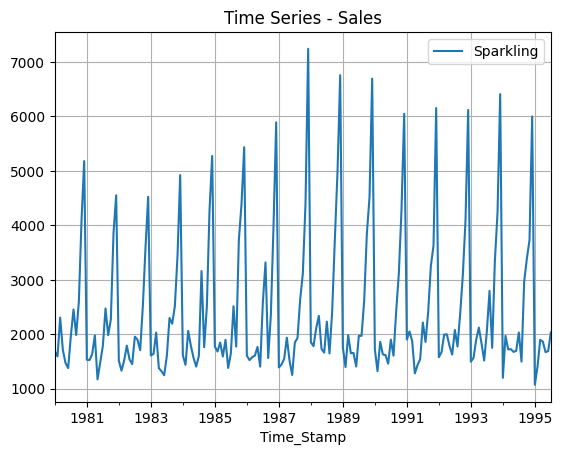

In [17]:
df.plot();
plt.grid()
plt.title('Time Series - Sales')
plt.show()

There is trend with seasonality

##Sales across different years and within different months across years.

###Yearly Boxplot

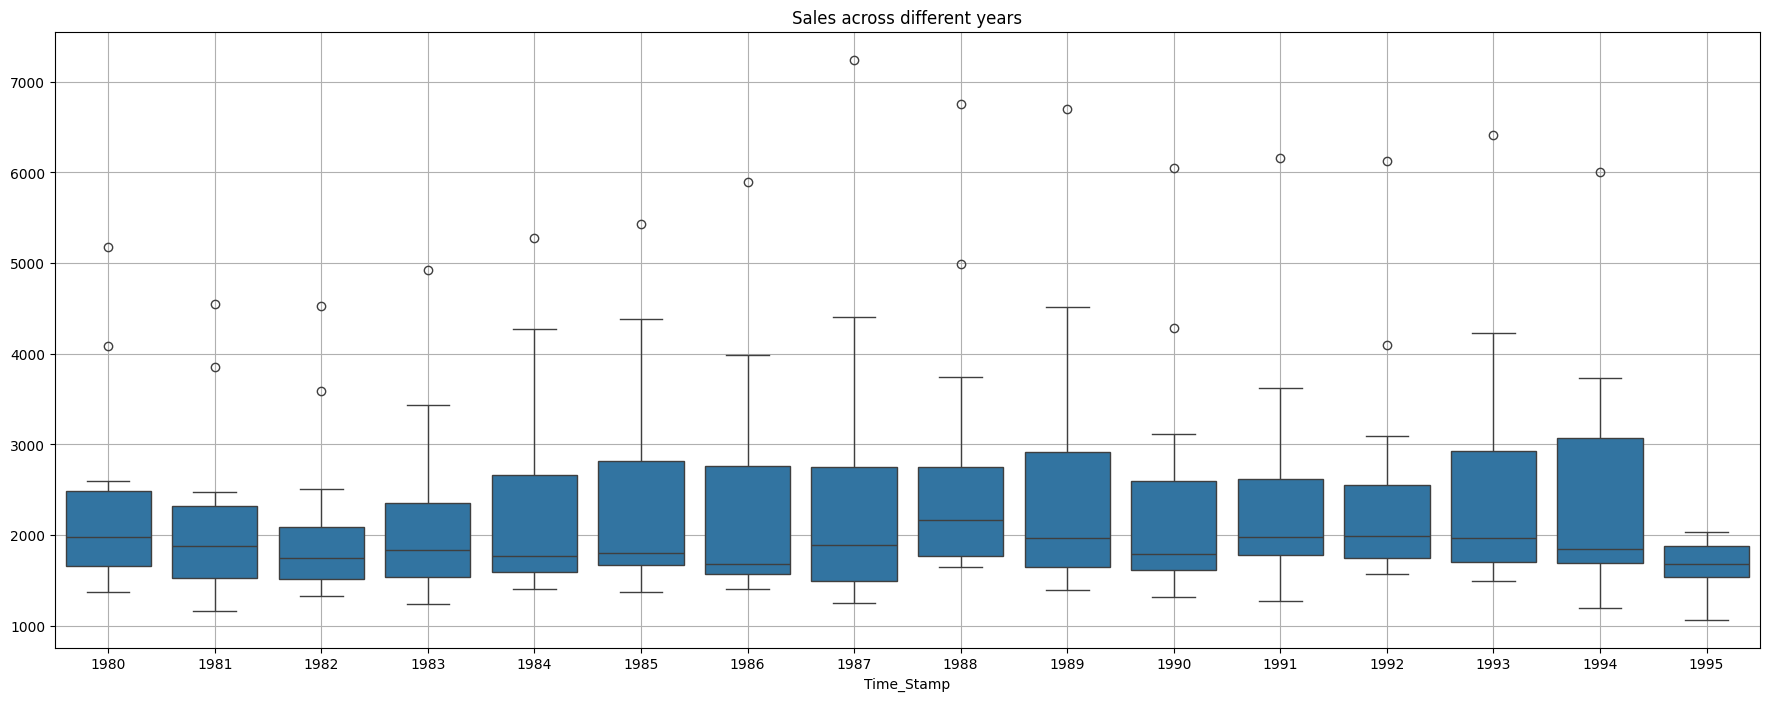

In [18]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df.index.year,y = df.values[:,0],ax=ax)
plt.grid()
plt.title('Sales across different years')
plt.show()

### Monthly Boxplot

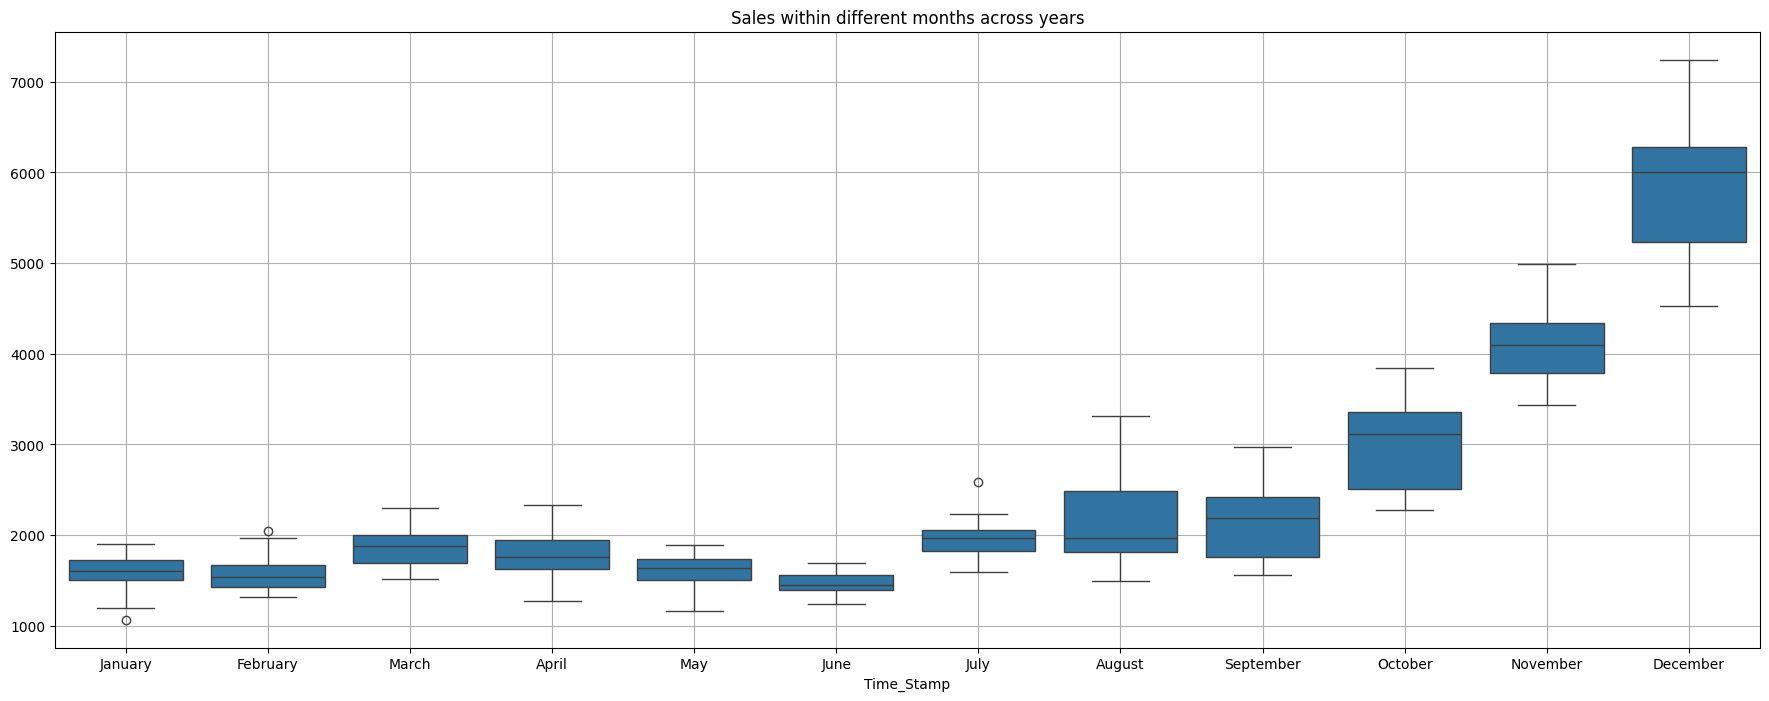

In [19]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df.index.month_name(),y = df.values[:,0],ax=ax)
plt.grid()
plt.title('Sales within different months across years')
plt.show()

In [20]:
df

Sparkling
Time_Stamp           
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471
...               ...
1995-03-01       1897
1995-04-01       1862
1995-05-01       1670
1995-06-01       1688
1995-07-01       2031

[187 rows x 1 columns]

In [21]:
monthly_sales_across_years = pd.pivot_table(df, values = 'Sparkling', columns = df.index.month_name(), index = df.index.year)
monthly_sales_across_years

Time_Stamp   April  August  December  February  January    July    June  \
Time_Stamp                                                                
1980        1712.0  2453.0    5179.0    1591.0   1686.0  1966.0  1377.0   
1981        1976.0  2472.0    4551.0    1523.0   1530.0  1781.0  1480.0   
1982        1790.0  1897.0    4524.0    1329.0   1510.0  1954.0  1449.0   
1983        1375.0  2298.0    4923.0    1638.0   1609.0  1600.0  1245.0   
1984        1789.0  3159.0    5274.0    1435.0   1609.0  1597.0  1404.0   
1985        1589.0  2512.0    5434.0    1682.0   1771.0  1645.0  1379.0   
1986        1605.0  3318.0    5891.0    1523.0   1606.0  2584.0  1403.0   
1987        1935.0  1930.0    7242.0    1442.0   1389.0  1847.0  1250.0   
1988        2336.0  1645.0    6757.0    1779.0   1853.0  2230.0  1661.0   
1989        1650.0  1968.0    6694.0    1394.0   1757.0  1971.0  1406.0   
1990        1628.0  1605.0    6047.0    1321.0   1720.0  1899.0  1457.0   
1991        1279.0  1857.0    6153.0    2049.0   1902.0  2214.0  1540.0   
1992        1997.0  1773.0    6119.0    1667.0   1577.0  2076.0  1625.0   
1993        2121.0  2795.0    6410.0    1564.0   1494.0  2048.0  1515.0   
1994        1725.0  1495.0    5999.0    1968.0   1197.0  2031.0  1693.0   
1995        1862.0     NaN       NaN    1402.0   1070.0  2031.0  1688.0   

Time_Stamp   March     May  November  October  September  
Time_Stamp                                                
1980        2304.0  1471.0    4087.0   2596.0     1984.0  
1981        1633.0  1170.0    3857.0   2273.0     1981.0  
1982        1518.0  1537.0    3593.0   2514.0     1706.0  
1983        2030.0  1320.0    3440.0   2511.0     2191.0  
1984        2061.0  1567.0    4273.0   2504.0     1759.0  
1985        1846.0  1896.0    4388.0   3727.0     1771.0  
1986        1577.0  1765.0    3987.0   2349.0     1562.0  
1987        1548.0  1518.0    4405.0   3114.0     2638.0  
1988        2108.0  1728.0    4988.0   3740.0     2421.0  
1989        1982.0  1654.0    4514.0   3845.0     2608.0  
1990        1859.0  1615.0    4286.0   3116.0     2424.0  
1991        1874.0  1432.0    3627.0   3252.0     2408.0  
1992        1993.0  1783.0    4096.0   3088.0     2377.0  
1993        1898.0  1831.0    4227.0   3339.0     1749.0  
1994        1720.0  1674.0    3729.0   3385.0     2968.0  
1995        1897.0  1670.0       NaN      NaN        NaN

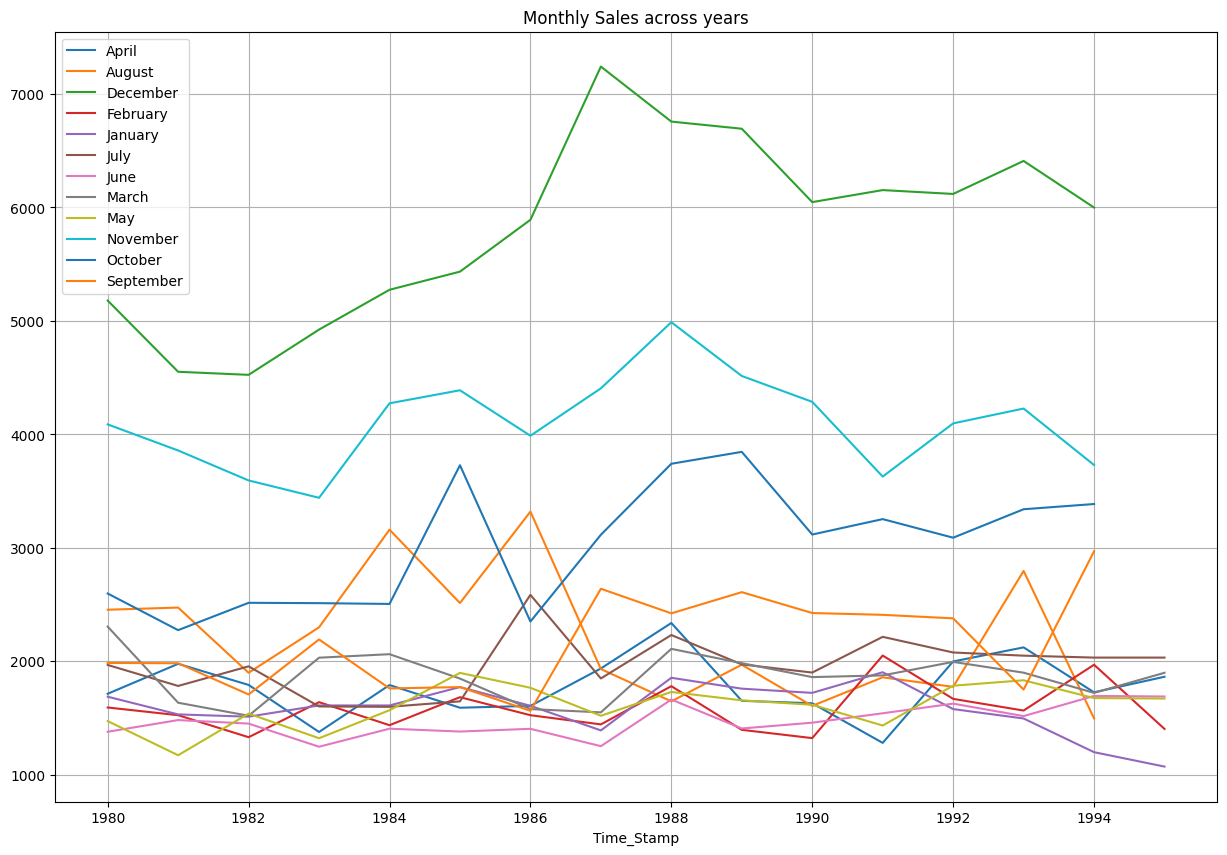

In [22]:
monthly_sales_across_years.plot(figsize=(15,10))
plt.grid()
plt.legend(loc='best')
plt.title('Monthly Sales across years')
plt.show()

## Insights



*   December is the standout peak for sales across years, reflecting strong holiday demand.
*   Sales rise from 1980 to the mid-1980s, particularly in December and mid-year months, with 1987 and 1988 showing peak sales in December.
*   Sales stabilize in the early 1990s, though there is some variation across months.



## Decompose the Time Series

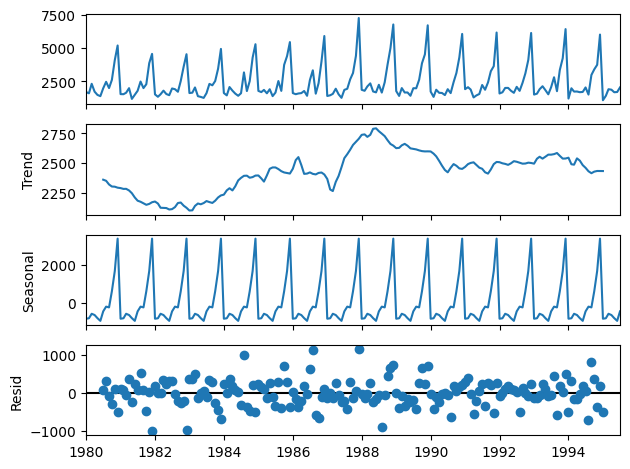

In [23]:
decomposition = seasonal_decompose(df,model='additive')
decomposition.plot();

In [24]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.round(2).head(12),'\n')
print('Seasonality','\n',seasonality.round(2).head(12),'\n')
print('Residual','\n',residual.round(2).head(12),'\n')

Trend 
 Time_Stamp
1980-01-01        NaN
1980-02-01        NaN
1980-03-01        NaN
1980-04-01        NaN
1980-05-01        NaN
1980-06-01        NaN
1980-07-01    2360.67
1980-08-01    2351.33
1980-09-01    2320.54
1980-10-01    2303.58
1980-11-01    2302.04
1980-12-01    2293.79
Name: trend, dtype: float64 

Seasonality 
 Time_Stamp
1980-01-01    -854.26
1980-02-01    -830.35
1980-03-01    -592.36
1980-04-01    -658.49
1980-05-01    -824.42
1980-06-01    -967.43
1980-07-01    -465.50
1980-08-01    -214.33
1980-09-01    -254.68
1980-10-01     599.77
1980-11-01    1675.07
1980-12-01    3386.98
Name: seasonal, dtype: float64 

Residual 
 Time_Stamp
1980-01-01       NaN
1980-02-01       NaN
1980-03-01       NaN
1980-04-01       NaN
1980-05-01       NaN
1980-06-01       NaN
1980-07-01     70.84
1980-08-01    316.00
1980-09-01    -81.86
1980-10-01   -307.35
1980-11-01    109.89
1980-12-01   -501.78
Name: resid, dtype: float64 



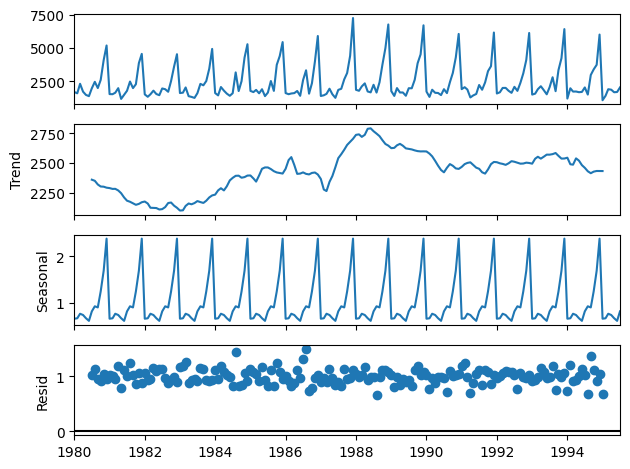

In [25]:
decomposition = seasonal_decompose(df,model='multiplicative')
decomposition.plot();

In [26]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.round(2).head(12),'\n')
print('Seasonality','\n',seasonality.round(2).head(12),'\n')
print('Residual','\n',residual.round(2).head(12),'\n')

Trend 
 Time_Stamp
1980-01-01        NaN
1980-02-01        NaN
1980-03-01        NaN
1980-04-01        NaN
1980-05-01        NaN
1980-06-01        NaN
1980-07-01    2360.67
1980-08-01    2351.33
1980-09-01    2320.54
1980-10-01    2303.58
1980-11-01    2302.04
1980-12-01    2293.79
Name: trend, dtype: float64 

Seasonality 
 Time_Stamp
1980-01-01    0.65
1980-02-01    0.66
1980-03-01    0.76
1980-04-01    0.73
1980-05-01    0.66
1980-06-01    0.60
1980-07-01    0.81
1980-08-01    0.92
1980-09-01    0.89
1980-10-01    1.24
1980-11-01    1.69
1980-12-01    2.38
Name: seasonal, dtype: float64 

Residual 
 Time_Stamp
1980-01-01     NaN
1980-02-01     NaN
1980-03-01     NaN
1980-04-01     NaN
1980-05-01     NaN
1980-06-01     NaN
1980-07-01    1.03
1980-08-01    1.14
1980-09-01    0.96
1980-10-01    0.91
1980-11-01    1.05
1980-12-01    0.95
Name: resid, dtype: float64 



##Insights

* It appears that the multiplicative decomposition may be a better fit for this data. The seasonal fluctuations seem to have a stronger relationship with the level of the series, which is characteristic of a multiplicative model.
* In the multiplicative model, the seasonal variations grew/shrank proportionally with the trend, while in this additive model, the seasonal variations are constant over time.
* If the seasonal variation in the data changes with the level of the trend, the multiplicative model is better suited.

# **Data Pre-processing**

## Train - Test Split

In [27]:
train    =   df[0:int(len(df)*0.7)]
test     =   df[int(len(df)*0.7):]

In [28]:
train

Sparkling
Time_Stamp           
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471
...               ...
1990-06-01       1457
1990-07-01       1899
1990-08-01       1605
1990-09-01       2424
1990-10-01       3116

[130 rows x 1 columns]

In [29]:
test

Sparkling
Time_Stamp           
1990-11-01       4286
1990-12-01       6047
1991-01-01       1902
1991-02-01       2049
1991-03-01       1874
1991-04-01       1279
1991-05-01       1432
1991-06-01       1540
1991-07-01       2214
1991-08-01       1857
1991-09-01       2408
1991-10-01       3252
1991-11-01       3627
1991-12-01       6153
1992-01-01       1577
1992-02-01       1667
1992-03-01       1993
1992-04-01       1997
1992-05-01       1783
1992-06-01       1625
1992-07-01       2076
1992-08-01       1773
1992-09-01       2377
1992-10-01       3088
1992-11-01       4096
1992-12-01       6119
1993-01-01       1494
1993-02-01       1564
1993-03-01       1898
1993-04-01       2121
1993-05-01       1831
1993-06-01       1515
1993-07-01       2048
1993-08-01       2795
1993-09-01       1749
1993-10-01       3339
1993-11-01       4227
1993-12-01       6410
1994-01-01       1197
1994-02-01       1968
1994-03-01       1720
1994-04-01       1725
1994-05-01       1674
1994-06-01       1693
1994-07-01       2031
1994-08-01       1495
1994-09-01       2968
1994-10-01       3385
1994-11-01       3729
1994-12-01       5999
1995-01-01       1070
1995-02-01       1402
1995-03-01       1897
1995-04-01       1862
1995-05-01       1670
1995-06-01       1688
1995-07-01       2031

In [30]:
print(train.shape)
print(test.shape)

(130, 1)
(57, 1)


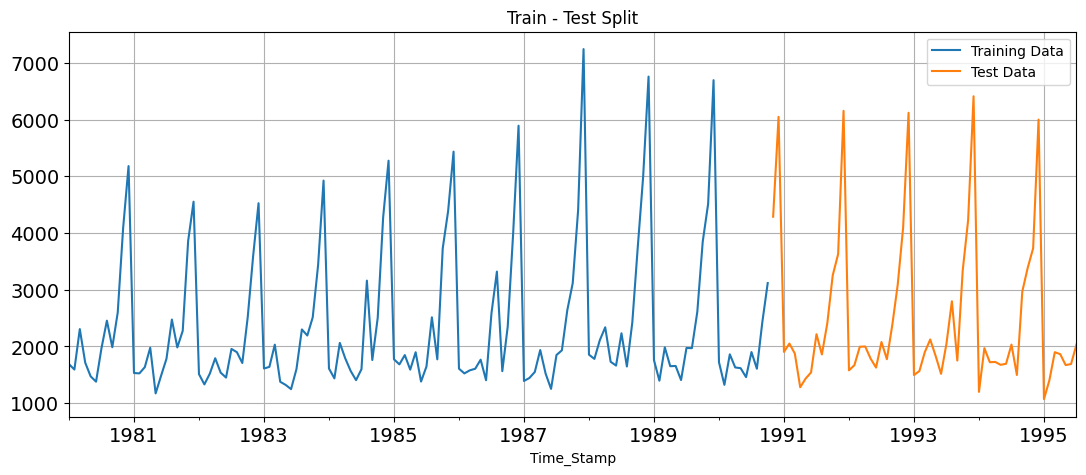

In [31]:
train['Sparkling'].plot(figsize=(13,5), fontsize=14)
test['Sparkling'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.title('Train - Test Split')
plt.show()

#**Model Building - Original Data**

##Linear Regression

Numerical time instance order for both the training and test set

In [32]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train) for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130]
Test Time instance 
 [130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186]


In [33]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

In [34]:
LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time

print('First few rows of Training Data','\n',LinearRegression_train.head(),'\n')
print('Last few rows of Training Data','\n',LinearRegression_train.tail(),'\n')
print('First few rows of Test Data','\n',LinearRegression_test.head(),'\n')
print('Last few rows of Test Data','\n',LinearRegression_test.tail(),'\n')

First few rows of Training Data 
             Sparkling  time
Time_Stamp                 
1980-01-01       1686     1
1980-02-01       1591     2
1980-03-01       2304     3
1980-04-01       1712     4
1980-05-01       1471     5 

Last few rows of Training Data 
             Sparkling  time
Time_Stamp                 
1990-06-01       1457   126
1990-07-01       1899   127
1990-08-01       1605   128
1990-09-01       2424   129
1990-10-01       3116   130 

First few rows of Test Data 
             Sparkling  time
Time_Stamp                 
1990-11-01       4286   130
1990-12-01       6047   131
1991-01-01       1902   132
1991-02-01       2049   133
1991-03-01       1874   134 

Last few rows of Test Data 
             Sparkling  time
Time_Stamp                 
1995-03-01       1897   182
1995-04-01       1862   183
1995-05-01       1670   184
1995-06-01       1688   185
1995-07-01       2031   186 



In [35]:
lr = LinearRegression()

In [36]:
lr.fit(LinearRegression_train[['time']],LinearRegression_train['Sparkling'].values)

LinearRegression()

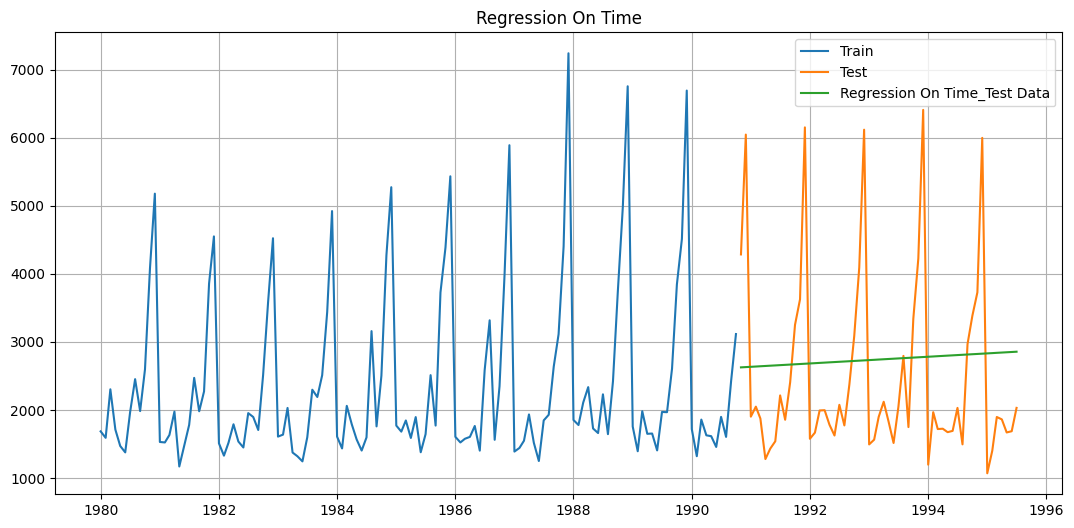

In [37]:
test_predictions_model1         = lr.predict(LinearRegression_test[['time']])
LinearRegression_test['RegOnTime'] = test_predictions_model1

plt.figure(figsize=(13,6))
plt.plot( train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')
plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.grid()
plt.title('Regression On Time');

### Model Evaluation

In [38]:
linear_reg_rmse_test = mean_squared_error(LinearRegression_test['Sparkling'],test_predictions_model1,squared=False)
print("For Linear regression forecast on the Test Data,  RMSE is %3.2f" %(linear_reg_rmse_test))

For Linear regression forecast on the Test Data,  RMSE is 1391.71


In [39]:
resultsDf = pd.DataFrame({'Test RMSE': [linear_reg_rmse_test]},index=['RegressionOnTime'])
resultsDf

Test RMSE
RegressionOnTime  1391.708631

##Simple Average

In [40]:
SA_train = train.copy()
SA_test = test.copy()

In [41]:
avg_value = np.mean(SA_train)

In [42]:
forecast = np.full_like(SA_test, avg_value)

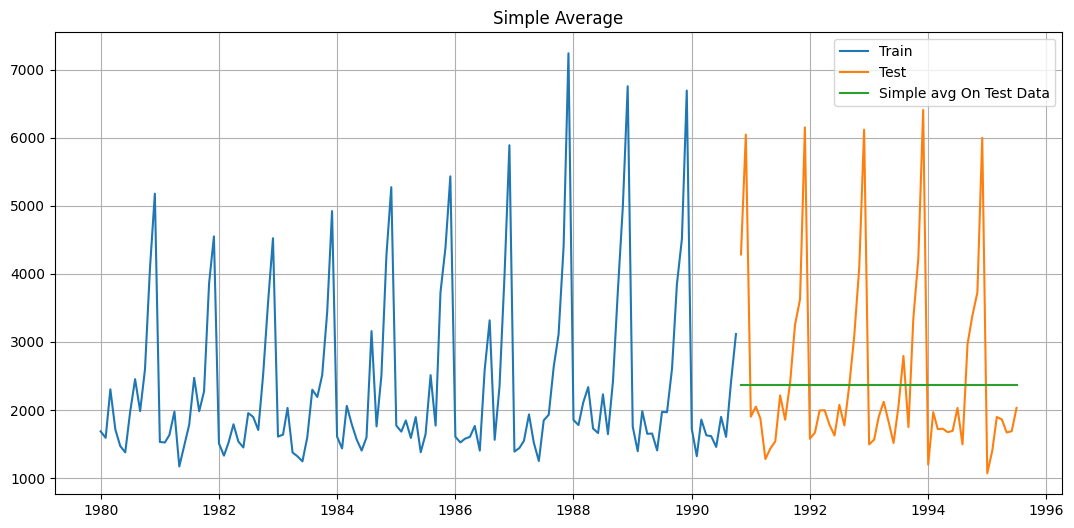

In [43]:
SA_test['SimpleAvg_Pred'] = forecast

plt.figure(figsize=(13,6))
plt.plot( train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')
plt.plot(SA_test['SimpleAvg_Pred'], label='Simple avg On Test Data')
plt.legend(loc='best')
plt.grid()
plt.title('Simple Average');

### Model Evaluation

In [44]:
SA_rmse_test = mean_squared_error(SA_test['Sparkling'],forecast,squared=False)
print("For Simple Average forecast on the Test Data,  RMSE is %3.2f" %(SA_rmse_test))

For Simple Average forecast on the Test Data,  RMSE is 1368.77


In [45]:
resultsDf_2 = pd.DataFrame({'Test RMSE': [SA_rmse_test]}
                           ,index=['SimpleAverage'])

resultsDf = pd.concat([resultsDf, resultsDf_2])
resultsDf

Test RMSE
RegressionOnTime  1391.708631
SimpleAverage     1368.774051

##Moving Average

In [46]:
MovingAverage = df.copy()
MovingAverage.head()

Sparkling
Time_Stamp           
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471

In [47]:
MovingAverage['Trailing_2'] = MovingAverage['Sparkling'].rolling(2).mean()
MovingAverage['Trailing_4'] = MovingAverage['Sparkling'].rolling(4).mean()
MovingAverage['Trailing_6'] = MovingAverage['Sparkling'].rolling(6).mean()
MovingAverage['Trailing_9'] = MovingAverage['Sparkling'].rolling(9).mean()

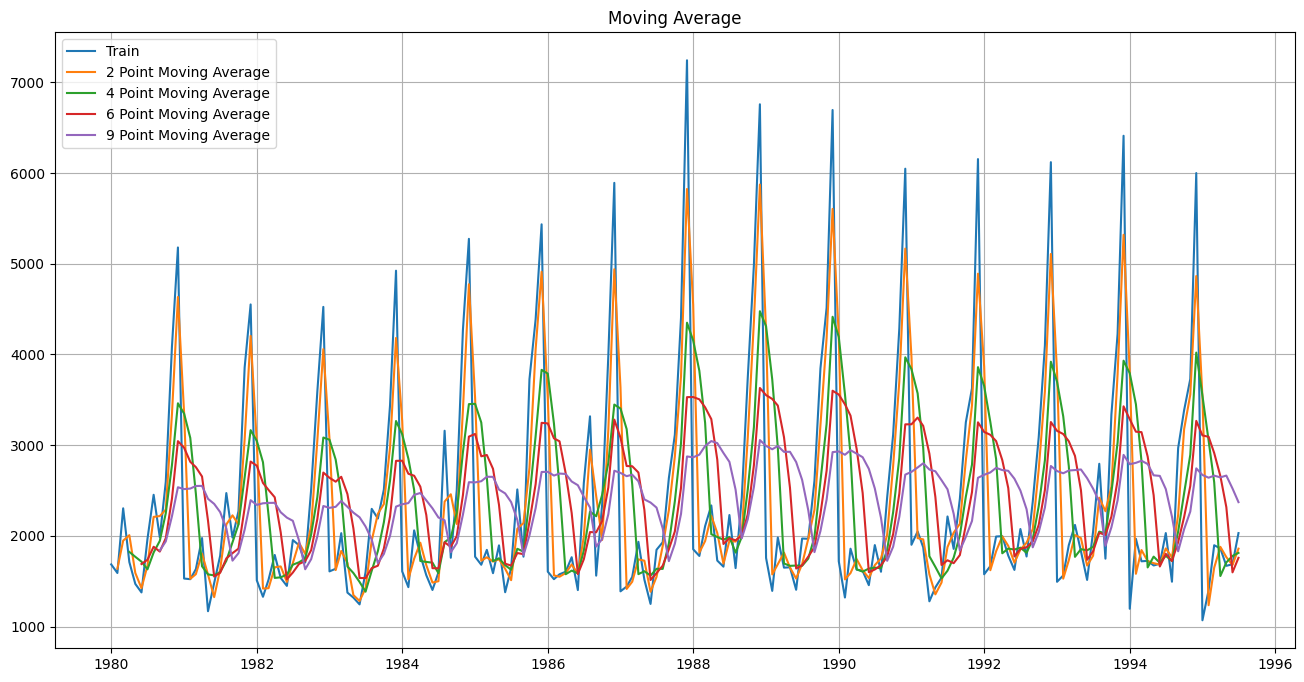

In [48]:


plt.figure(figsize=(16,8))
plt.plot(MovingAverage['Sparkling'], label='Train')
plt.plot(MovingAverage['Trailing_2'], label='2 Point Moving Average')
plt.plot(MovingAverage['Trailing_4'], label='4 Point Moving Average')
plt.plot(MovingAverage['Trailing_6'],label = '6 Point Moving Average')
plt.plot(MovingAverage['Trailing_9'],label = '9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid()
plt.title('Moving Average');

In [49]:
trailing_MovingAverage_train=MovingAverage[0:int(len(MovingAverage)*0.7)]
trailing_MovingAverage_test=MovingAverage[int(len(MovingAverage)*0.7):]

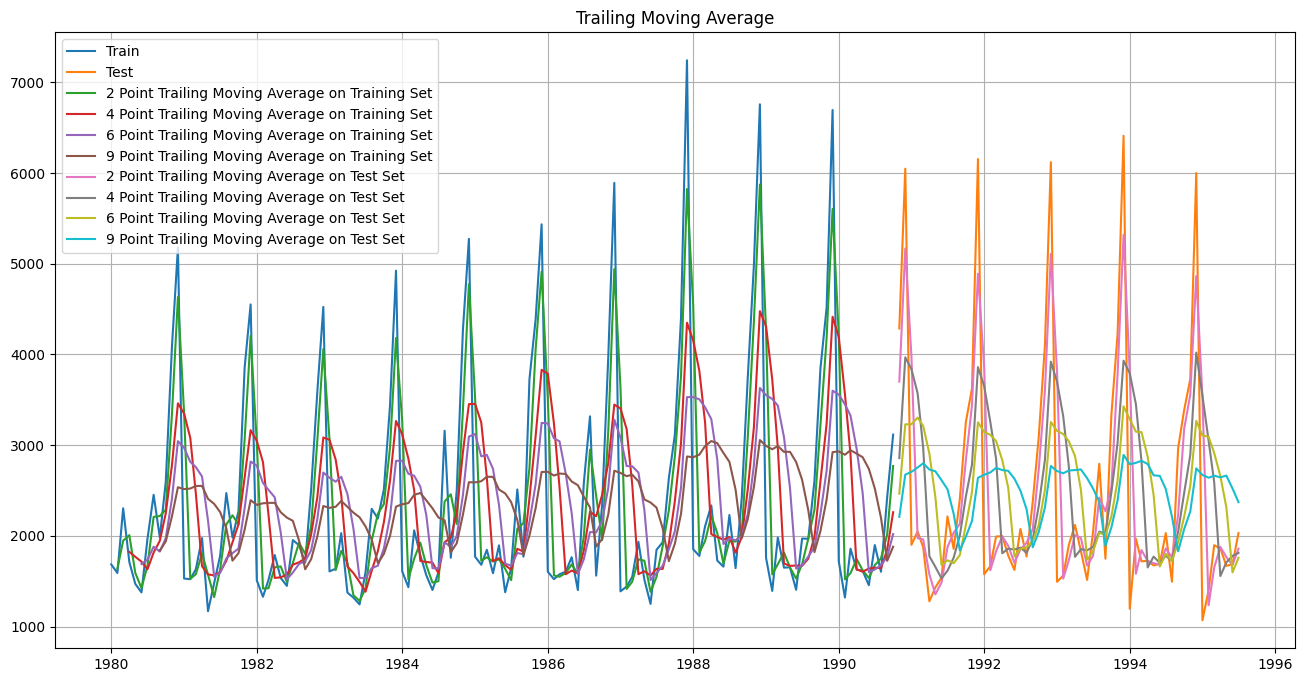

In [50]:
plt.figure(figsize=(16,8))
plt.plot(trailing_MovingAverage_train['Sparkling'], label='Train')
plt.plot(trailing_MovingAverage_test['Sparkling'], label='Test')

plt.plot(trailing_MovingAverage_train['Trailing_2'], label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_4'], label='4 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_6'],label = '6 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_9'],label = '9 Point Trailing Moving Average on Training Set')

plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_4'], label='4 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_6'],label = '6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_9'],label = '9 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid()
plt.title('Trailing Moving Average');

### Model Evaluation

In [51]:
## Test Data - RMSE --> 2 point Trailing MA

rmse_model3_test_2 = mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_2'],squared=False)
print("For 2 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model3_test_2))

## Test Data - RMSE  --> 4 point Trailing MA

rmse_model3_test_4 = mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_4'],squared=False)
print("For 4 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model3_test_4))

## Test Data - RMSE --> 6 point Trailing MA

rmse_model3_test_6 = mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_6'],squared=False)
print("For 6 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model3_test_6))

## Test Data - RMSE  --> 9 point Trailing MA

rmse_model3_test_9 = mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_9'],squared=False)
print("For 9 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f " %(rmse_model3_test_9))

For 2 point Moving Average Model forecast on the Training Data,  RMSE is 811.179
For 4 point Moving Average Model forecast on the Training Data,  RMSE is 1184.213
For 6 point Moving Average Model forecast on the Training Data,  RMSE is 1337.201
For 9 point Moving Average Model forecast on the Training Data,  RMSE is 1422.653 


In [52]:

resultsDf_3 = pd.DataFrame({'Test RMSE': [rmse_model3_test_2,rmse_model3_test_4
                                          ,rmse_model3_test_6,rmse_model3_test_9]}
                           ,index=['2pointTrailingMovingAverage','4pointTrailingMovingAverage'
                                   ,'6pointTrailingMovingAverage','9pointTrailingMovingAverage'])

resultsDf = pd.concat([resultsDf, resultsDf_3])
resultsDf

Test RMSE
RegressionOnTime             1391.708631
SimpleAverage                1368.774051
2pointTrailingMovingAverage   811.178937
4pointTrailingMovingAverage  1184.213295
6pointTrailingMovingAverage  1337.200524
9pointTrailingMovingAverage  1422.653281

##Simple Exponential Smoothing

In [53]:
SES_train = train.copy()
SES_test = test.copy()

In [54]:
model_SES = SimpleExpSmoothing(SES_train['Sparkling'])

In [55]:
model_SES_autofit = model_SES.fit(optimized=True)

In [56]:
model_SES_autofit.params

{'smoothing_level': 0.037534299016257884,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1686.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [57]:
SES_test['predict'] = model_SES_autofit.forecast(steps=len(test))
SES_test.head()

Sparkling      predict
Time_Stamp                        
1990-11-01       4286  2465.235698
1990-12-01       6047  2465.235698
1991-01-01       1902  2465.235698
1991-02-01       2049  2465.235698
1991-03-01       1874  2465.235698

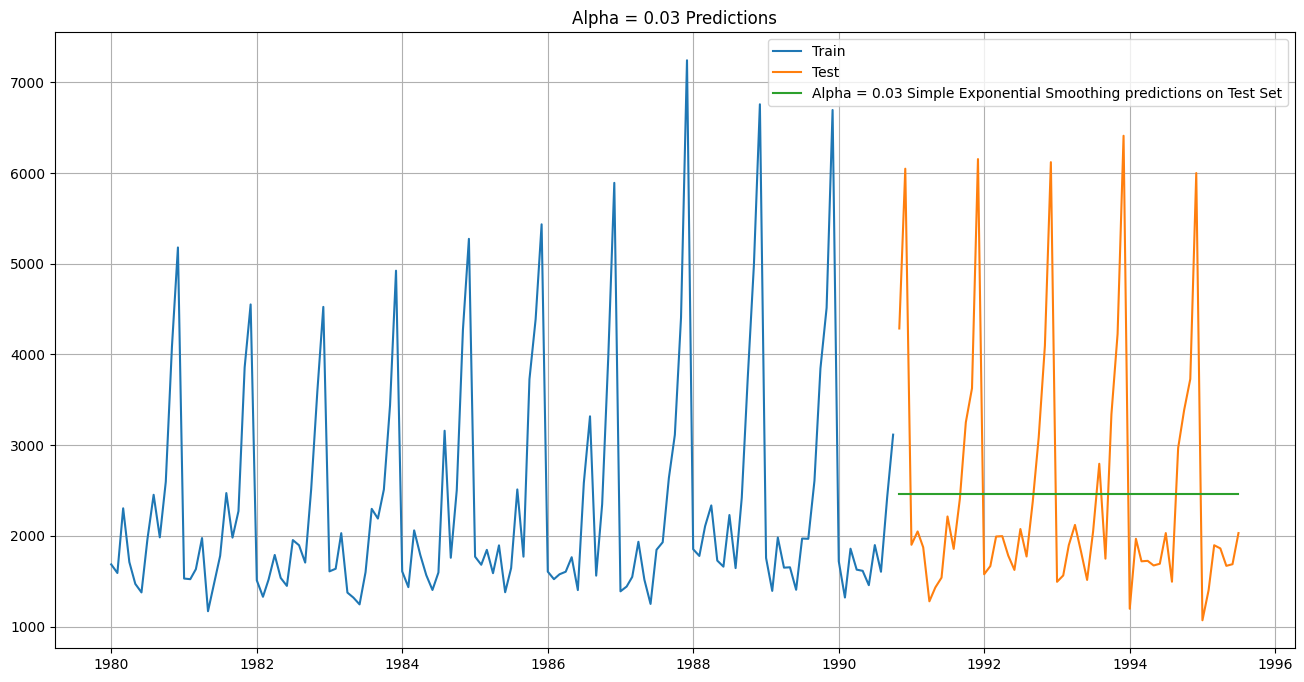

In [58]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(SES_train['Sparkling'], label='Train')
plt.plot(SES_test['Sparkling'], label='Test')

plt.plot(SES_test['predict'], label='Alpha = 0.03 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.03 Predictions');

### Model Evaluation for $\alpha$ = 0.03 : Simple Exponential Smoothing

In [59]:
rmse_model4_test_1 = mean_squared_error(SES_test['Sparkling'],SES_test['predict'],squared=False)
print("For Alpha = 0.03 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is %3.3f" %(rmse_model4_test_1))

For Alpha = 0.03 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is 1362.429


In [60]:
resultsDf_4 = pd.DataFrame({'Test RMSE': [rmse_model4_test_1]},index=['Alpha=0.03,SimpleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_4])
resultsDf

Test RMSE
RegressionOnTime                       1391.708631
SimpleAverage                          1368.774051
2pointTrailingMovingAverage             811.178937
4pointTrailingMovingAverage            1184.213295
6pointTrailingMovingAverage            1337.200524
9pointTrailingMovingAverage            1422.653281
Alpha=0.03,SimpleExponentialSmoothing  1362.428949

In [61]:
len(test)

57

#### Setting different alpha values.



In [62]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_5 = pd.DataFrame({'Alpha Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_5

Empty DataFrame
Columns: [Alpha Values, Train RMSE, Test RMSE]
Index: []

In [63]:
for i in np.arange(0.3,1,0.1):
    model_SES_alpha_i = model_SES.fit(smoothing_level=i,optimized=False,use_brute=True)
    SES_train['predict',i] = model_SES_alpha_i.fittedvalues
    SES_test['predict',i] = model_SES_alpha_i.forecast(steps=57)

    rmse_model4_train_i = mean_squared_error(SES_train['Sparkling'],SES_train['predict',i],squared=False)

    rmse_model4_test_i = mean_squared_error(SES_test['Sparkling'],SES_test['predict',i],squared=False)

    new_row = pd.DataFrame({
        'Alpha Values': [i],
        'Train RMSE': [rmse_model4_train_i],
        'Test RMSE': [rmse_model4_test_i]
    })
    resultsDf_5 = pd.concat([resultsDf_5, new_row], ignore_index=True)

In [64]:
resultsDf_5

Alpha Values   Train RMSE    Test RMSE
0           0.3  1331.102204  1372.323705
1           0.4  1329.814823  1363.037803
2           0.5  1326.403864  1364.863549
3           0.6  1325.588422  1379.988733
4           0.7  1329.257530  1404.659104
5           0.8  1337.879425  1434.578214
6           0.9  1351.645478  1466.179706

## Model Evaluation

In [65]:
resultsDf_5.sort_values(by=['Test RMSE'],ascending=True)

Alpha Values   Train RMSE    Test RMSE
1           0.4  1329.814823  1363.037803
2           0.5  1326.403864  1364.863549
0           0.3  1331.102204  1372.323705
3           0.6  1325.588422  1379.988733
4           0.7  1329.257530  1404.659104
5           0.8  1337.879425  1434.578214
6           0.9  1351.645478  1466.179706

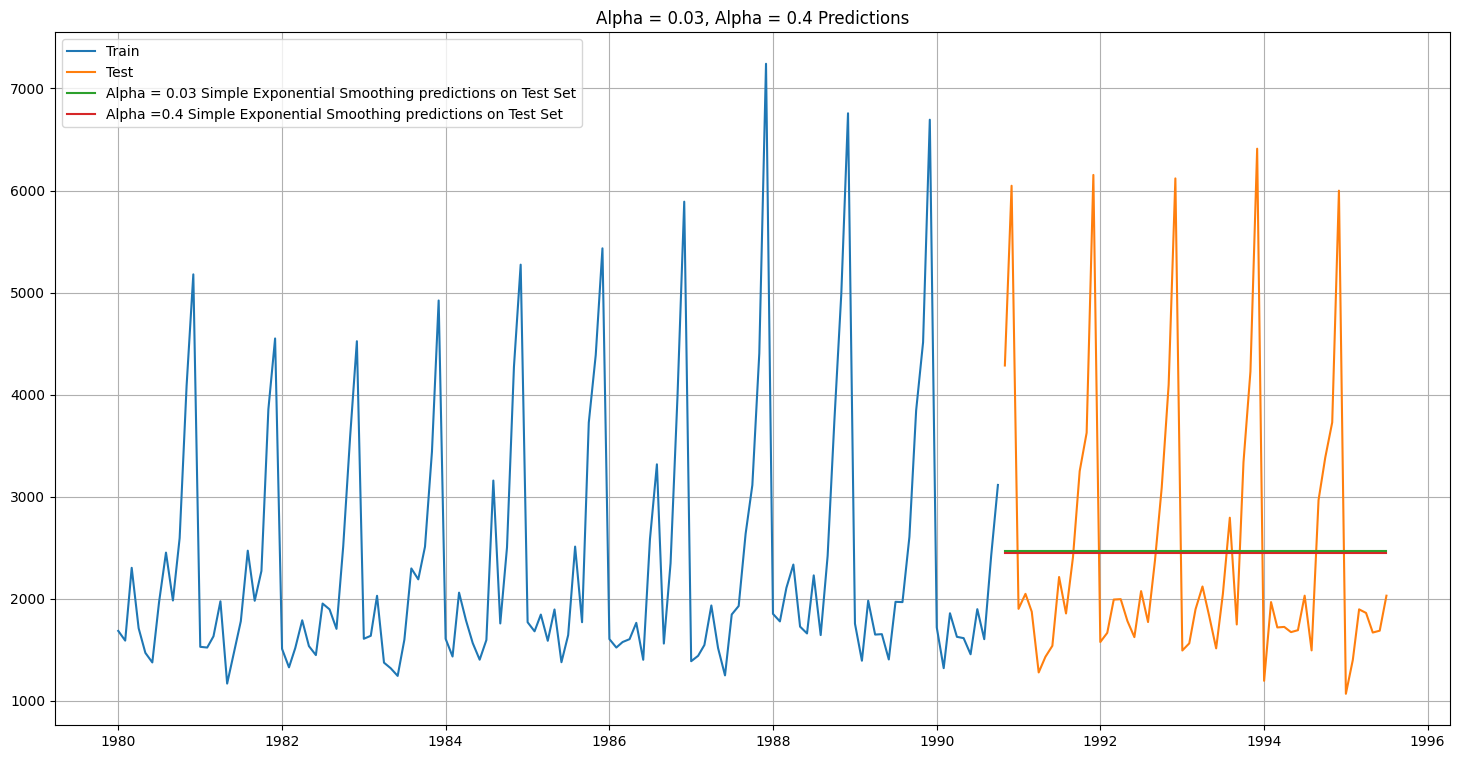

In [66]:


plt.figure(figsize=(18,9))
plt.plot(SES_train['Sparkling'], label='Train')
plt.plot(SES_test['Sparkling'], label='Test')

plt.plot(SES_test['predict'], label='Alpha = 0.03 Simple Exponential Smoothing predictions on Test Set')

plt.plot(SES_test['predict', 0.4], label='Alpha =0.4 Simple Exponential Smoothing predictions on Test Set')



plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.03, Alpha = 0.4 Predictions');

In [67]:
resultsDf_5_1 = pd.DataFrame({'Test RMSE': [resultsDf_5.sort_values(by=['Test RMSE'],ascending=True).values[0][2]]}
                           ,index=['Alpha=0.4,SimpleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_5_1])
resultsDf

Test RMSE
RegressionOnTime                       1391.708631
SimpleAverage                          1368.774051
2pointTrailingMovingAverage             811.178937
4pointTrailingMovingAverage            1184.213295
6pointTrailingMovingAverage            1337.200524
9pointTrailingMovingAverage            1422.653281
Alpha=0.03,SimpleExponentialSmoothing  1362.428949
Alpha=0.4,SimpleExponentialSmoothing   1363.037803

##Double Exponential Smoothing (Holt's Model)

In [68]:
DES_train = train.copy()
DES_test = test.copy()

In [69]:
model_DES = Holt(DES_train['Sparkling'])

In [70]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_6 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_6

Empty DataFrame
Columns: [Alpha Values, Beta Values, Train RMSE, Test RMSE]
Index: []

In [71]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_trend=j,optimized=False,use_brute=True)
        DES_train['predict',i,j] = model_DES_alpha_i_j.fittedvalues
        DES_test['predict',i,j] = model_DES_alpha_i_j.forecast(steps=57)

        rmse_model5_train = mean_squared_error(DES_train['Sparkling'],DES_train['predict',i,j],squared=False)

        rmse_model5_test = mean_squared_error(DES_test['Sparkling'],DES_test['predict',i,j],squared=False)

        new_row = pd.DataFrame({
        'Alpha Values': [i],
        'Beta Values': [j],
        'Train RMSE': [rmse_model5_train],
        'Test RMSE': [rmse_model5_test]
        })
        resultsDf_6 = pd.concat([resultsDf_6, new_row], ignore_index=True)

In [72]:
resultsDf_6

Alpha Values  Beta Values   Train RMSE     Test RMSE
0            0.3          0.3  1567.524066   1597.853999
1            0.3          0.4  1662.549225   4023.672164
2            0.3          0.5  1758.543876   8879.172380
3            0.3          0.6  1843.560670  15645.080035
4            0.3          0.7  1902.735965  23205.442323
..           ...          ...          ...           ...
59           1.0          0.6  1764.658812  20558.025827
60           1.0          0.7  1837.425218  22155.074151
61           1.0          0.8  1915.148280  23241.839479
62           1.0          0.9  1999.362743  23787.747852
63           1.0          1.0  2092.531564  23712.944127

[64 rows x 4 columns]

In [73]:
resultsDf_6.sort_values(by=['Test RMSE']).head()

Alpha Values  Beta Values   Train RMSE    Test RMSE
0            0.3          0.3  1567.524066  1597.853999
1            0.3          0.4  1662.549225  4023.672164
8            0.4          0.3  1556.795694  5049.478887
16           0.5          0.3  1525.615506  7817.569799
2            0.3          0.5  1758.543876  8879.172380

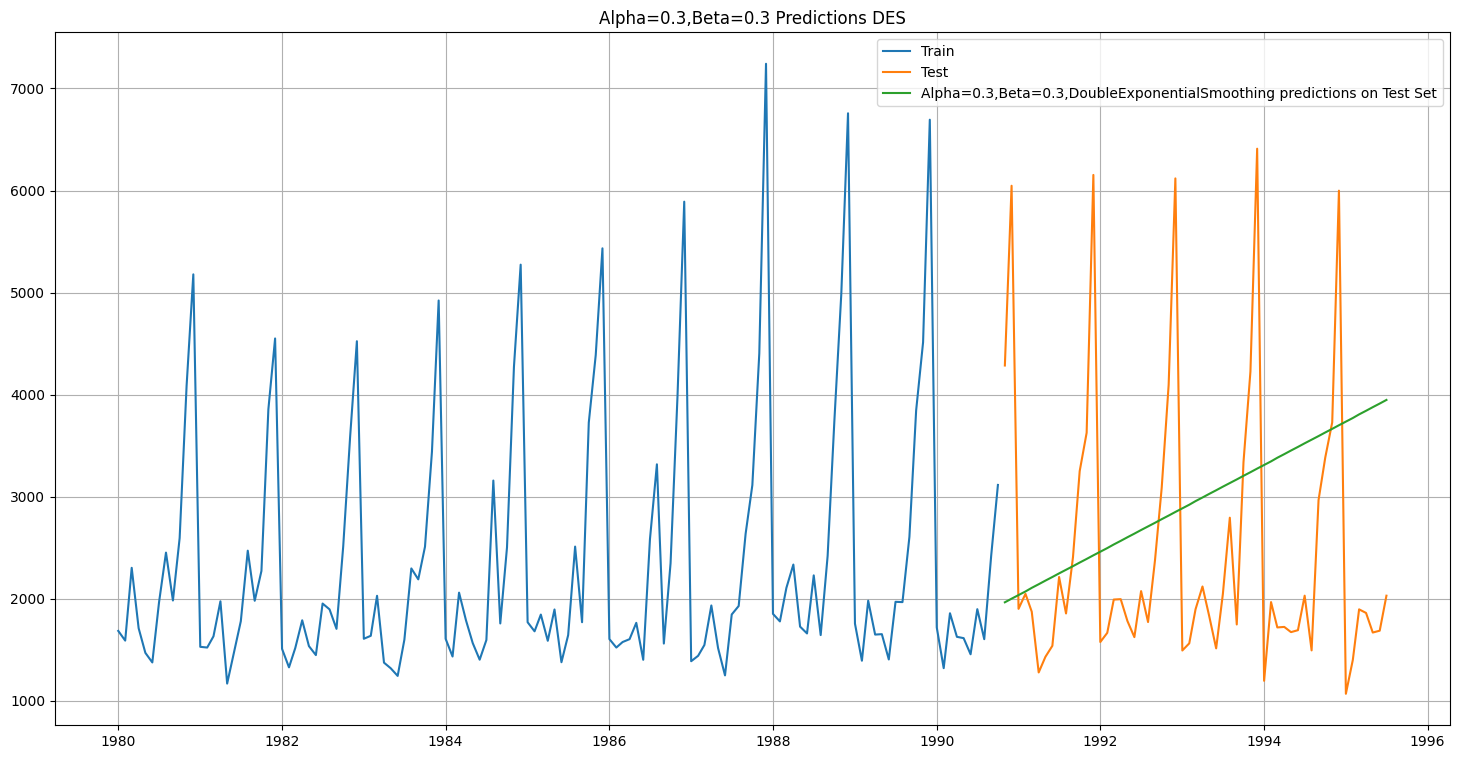

In [74]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(DES_train['Sparkling'], label='Train')
plt.plot(DES_test['Sparkling'], label='Test')

plt.plot(DES_test['predict', 0.3, 0.3], label='Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid()
plt.title('Alpha=0.3,Beta=0.3 Predictions DES');

In [75]:
resultsDf_6_1 = pd.DataFrame({'Test RMSE': [resultsDf_6.sort_values(by=['Test RMSE']).values[0][3]]}
                           ,index=['Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_6_1])
resultsDf

Test RMSE
RegressionOnTime                               1391.708631
SimpleAverage                                  1368.774051
2pointTrailingMovingAverage                     811.178937
4pointTrailingMovingAverage                    1184.213295
6pointTrailingMovingAverage                    1337.200524
9pointTrailingMovingAverage                    1422.653281
Alpha=0.03,SimpleExponentialSmoothing          1362.428949
Alpha=0.4,SimpleExponentialSmoothing           1363.037803
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing  1597.853999

##Triple Exponential Smoothing (Holt - Winter's Model)

In [76]:
TES_train = train.copy()
TES_test = test.copy()

In [77]:
TES_train

Sparkling
Time_Stamp           
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471
...               ...
1990-06-01       1457
1990-07-01       1899
1990-08-01       1605
1990-09-01       2424
1990-10-01       3116

[130 rows x 1 columns]

In [78]:
model_TES = ExponentialSmoothing(TES_train['Sparkling'],trend='additive',seasonal='multiplicative')

In [79]:
model_TES_autofit = model_TES.fit()

In [80]:
model_TES_autofit.params

{'smoothing_level': 0.07571445210103464,
 'smoothing_trend': 0.06489808813237438,
 'smoothing_seasonal': 0.3765608370780376,
 'damping_trend': nan,
 'initial_level': 2356.54174944041,
 'initial_trend': -9.180926180482402,
 'initial_seasons': array([0.71186629, 0.67768289, 0.89647955, 0.79722705, 0.64099767,
        0.64026213, 0.86701095, 1.11336214, 0.89797444, 1.18549449,
        1.8343214 , 2.32723166]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [81]:
## Prediction on the test data

TES_test['auto_predict'] = model_TES_autofit.forecast(steps=len(test))
TES_test.head()

Sparkling  auto_predict
Time_Stamp                         
1990-11-01       4286   4327.609727
1990-12-01       6047   6208.854280
1991-01-01       1902   1621.601290
1991-02-01       2049   1379.862158
1991-03-01       1874   1791.912018

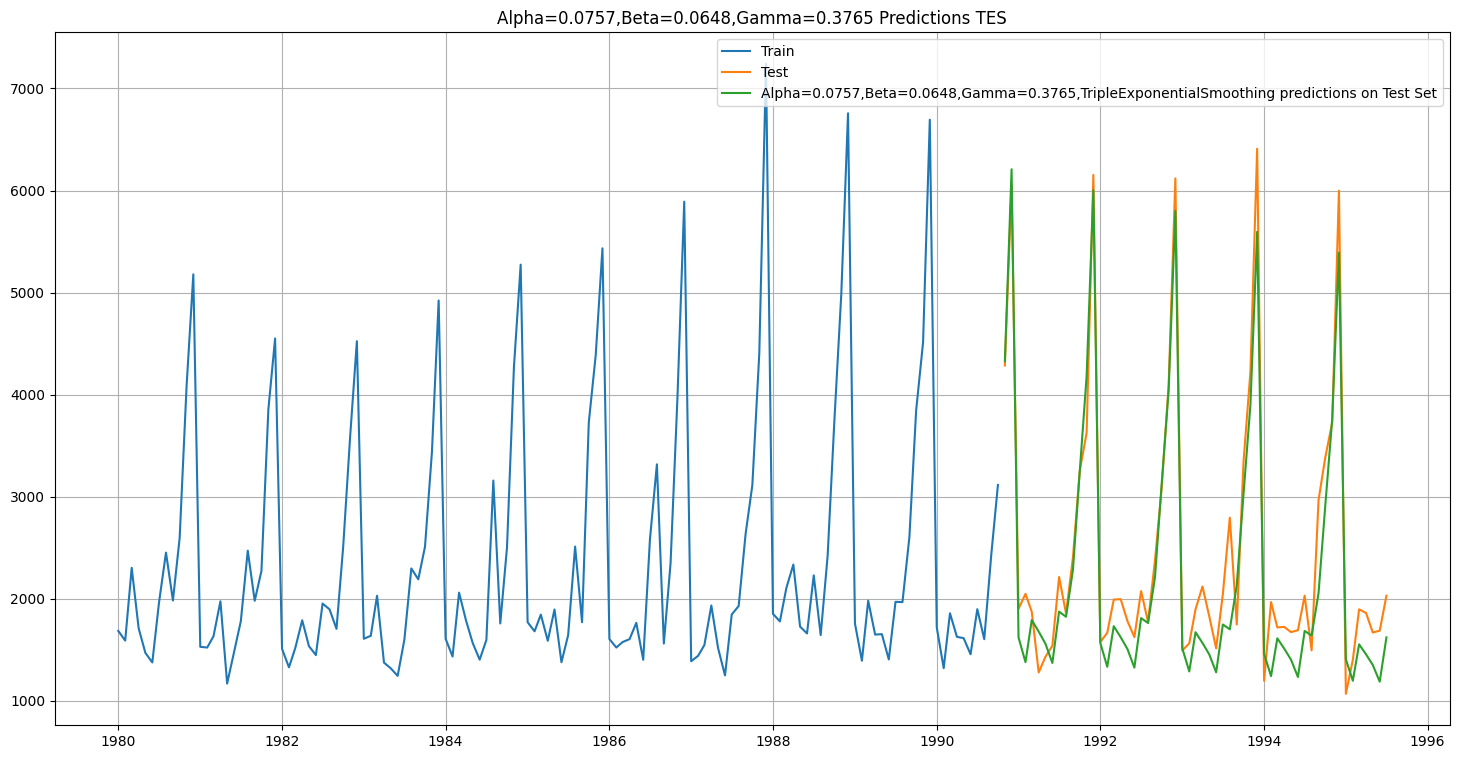

In [82]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(TES_train['Sparkling'], label='Train')
plt.plot(TES_test['Sparkling'], label='Test')

plt.plot(TES_test['auto_predict'], label='Alpha=0.0757,Beta=0.0648,Gamma=0.3765,TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid()
plt.title('Alpha=0.0757,Beta=0.0648,Gamma=0.3765 Predictions TES');

In [83]:
## Test Data

rmse_model6_test_1 = mean_squared_error(TES_test['Sparkling'],TES_test['auto_predict'],squared=False)
print("For Alpha=0.0757,Beta=0.0648,Gamma=0.3765, Triple Exponential Smoothing Model forecast on the Test Data,  RMSE is %3.3f" %(rmse_model6_test_1))

For Alpha=0.0757,Beta=0.0648,Gamma=0.3765, Triple Exponential Smoothing Model forecast on the Test Data,  RMSE is 381.657


In [84]:
resultsDf_7_1 = pd.DataFrame({'Test RMSE': [rmse_model6_test_1]}
                           ,index=['Alpha=0.0757,Beta=0.0648,Gamma=0.3765,TripleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_7_1])
resultsDf

Test RMSE
RegressionOnTime                                    1391.708631
SimpleAverage                                       1368.774051
2pointTrailingMovingAverage                          811.178937
4pointTrailingMovingAverage                         1184.213295
6pointTrailingMovingAverage                         1337.200524
9pointTrailingMovingAverage                         1422.653281
Alpha=0.03,SimpleExponentialSmoothing               1362.428949
Alpha=0.4,SimpleExponentialSmoothing                1363.037803
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing       1597.853999
Alpha=0.0757,Beta=0.0648,Gamma=0.3765,TripleExp...   381.657232

In [85]:


resultsDf_7_2 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_7_2

Empty DataFrame
Columns: [Alpha Values, Beta Values, Gamma Values, Train RMSE, Test RMSE]
Index: []

In [86]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        for k in np.arange(0.3,1.1,0.1):
            model_TES_alpha_i_j_k = model_TES.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
            TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=57)

            rmse_model7_train = mean_squared_error(TES_train['Sparkling'],TES_train['predict',i,j,k],squared=False)

            rmse_model7_test = mean_squared_error(TES_test['Sparkling'],TES_test['predict',i,j,k],squared=False)
            new_row = pd.DataFrame({
            'Alpha Values': [i],
            'Beta Values': [j],
            'Gamma Values':[k],
            'Train RMSE': [rmse_model7_train],
            'Test RMSE': [rmse_model7_test]
            })
            resultsDf_7_2 = pd.concat([resultsDf_7_2, new_row], ignore_index=True)



In [87]:
resultsDf_7_2

Alpha Values  Beta Values  Gamma Values    Train RMSE     Test RMSE
0             0.3          0.3           0.3  3.923714e+02  2.355322e+03
1             0.3          0.3           0.4  3.970733e+02  2.855432e+03
2             0.3          0.3           0.5  4.091670e+02  3.193451e+03
3             0.3          0.3           0.6  4.304007e+02  3.423716e+03
4             0.3          0.3           0.7  4.631866e+02  3.615456e+03
..            ...          ...           ...           ...           ...
507           1.0          1.0           0.6  1.897409e+05  5.807913e+03
508           1.0          1.0           0.7  2.680381e+05  3.585079e+05
509           1.0          1.0           0.8  1.110365e+06  2.855947e+06
510           1.0          1.0           0.9  7.751842e+04  7.857850e+04
511           1.0          1.0           1.0  2.466982e+04  1.354272e+05

[512 rows x 5 columns]

In [88]:
resultsDf_7_2.sort_values(by=['Test RMSE']).head()

Alpha Values  Beta Values  Gamma Values  Train RMSE   Test RMSE
264           0.7          0.4           0.3  512.023844  422.908833
144           0.5          0.5           0.3  472.088500  451.601686
169           0.5          0.8           0.4  625.557444  481.151676
200           0.6          0.4           0.3  479.344459  498.796626
328           0.8          0.4           0.3  544.126424  502.371290

In [89]:
resultsDf_7_3 = pd.DataFrame({'Test RMSE': [resultsDf_7_2.sort_values(by=['Test RMSE']).values[0][4]]}
                           ,index=['Alpha=0.7,Beta=0.4,Gamma=0.3,TripleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_7_3])
resultsDf

Test RMSE
RegressionOnTime                                    1391.708631
SimpleAverage                                       1368.774051
2pointTrailingMovingAverage                          811.178937
4pointTrailingMovingAverage                         1184.213295
6pointTrailingMovingAverage                         1337.200524
9pointTrailingMovingAverage                         1422.653281
Alpha=0.03,SimpleExponentialSmoothing               1362.428949
Alpha=0.4,SimpleExponentialSmoothing                1363.037803
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing       1597.853999
Alpha=0.0757,Beta=0.0648,Gamma=0.3765,TripleExp...   381.657232
Alpha=0.7,Beta=0.4,Gamma=0.3,TripleExponentialS...   422.908833

In [90]:
print('Sorted by RMSE values on the Test Data:','\n',)
resultsDf.sort_values(by=['Test RMSE'])

Sorted by RMSE values on the Test Data: 



Test RMSE
Alpha=0.0757,Beta=0.0648,Gamma=0.3765,TripleExp...   381.657232
Alpha=0.7,Beta=0.4,Gamma=0.3,TripleExponentialS...   422.908833
2pointTrailingMovingAverage                          811.178937
4pointTrailingMovingAverage                         1184.213295
6pointTrailingMovingAverage                         1337.200524
Alpha=0.03,SimpleExponentialSmoothing               1362.428949
Alpha=0.4,SimpleExponentialSmoothing                1363.037803
SimpleAverage                                       1368.774051
RegressionOnTime                                    1391.708631
9pointTrailingMovingAverage                         1422.653281
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing       1597.853999

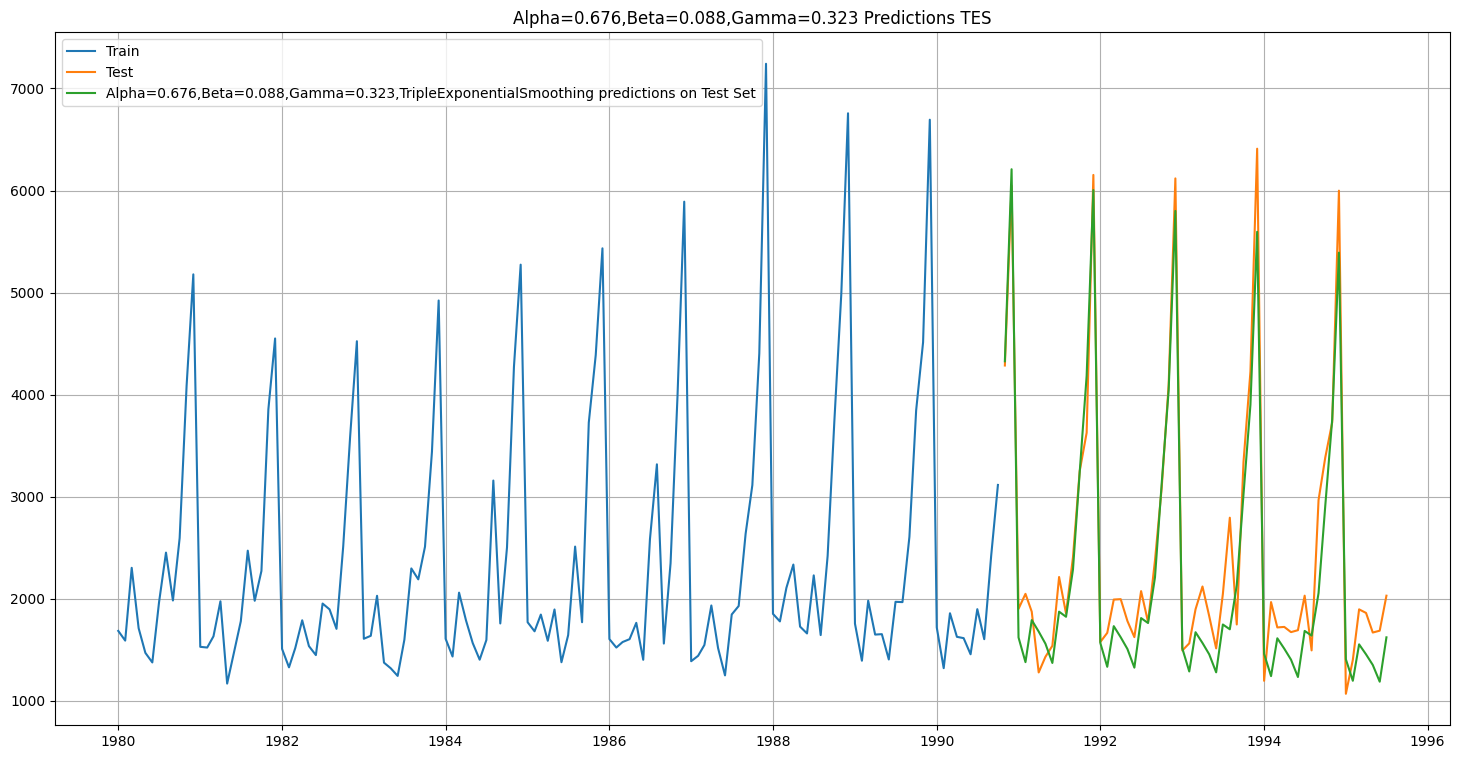

In [91]:
plt.figure(figsize=(18,9))
plt.plot(TES_train['Sparkling'], label='Train')
plt.plot(TES_test['Sparkling'], label='Test')

plt.plot(TES_test['auto_predict'], label='Alpha=0.676,Beta=0.088,Gamma=0.323,TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid()
plt.title('Alpha=0.676,Beta=0.088,Gamma=0.323 Predictions TES');

# **Check for stationarity**

In [92]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean() #determining the rolling mean
    rolstd = timeseries.rolling(window=7).std()   #determining the rolling standard deviation

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

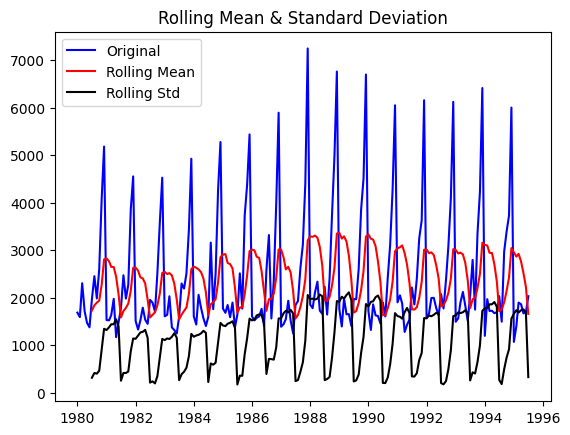

Results of Dickey-Fuller Test:
Test Statistic                  -1.360497
p-value                          0.601061
#Lags Used                      11.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64 



In [93]:
test_stationarity(df['Sparkling'])

We see that at 5% significant level the Time Series is non-stationary.

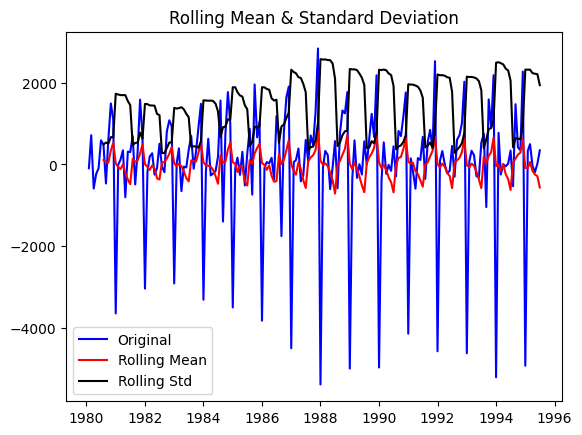

Results of Dickey-Fuller Test:
Test Statistic                 -45.050301
p-value                          0.000000
#Lags Used                      10.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64 



In [94]:
test_stationarity(df['Sparkling'].diff().dropna())

At  α  = 0.05 the Time Series is indeed stationary.

# **Model Building - Stationary Data**

### Plot the Autocorrelation and Partial Autocorrelation function plots on the whole data.

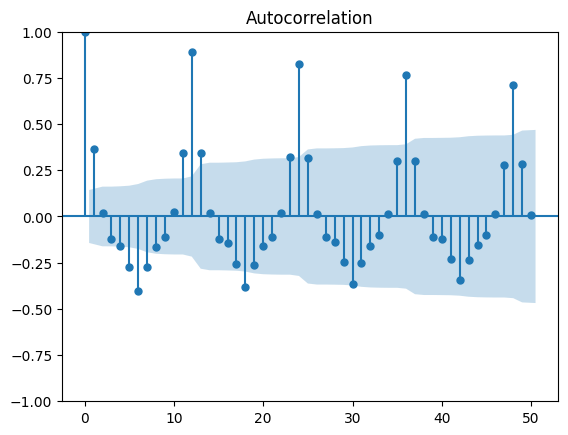

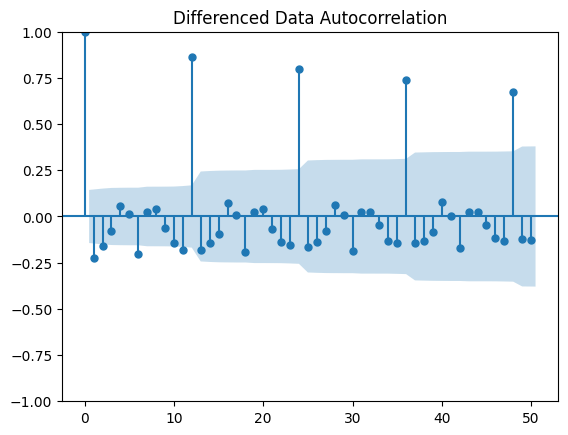

In [95]:
plot_acf(df['Sparkling'],lags=50)
plot_acf(df['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plt.show()

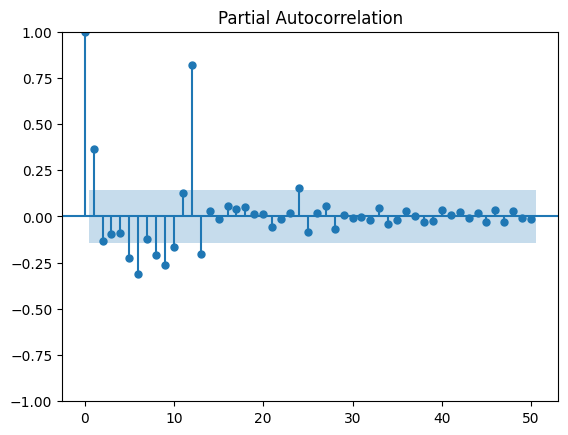

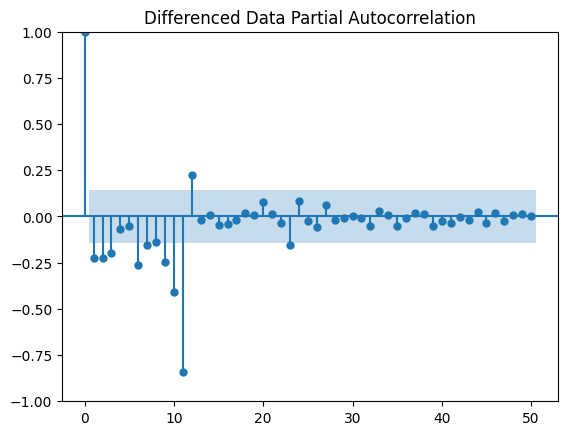

In [96]:
plot_pacf(df['Sparkling'],lags=50)
plot_pacf(df['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Partial Autocorrelation')
plt.show()

### Auto ARIMA Model

In [97]:
auto_train = train.copy()
auto_test = test.copy()

In [98]:
auto_ARIMA_model = auto_arima(auto_train['Sparkling'],
                              seasonal=False,
                              stepwise=True,
                              trace=True)
print(auto_ARIMA_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.88 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2422.783, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2244.390, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2331.596, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2244.916, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2242.972, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2291.309, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2206.535, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2205.446, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2228.475, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2206.008, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2207.502, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2207.4

In [99]:
## Prediction on the test data

In [100]:
predicted_auto_ARIMA = auto_ARIMA_model.predict(n_periods=len(auto_test))

In [101]:
auto_test['auto_arima_forecast']=predicted_auto_ARIMA

In [102]:
##Test Data

In [103]:
auto_ARIMA_rmse_test = mean_squared_error(auto_test['Sparkling'],predicted_auto_ARIMA,squared=False)
print("For auto_ARIMA forecast on the Test Data,  RMSE is %3.2f" %(auto_ARIMA_rmse_test))

For auto_ARIMA forecast on the Test Data,  RMSE is 1374.66


In [104]:
resultsDf_8 = pd.DataFrame({'Test RMSE': [auto_ARIMA_rmse_test]}
                           ,index=['AutoARIMA'])

resultsDf = pd.concat([resultsDf, resultsDf_8])
resultsDf

Test RMSE
RegressionOnTime                                    1391.708631
SimpleAverage                                       1368.774051
2pointTrailingMovingAverage                          811.178937
4pointTrailingMovingAverage                         1184.213295
6pointTrailingMovingAverage                         1337.200524
9pointTrailingMovingAverage                         1422.653281
Alpha=0.03,SimpleExponentialSmoothing               1362.428949
Alpha=0.4,SimpleExponentialSmoothing                1363.037803
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing       1597.853999
Alpha=0.0757,Beta=0.0648,Gamma=0.3765,TripleExp...   381.657232
Alpha=0.7,Beta=0.4,Gamma=0.3,TripleExponentialS...   422.908833
AutoARIMA                                           1374.664628

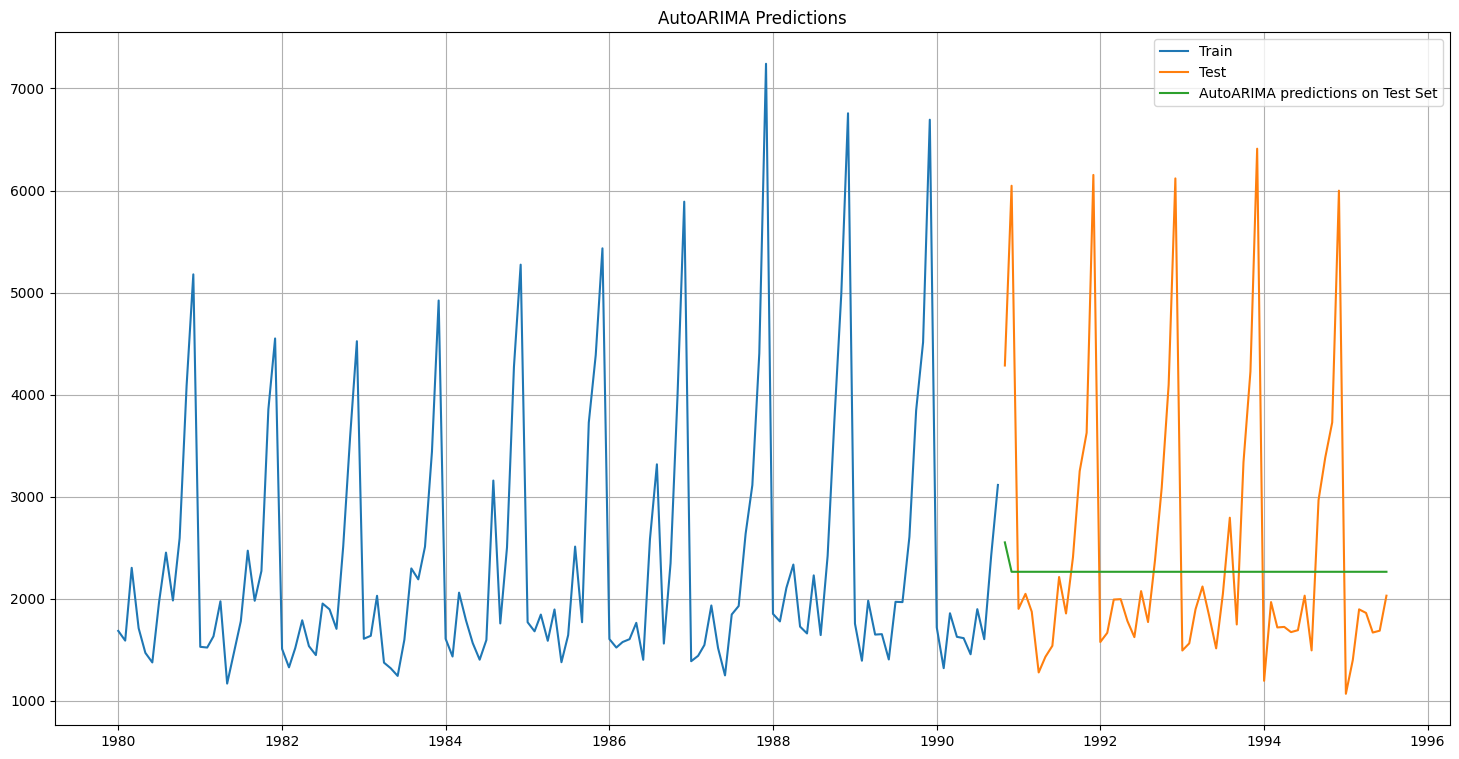

In [105]:
plt.figure(figsize=(18,9))
plt.plot(auto_train['Sparkling'], label='Train')
plt.plot(auto_test['Sparkling'], label='Test')

plt.plot(auto_test['auto_arima_forecast'], label='AutoARIMA predictions on Test Set')


plt.legend(loc='best')
plt.grid()
plt.title('AutoARIMA Predictions');

### ARIMA model

In [106]:
arima_train = train.copy()
arima_test = test.copy()

In [107]:
import itertools

# Define AR, I, MA ranges
p = q = range(0, 3)
d = range(1, 2)  # d typically set to 1 after first differencing

# Generate combinations of p, d, q
pdq = list(itertools.product(p, d, q))

print('Some parameter combinations for the Model...')
for i in range(1, len(pdq)):
    print('Model: {}'.format(pdq[i]))


Some parameter combinations for the Model...
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)


In [108]:
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

Empty DataFrame
Columns: [param, AIC]
Index: []

In [109]:
for param in pdq:
    try:
        # Fit the ARIMA model
        ARIMA_model = ARIMA(arima_train['Sparkling'], order=param).fit()

        # Print the AIC value for the current parameter combination
        print('ARIMA{} - AIC:{}'.format(param, ARIMA_model.aic))

        # Append the parameter combination and its corresponding AIC to the DataFrame
        new_row = pd.DataFrame({'param': [param], 'AIC': [ARIMA_model.aic]})
        ARIMA_AIC = pd.concat([ARIMA_AIC, new_row], ignore_index=True)
    except Exception as e:
        print(f"ARIMA{param} - Exception: {e}")

ARIMA(0, 1, 0) - AIC:2232.719438106631
ARIMA(0, 1, 1) - AIC:2217.9392170978817
ARIMA(0, 1, 2) - AIC:2194.0343613616114
ARIMA(1, 1, 0) - AIC:2231.137663012458
ARIMA(1, 1, 1) - AIC:2196.050086014342
ARIMA(1, 1, 2) - AIC:2194.9596533952517
ARIMA(2, 1, 0) - AIC:2223.899470277437
ARIMA(2, 1, 1) - AIC:2193.9749624390806
ARIMA(2, 1, 2) - AIC:2178.109741967432


In [110]:

ARIMA_AIC.sort_values(by='AIC',ascending=True)

param          AIC
8  (2, 1, 2)  2178.109742
7  (2, 1, 1)  2193.974962
2  (0, 1, 2)  2194.034361
5  (1, 1, 2)  2194.959653
4  (1, 1, 1)  2196.050086
1  (0, 1, 1)  2217.939217
6  (2, 1, 0)  2223.899470
3  (1, 1, 0)  2231.137663
0  (0, 1, 0)  2232.719438

In [111]:
## ARIMA(2,1,2) has the lowest AIC
mod = ARIMA(arima_train['Sparkling'], order=(2,1,2))

results_Arima = mod.fit()

print(results_Arima.summary())

                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  130
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1084.055
Date:                Sun, 08 Dec 2024   AIC                           2178.110
Time:                        17:21:06   BIC                           2192.409
Sample:                    01-01-1980   HQIC                          2183.920
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3020      0.046     28.556      0.000       1.213       1.391
ar.L2         -0.5360      0.079     -6.744      0.000      -0.692      -0.380
ma.L1         -1.9914      0.110    -18.144      0.0

In [112]:
## Prediction on the test data

In [113]:
predicted_ARIMA = results_Arima.forecast(steps=len(arima_test))

In [114]:
arima_test['ARIMA_forecast']=predicted_ARIMA

In [115]:
##Test Data

In [116]:
ARIMA_rmse_test = mean_squared_error(arima_test['Sparkling'],predicted_ARIMA,squared=False)
print("For ARIMA forecast on the Test Data,  RMSE is %3.2f" %(ARIMA_rmse_test))

For ARIMA forecast on the Test Data,  RMSE is 1325.17


In [117]:
resultsDf_9 = pd.DataFrame({'Test RMSE': [ARIMA_rmse_test]}
                           ,index=['ARIMA'])

resultsDf = pd.concat([resultsDf, resultsDf_9])
resultsDf

Test RMSE
RegressionOnTime                                    1391.708631
SimpleAverage                                       1368.774051
2pointTrailingMovingAverage                          811.178937
4pointTrailingMovingAverage                         1184.213295
6pointTrailingMovingAverage                         1337.200524
9pointTrailingMovingAverage                         1422.653281
Alpha=0.03,SimpleExponentialSmoothing               1362.428949
Alpha=0.4,SimpleExponentialSmoothing                1363.037803
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing       1597.853999
Alpha=0.0757,Beta=0.0648,Gamma=0.3765,TripleExp...   381.657232
Alpha=0.7,Beta=0.4,Gamma=0.3,TripleExponentialS...   422.908833
AutoARIMA                                           1374.664628
ARIMA                                               1325.166743

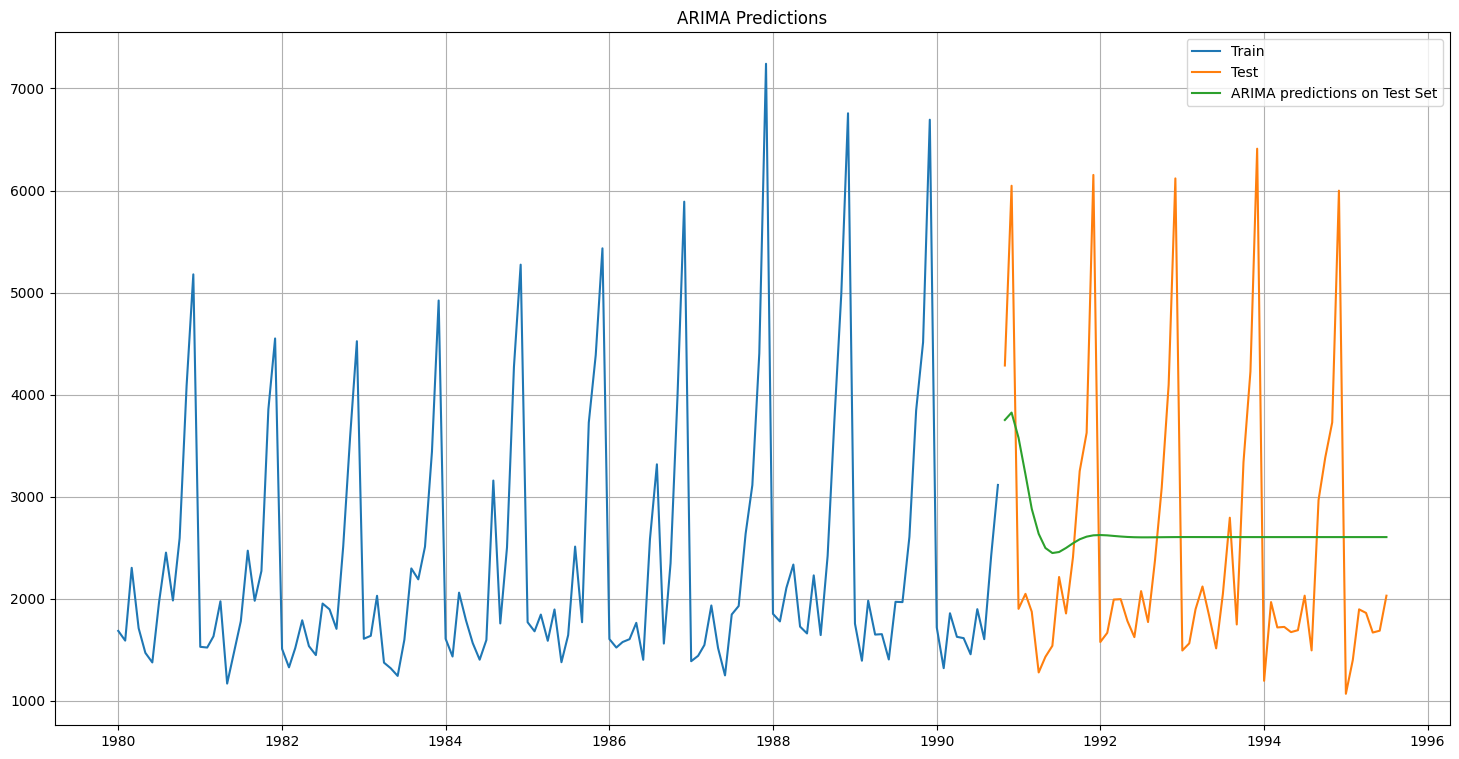

In [118]:
plt.figure(figsize=(18,9))
plt.plot(arima_train['Sparkling'], label='Train')
plt.plot(arima_test['Sparkling'], label='Test')
plt.plot(arima_test['ARIMA_forecast'], label='ARIMA predictions on Test Set')


plt.legend(loc='best')
plt.grid()
plt.title('ARIMA Predictions');

## Auto SARIMA

In [119]:
auto_train = train.copy()
auto_test = test.copy()


In [120]:
auto_SARIMA_model = auto_arima(auto_train['Sparkling'],
                                seasonal=True,
                                m=12,
                                stepwise=True,
                                trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1753.900, Time=5.72 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1772.046, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1754.854, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1747.640, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1770.140, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1767.822, Time=0.09 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1749.538, Time=1.23 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1749.497, Time=1.28 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1754.421, Time=0.66 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=1751.465, Time=3.06 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1749.150, Time=0.61 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1748.189, Time=2.08 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=1749.492, Time=2.45 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1747.889, Time=2.79 sec
 ARIMA(1,0,2)(0,1,1

In [121]:
print(auto_SARIMA_model.summary())

# Predict on the test data
predicted_auto_SARIMA = auto_SARIMA_model.predict(n_periods=len(auto_test))

# Add the predictions to the test set
auto_test['auto_sarima_forecast'] = predicted_auto_SARIMA

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  130
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -869.820
Date:                            Sun, 08 Dec 2024   AIC                           1747.640
Time:                                    17:21:33   BIC                           1758.723
Sample:                                01-01-1980   HQIC                          1752.140
                                     - 10-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     42.8247     26.717      1.603      0.109      -9.540      95.190
ma.L1          0.1764      0.090   

In [122]:
# Calculate RMSE for the SARIMA model
auto_SARIMA_rmse_test = mean_squared_error(auto_test['Sparkling'], predicted_auto_SARIMA, squared=False)
print("For auto SARIMA forecast on the Test Data, RMSE is %3.2f" % (auto_SARIMA_rmse_test))

For auto SARIMA forecast on the Test Data, RMSE is 426.96


In [123]:
resultsDf_10 = pd.DataFrame({'Test RMSE': [auto_SARIMA_rmse_test]},
                           index=['Auto SARIMA'])

# Concatenate with existing results
resultsDf = pd.concat([resultsDf, resultsDf_10])

In [124]:
resultsDf

Test RMSE
RegressionOnTime                                    1391.708631
SimpleAverage                                       1368.774051
2pointTrailingMovingAverage                          811.178937
4pointTrailingMovingAverage                         1184.213295
6pointTrailingMovingAverage                         1337.200524
9pointTrailingMovingAverage                         1422.653281
Alpha=0.03,SimpleExponentialSmoothing               1362.428949
Alpha=0.4,SimpleExponentialSmoothing                1363.037803
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing       1597.853999
Alpha=0.0757,Beta=0.0648,Gamma=0.3765,TripleExp...   381.657232
Alpha=0.7,Beta=0.4,Gamma=0.3,TripleExponentialS...   422.908833
AutoARIMA                                           1374.664628
ARIMA                                               1325.166743
Auto SARIMA                                          426.961615

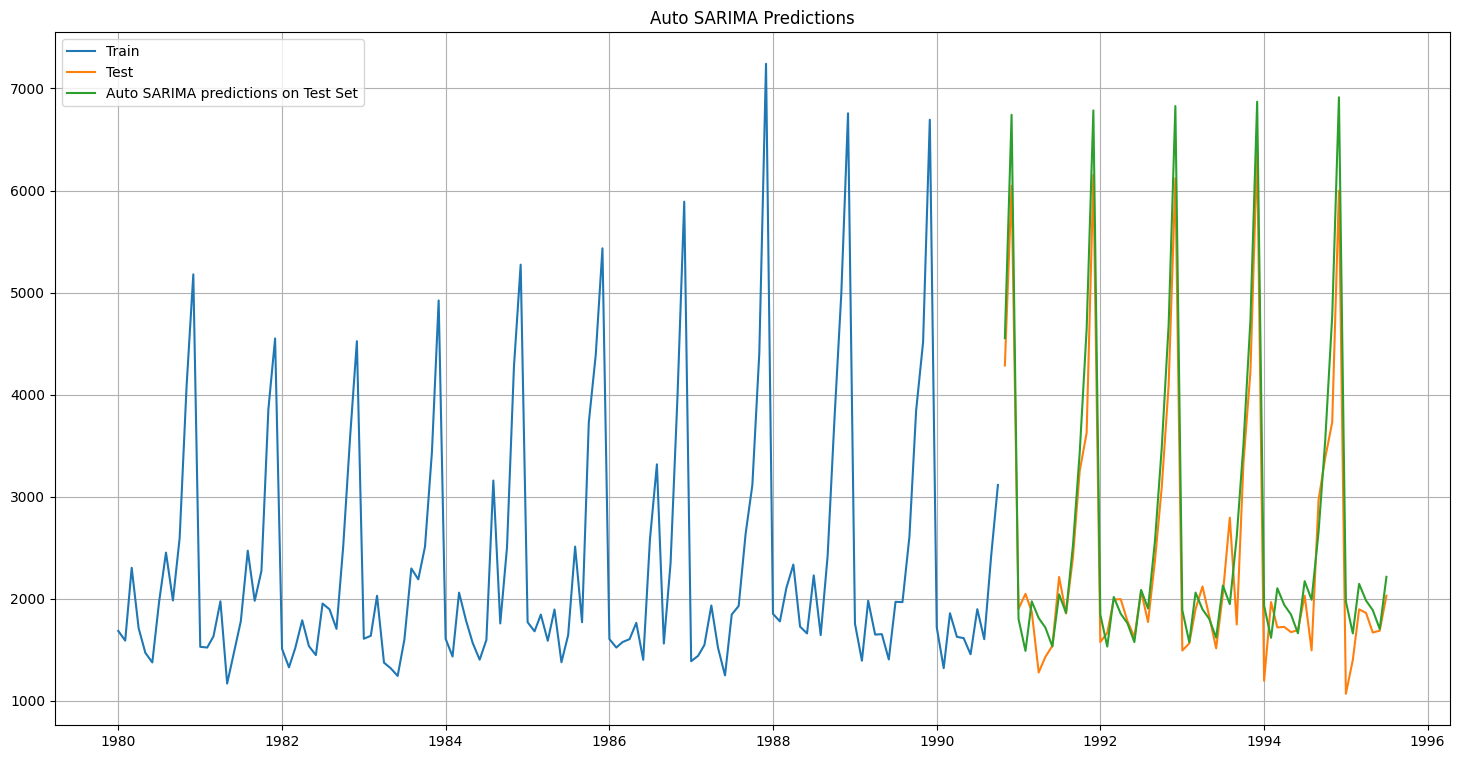

In [125]:
plt.figure(figsize=(18,9))
plt.plot(auto_train['Sparkling'], label='Train')
plt.plot(auto_test['Sparkling'], label='Test')
plt.plot(auto_test['auto_sarima_forecast'], label='Auto SARIMA predictions on Test Set')


plt.legend(loc='best')
plt.grid()
plt.title('Auto SARIMA Predictions');

###SARIMA model.

In [126]:
sarima_train = train.copy()
sarima_test = test.copy()

In [127]:
p = q = range(0, 3)
d = range(1, 2)  # Typically set to 1 for first differencing
seasonal_p = seasonal_q = range(0, 3)
seasonal_d = range(1, 2)
s = 12

In [128]:
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(seasonal_p, seasonal_d, seasonal_q, [s]))

# AIC DataFrame to store results
SARIMA_AIC = pd.DataFrame(columns=['param', 'seasonal_param', 'AIC'])

In [129]:
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            # Fit SARIMA model
            SARIMA_model = SARIMAX(sarima_train['Sparkling'], order=param, seasonal_order=seasonal_param).fit()

            # Print the AIC value for the current parameter combination
            print('SARIMA{}x{} - AIC:{}'.format(param, seasonal_param, SARIMA_model.aic))

            # Append the parameter combination and its corresponding AIC to the DataFrame
            new_row = pd.DataFrame({'param': [param], 'seasonal_param': [seasonal_param], 'AIC': [SARIMA_model.aic]})
            SARIMA_AIC = pd.concat([SARIMA_AIC, new_row], ignore_index=True)

        except Exception as e:
            print(f"SARIMA{param}x{seasonal_param} - Exception: {e}")

SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:1807.1291349856785
SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:1791.6380536309396
SARIMA(0, 1, 0)x(0, 1, 2, 12) - AIC:1793.076977666234
SARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:1796.7396247830463
SARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:1793.1894534902149
SARIMA(0, 1, 0)x(1, 1, 2, 12) - AIC:1794.8659946943967
SARIMA(0, 1, 0)x(2, 1, 0, 12) - AIC:1793.1882231211266
SARIMA(0, 1, 0)x(2, 1, 1, 12) - AIC:1794.7965746697014
SARIMA(0, 1, 0)x(2, 1, 2, 12) - AIC:1796.7687963506824
SARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:1766.0026139364572
SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:1744.2258019762985
SARIMA(0, 1, 1)x(0, 1, 2, 12) - AIC:1748.1865269662676
SARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:1749.4764921485255
SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:1748.1848405419169
SARIMA(0, 1, 1)x(1, 1, 2, 12) - AIC:1746.284447153876
SARIMA(0, 1, 1)x(2, 1, 0, 12) - AIC:1747.34488675243
SARIMA(0, 1, 1)x(2, 1, 1, 12) - AIC:1747.4106751577424
SARIMA(0, 1, 1)x(2, 1, 2, 12) - AIC:1748.0655814181848
SARIMA(0, 1, 2

In [130]:
SARIMA_AIC = SARIMA_AIC.sort_values(by='AIC', ascending=True)
print(SARIMA_AIC)

        param seasonal_param          AIC
19  (0, 1, 2)  (0, 1, 1, 12)  1742.192732
37  (1, 1, 1)  (0, 1, 1, 12)  1742.361349
46  (1, 1, 2)  (0, 1, 1, 12)  1743.406742
24  (0, 1, 2)  (2, 1, 0, 12)  1743.552793
42  (1, 1, 1)  (2, 1, 0, 12)  1743.756196
..        ...            ...          ...
5   (0, 1, 0)  (1, 1, 2, 12)  1794.865995
27  (1, 1, 0)  (0, 1, 0, 12)  1796.684824
3   (0, 1, 0)  (1, 1, 0, 12)  1796.739625
8   (0, 1, 0)  (2, 1, 2, 12)  1796.768796
0   (0, 1, 0)  (0, 1, 0, 12)  1807.129135

[81 rows x 3 columns]


In [131]:
best_param = SARIMA_AIC.iloc[0]['param']
best_seasonal_param = SARIMA_AIC.iloc[0]['seasonal_param']

In [132]:
model = SARIMAX(sarima_train['Sparkling'], order=best_param, seasonal_order=best_seasonal_param).fit()

In [133]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            Sparkling   No. Observations:                  130
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -867.096
Date:                              Sun, 08 Dec 2024   AIC                           1742.193
Time:                                      17:24:49   BIC                           1753.241
Sample:                                  01-01-1980   HQIC                          1746.678
                                       - 10-01-1990                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7754      2.413     -0.321      0.748      -5.504       3.953
ma.L2         -0.22

In [134]:


# Forecasting on the test set
predicted_SARIMA = model.forecast(steps=len(sarima_test))

# Add forecast to the test set
sarima_test['SARIMA_forecast'] = predicted_SARIMA

In [135]:
SARIMA_rmse_test = mean_squared_error(sarima_test['Sparkling'], predicted_SARIMA, squared=False)
print("For SARIMA forecast on the Test Data, RMSE is %3.2f" % (SARIMA_rmse_test))

For SARIMA forecast on the Test Data, RMSE is 412.82


In [136]:
resultsDf_11 = pd.DataFrame({'Test RMSE': [SARIMA_rmse_test]}, index=['SARIMA'])
resultsDf = pd.concat([resultsDf, resultsDf_11])

In [137]:
resultsDf

Test RMSE
RegressionOnTime                                    1391.708631
SimpleAverage                                       1368.774051
2pointTrailingMovingAverage                          811.178937
4pointTrailingMovingAverage                         1184.213295
6pointTrailingMovingAverage                         1337.200524
9pointTrailingMovingAverage                         1422.653281
Alpha=0.03,SimpleExponentialSmoothing               1362.428949
Alpha=0.4,SimpleExponentialSmoothing                1363.037803
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing       1597.853999
Alpha=0.0757,Beta=0.0648,Gamma=0.3765,TripleExp...   381.657232
Alpha=0.7,Beta=0.4,Gamma=0.3,TripleExponentialS...   422.908833
AutoARIMA                                           1374.664628
ARIMA                                               1325.166743
Auto SARIMA                                          426.961615
SARIMA                                               412.824322

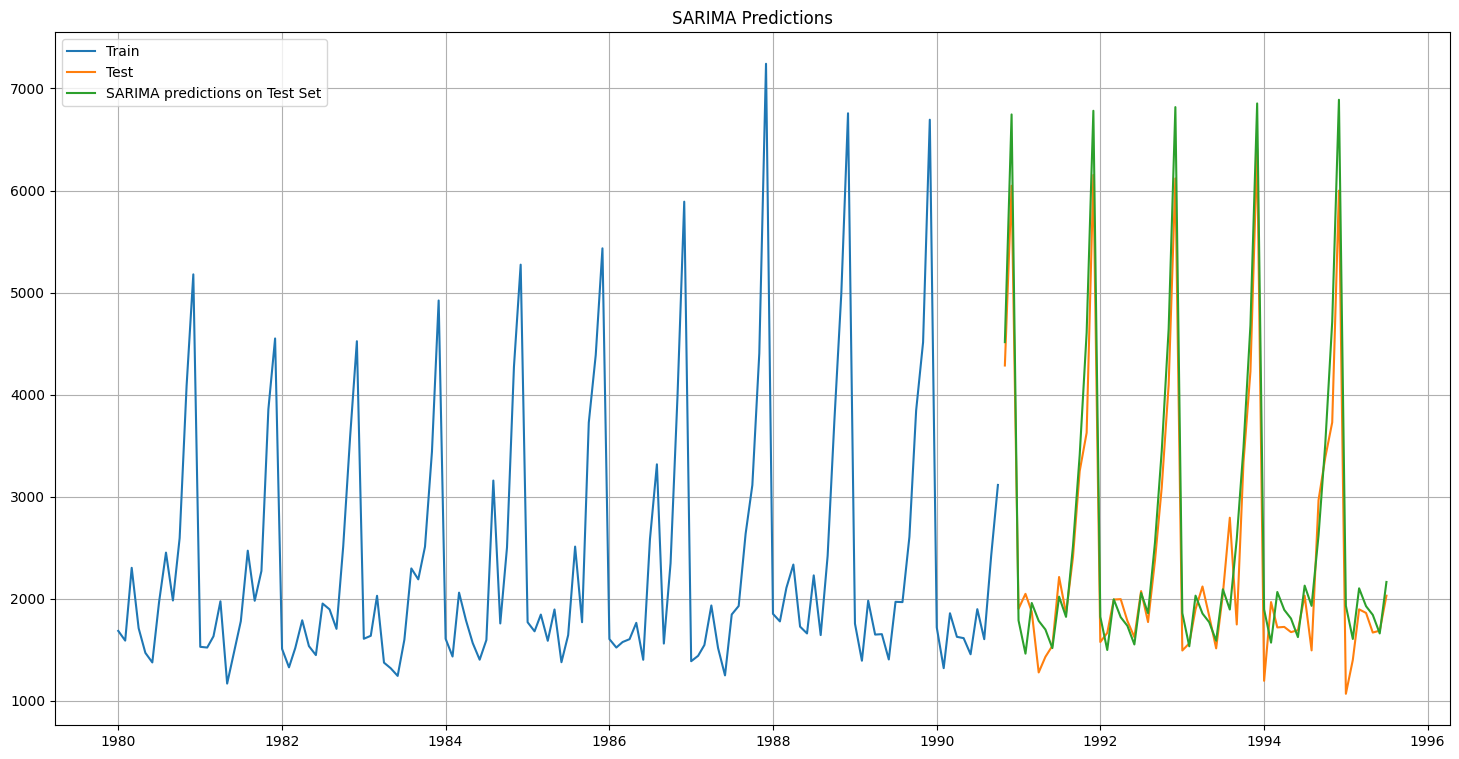

In [138]:


# Plot the results
plt.figure(figsize=(18, 9))
plt.plot(sarima_train['Sparkling'], label='Train')
plt.plot(sarima_test['Sparkling'], label='Test')
plt.plot(sarima_test['SARIMA_forecast'], label='SARIMA predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('SARIMA Predictions');
plt.show()

#**Compare the performance of the models**

In [139]:
resultsDf.sort_values(by='Test RMSE')

Test RMSE
Alpha=0.0757,Beta=0.0648,Gamma=0.3765,TripleExp...   381.657232
SARIMA                                               412.824322
Alpha=0.7,Beta=0.4,Gamma=0.3,TripleExponentialS...   422.908833
Auto SARIMA                                          426.961615
2pointTrailingMovingAverage                          811.178937
4pointTrailingMovingAverage                         1184.213295
ARIMA                                               1325.166743
6pointTrailingMovingAverage                         1337.200524
Alpha=0.03,SimpleExponentialSmoothing               1362.428949
Alpha=0.4,SimpleExponentialSmoothing                1363.037803
SimpleAverage                                       1368.774051
AutoARIMA                                           1374.664628
RegressionOnTime                                    1391.708631
9pointTrailingMovingAverage                         1422.653281
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing       1597.853999

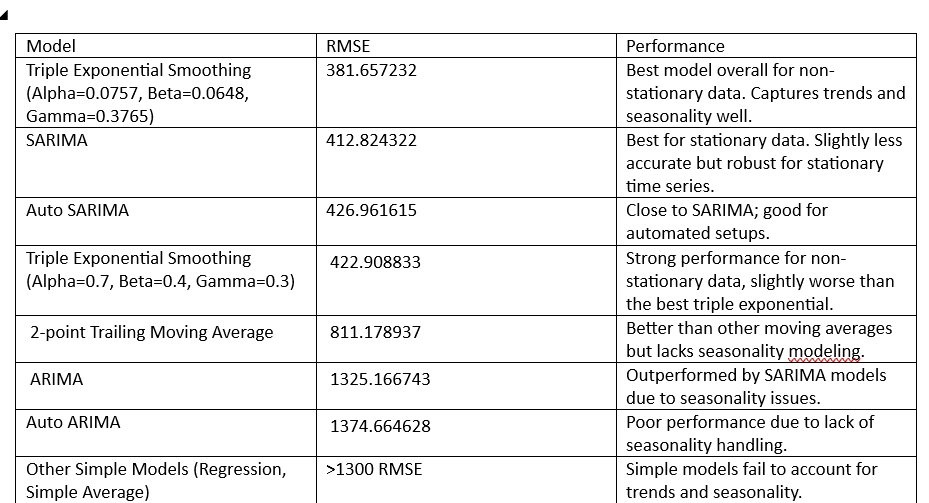

##Best Model based on RMSE - Triple Exponential Smoothing

In [140]:
model_TES = ExponentialSmoothing(df['Sparkling'],trend='additive',seasonal='multiplicative')

In [141]:
model_TES_autofit = model_TES.fit()

In [142]:
model_TES_autofit.params

{'smoothing_level': 0.0757144421744643,
 'smoothing_trend': 0.06489807996645991,
 'smoothing_seasonal': 0.2738624037435794,
 'damping_trend': nan,
 'initial_level': 2356.541720532422,
 'initial_trend': -9.183997191040547,
 'initial_seasons': array([0.72446443, 0.69349262, 0.88728257, 0.80815169, 0.67044416,
        0.65810674, 0.88098601, 1.1318567 , 0.92255174, 1.25006069,
        1.8919773 , 2.45706543]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [143]:
df.reset_index(inplace=True)

In [144]:
df

Time_Stamp  Sparkling
0   1980-01-01       1686
1   1980-02-01       1591
2   1980-03-01       2304
3   1980-04-01       1712
4   1980-05-01       1471
..         ...        ...
182 1995-03-01       1897
183 1995-04-01       1862
184 1995-05-01       1670
185 1995-06-01       1688
186 1995-07-01       2031

[187 rows x 2 columns]

In [145]:
forecast = model_TES_autofit.forecast(steps=12)


In [146]:
forecast

1995-08-01    1931.735037
1995-09-01    2351.151614
1995-10-01    3178.421194
1995-11-01    3916.154786
1995-12-01    5982.160998
1996-01-01    1356.227449
1996-02-01    1597.707941
1996-03-01    1828.341267
1996-04-01    1788.957424
1996-05-01    1639.717051
1996-06-01    1553.973426
1996-07-01    1962.375513
Freq: MS, dtype: float64

In [147]:
forecast_df = pd.DataFrame(forecast)

In [148]:
forecast_df.reset_index(inplace=True)

In [149]:
forecast_df.columns=['Time_Stamp','Prediction']

In [150]:
final_df = pd.merge(df, forecast_df, on='Time_Stamp', how='outer').sort_values('Time_Stamp')


In [151]:
final_df.index=final_df['Time_Stamp']

In [152]:
final_df.drop(columns=['Time_Stamp'],inplace=True, axis=1)

In [153]:
final_df

Sparkling   Prediction
Time_Stamp                        
1980-01-01     1686.0          NaN
1980-02-01     1591.0          NaN
1980-03-01     2304.0          NaN
1980-04-01     1712.0          NaN
1980-05-01     1471.0          NaN
...               ...          ...
1996-03-01        NaN  1828.341267
1996-04-01        NaN  1788.957424
1996-05-01        NaN  1639.717051
1996-06-01        NaN  1553.973426
1996-07-01        NaN  1962.375513

[199 rows x 2 columns]

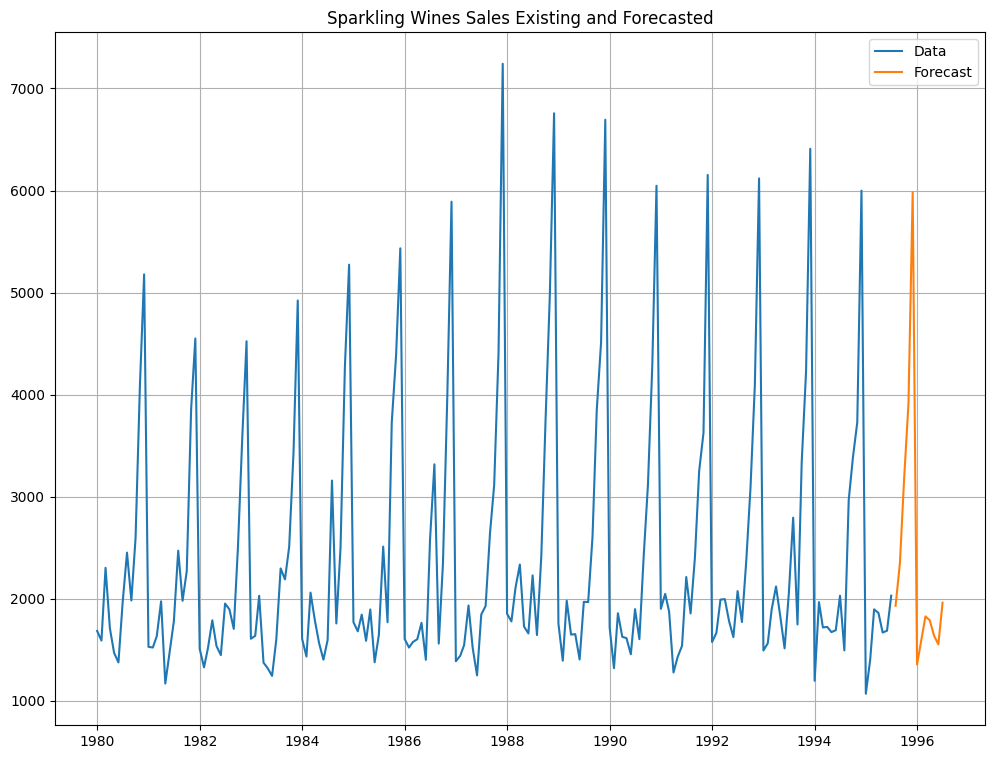

In [154]:
plt.figure(figsize=(12, 9))
plt.plot(final_df['Sparkling'], label='Data')
plt.plot(final_df['Prediction'], label='Forecast')
plt.title('Sparkling Wines Sales Existing and Forecasted')
plt.legend(loc='best')
plt.grid()
plt.show()

#**Actionable Insights & Recommendations**

Benefits using the Holt’s Winter Model

*	Captures Seasonality and Trends Effectively: The triple exponential smoothing model incorporates both seasonal patterns and long-term trends, making it highly effective in forecasting wine sales with predictable peaks and dips. This allows the business to align marketing, inventory, and operations with demand fluctuations.
*	Improved Forecast Accuracy: With the lowest RMSE compared to other models, this model minimizes forecast errors, ensuring more reliable and precise predictions. Accurate forecasting helps in optimizing supply chain management and reducing inventory costs.
*	Data-Driven Decision-Making: By accurately predicting high-demand periods (e.g., holiday season) and low-demand months, ABC Estate Wines can make proactive business decisions, such as launching seasonal promotions, managing production schedules, and adjusting staffing requirements.
*	Resource Optimization: The model’s ability to predict sales dips during the early months (January–February) allows for better resource allocation, such as reducing production during low-demand periods and focusing efforts on other strategic activities.


Insights

* The forecast highlights significant seasonality in wine sales, with peaks around the holiday season (November–December) and dips in the early months of the year (January–February).
* The early months of the year show a considerable decline in sales, which can impact overall revenue.
* Seasonal demand may also indicate varying levels of customer engagement throughout the year.
* The triple exponential smoothing model achieved a lower RMSE, indicating it captures seasonality and trends effectively. However, further improvements are possible.
* Trends may be influenced by external factors like climate, market preferences, or economic conditions.

##Recommendations

* Focus on targeted marketing campaigns and promotions during the holiday season to capitalize on increased demand.
* Ensure adequate inventory levels to meet the peak season demand without shortages or overstocking.
* Introduce attractive discounts or bundle offers in January and February to stimulate sales.
*  Launch a rewards program to retain high-value customers and encourage repeat purchases.

# **Rose**

# **Loading the dataset**

In [155]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [156]:
#Read the data
data = pd.read_csv('/content/drive/MyDrive/PGPDSA/TSF/Rose.csv')
#returns first 5 rows
data.head(5)

YearMonth   Rose
0   1980-01  112.0
1   1980-02  118.0
2   1980-03  129.0
3   1980-04   99.0
4   1980-05  116.0

## Creating a copy of original data

In [157]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

In [158]:
df["YearMonth"].max()

'1995-07'

In [159]:
df["YearMonth"].min()

'1980-01'

# **Data Overview**

###1. Structure of Data

In [160]:
df.shape

(187, 2)

###2. Type of Data

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   YearMonth  187 non-null    object 
 1   Rose       185 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB


###3. Missing values treatment

In [162]:
df.isnull().sum()

YearMonth    0
Rose         2
dtype: int64

In [163]:
df[df.isnull().any(axis=1)]

YearMonth  Rose
174   1994-07   NaN
175   1994-08   NaN

In [164]:
df['Rose'] = df['Rose'].interpolate(method='linear')

In [165]:
missing_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='M').difference(df.index)
print(f"Missing timestamps: {missing_dates}")

Missing timestamps: DatetimeIndex([], dtype='datetime64[ns]', freq='ME')


###4. Data Duplicates

In [166]:
df.duplicated().sum()

0

###5. Statistical Summary

In [167]:
df.describe().T

count       mean        std   min   25%   50%    75%    max
Rose  187.0  89.914439  39.238325  28.0  62.5  85.0  111.0  267.0

In [168]:
df['Time_Stamp'] = pd.to_datetime(df['YearMonth'])

In [169]:
df = df.set_index('Time_Stamp')
df.drop(['YearMonth'], axis=1, inplace=True)
df.head()

Rose
Time_Stamp       
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0

In [170]:
df

Rose
Time_Stamp       
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0
...           ...
1995-03-01   45.0
1995-04-01   52.0
1995-05-01   28.0
1995-06-01   40.0
1995-07-01   62.0

[187 rows x 1 columns]

##Insights

* The standard deviation (39.24) is approximately 43.6% of the mean (89.91), indicating moderate variability in sales.

* The mean (89.91) is slightly higher than the median (85.0), suggesting a slight positive skew in the data. This indicates the presence of some higher sales values, though the skewness is not extreme.

* The 75th percentile (111.0) and maximum value (267.0) highlight periods of elevated sales, which could reflect increased demand during certain times. These insights could help in planning targeted marketing strategies or promotions during similar periods.

# **Exploratory Data Analysis**

## Time series plot to understand the behavior

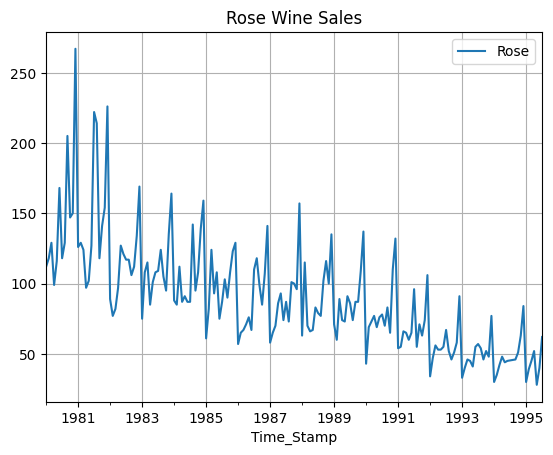

In [171]:
df.plot();
plt.grid()
plt.title('Rose Wine Sales')
plt.show()

There is trend with seasonality

##Sales across different years and within different months across years.

###Yearly Boxplot

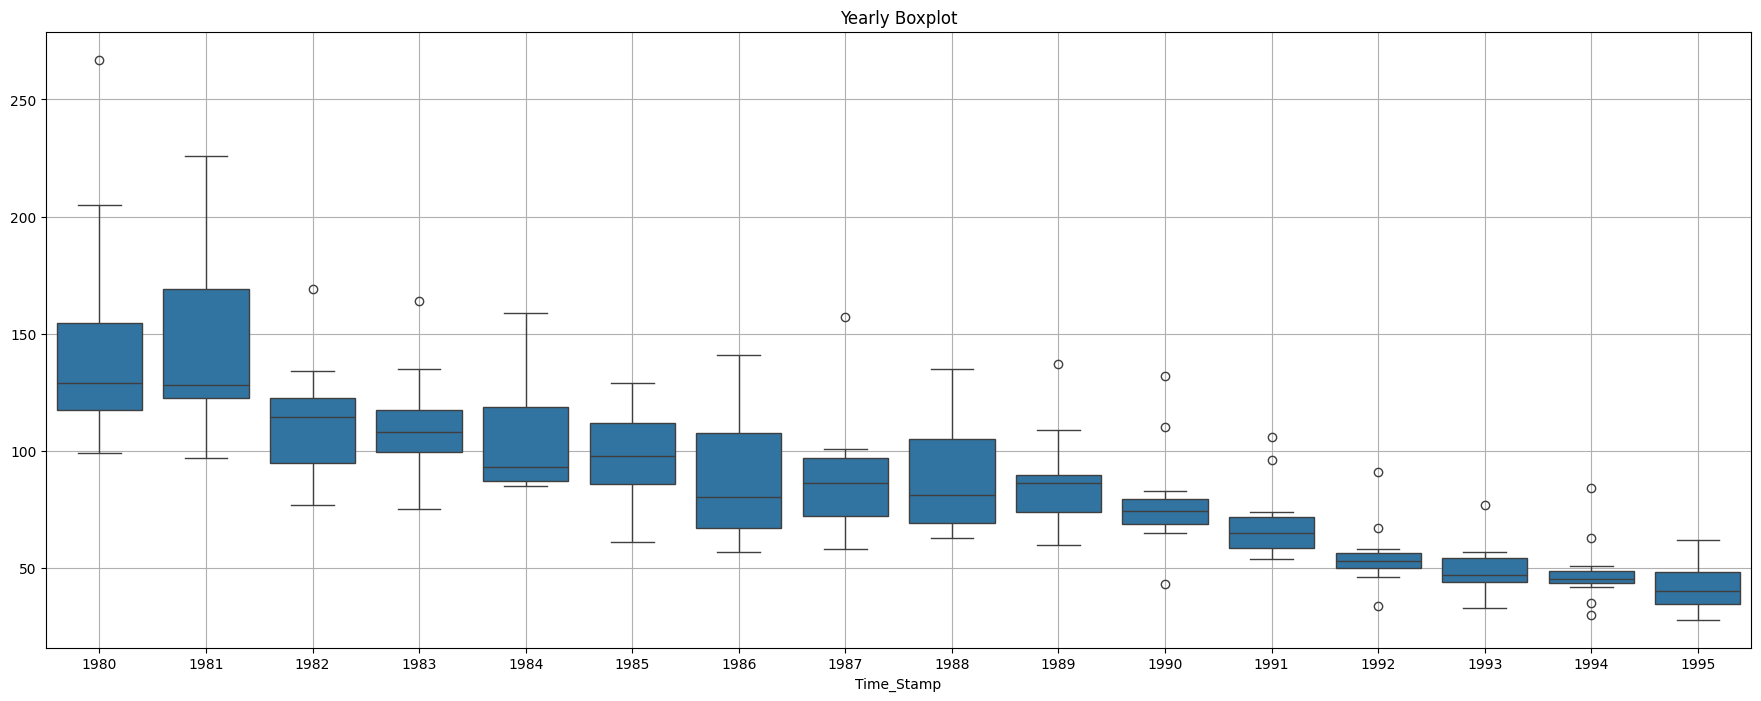

In [172]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df.index.year,y = df.values[:,0],ax=ax)
plt.grid()
plt.title('Yearly Boxplot')
plt.show()

### Monthly Boxplot

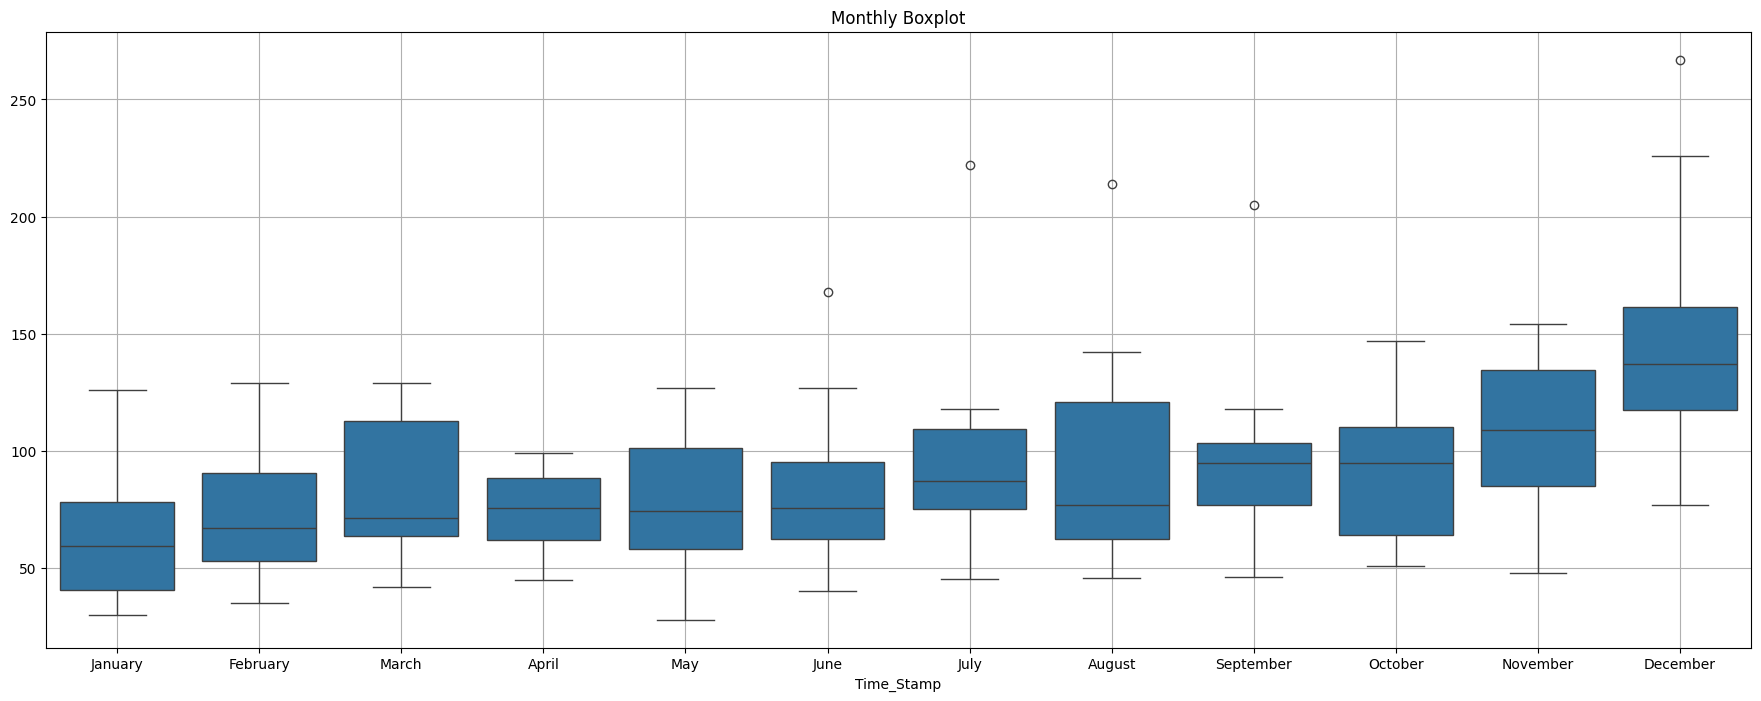

In [173]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df.index.month_name(),y = df.values[:,0],ax=ax)
plt.grid()
plt.title('Monthly Boxplot')
plt.show()

In [174]:
monthly_sales_across_years = pd.pivot_table(df, values = 'Rose', columns = df.index.month_name(), index = df.index.year)
monthly_sales_across_years

Time_Stamp  April      August  December  February  January        July   June  \
Time_Stamp                                                                      
1980         99.0  129.000000     267.0     118.0    112.0  118.000000  168.0   
1981         97.0  214.000000     226.0     129.0    126.0  222.000000  127.0   
1982         97.0  117.000000     169.0      77.0     89.0  117.000000  121.0   
1983         85.0  124.000000     164.0     108.0     75.0  109.000000  108.0   
1984         87.0  142.000000     159.0      85.0     88.0   87.000000   87.0   
1985         93.0  103.000000     129.0      82.0     61.0   87.000000   75.0   
1986         71.0  118.000000     141.0      65.0     57.0  110.000000   67.0   
1987         86.0   73.000000     157.0      65.0     58.0   87.000000   74.0   
1988         66.0   77.000000     135.0     115.0     63.0   79.000000   83.0   
1989         74.0   74.000000     137.0      60.0     71.0   86.000000   91.0   
1990         77.0   70.000000     132.0      69.0     43.0   78.000000   76.0   
1991         65.0   55.000000     106.0      55.0     54.0   96.000000   65.0   
1992         53.0   52.000000      91.0      47.0     34.0   67.000000   55.0   
1993         45.0   54.000000      77.0      40.0     33.0   57.000000   55.0   
1994         48.0   45.666667      84.0      35.0     30.0   45.333333   45.0   
1995         52.0         NaN       NaN      39.0     30.0   62.000000   40.0   

Time_Stamp  March    May  November  October  September  
Time_Stamp                                              
1980        129.0  116.0     150.0    147.0      205.0  
1981        124.0  102.0     154.0    141.0      118.0  
1982         82.0  127.0     134.0    112.0      106.0  
1983        115.0  101.0     135.0     95.0      105.0  
1984        112.0   91.0     139.0    108.0       95.0  
1985        124.0  108.0     123.0    108.0       90.0  
1986         67.0   76.0     107.0     85.0       99.0  
1987         70.0   93.0      96.0    100.0      101.0  
1988         70.0   67.0     100.0    116.0      102.0  
1989         89.0   73.0     109.0     87.0       87.0  
1990         73.0   69.0     110.0     65.0       83.0  
1991         66.0   60.0      74.0     63.0       71.0  
1992         56.0   53.0      58.0     51.0       46.0  
1993         46.0   41.0      48.0     52.0       46.0  
1994         42.0   44.0      63.0     51.0       46.0  
1995         45.0   28.0       NaN      NaN        NaN

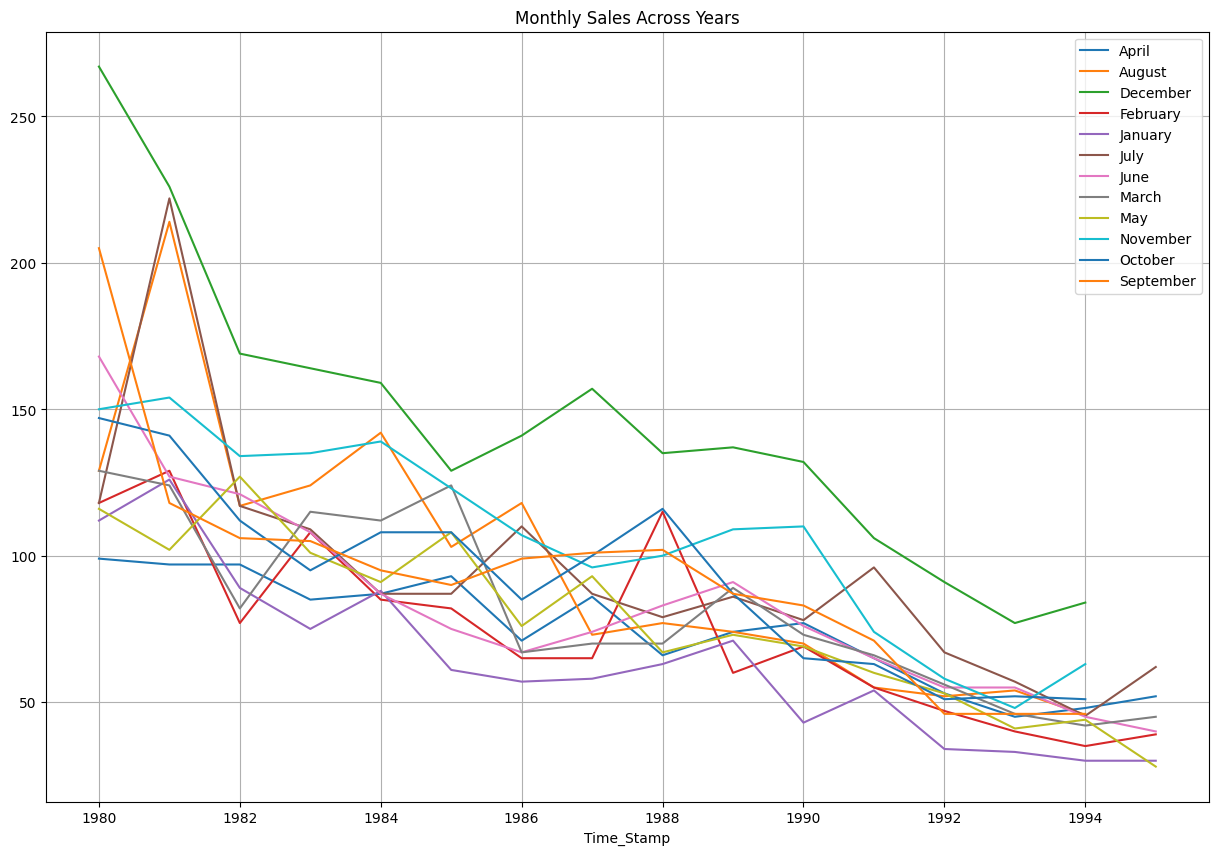

In [175]:
monthly_sales_across_years.plot(figsize=(15,10))
plt.grid()
plt.legend(loc='best')
plt.title('Monthly Sales Across Years')
plt.show()

## Insights



*   1980–1988: Sales show high variability, with peaks and troughs across months.
*   1989–1995: A steady decline is observed, especially in later years, indicating a potential reduction in demand for rose wine during this period.
*   December consistently has the highest sales values across the years, likely indicating seasonal demand during the holiday period. For example, sales in 1980 (267) and 1981 (226) are significantly higher than other months.
* February, January, and March also exhibit relatively higher sales compared to mid-year months, hinting at strong performance during winter and early spring.
* December sales drop from 106 (1991) to 84 (1994) and August sales fall sharply, from 55 (1991) to 45.67 (1994).



## Decompose the Time Series

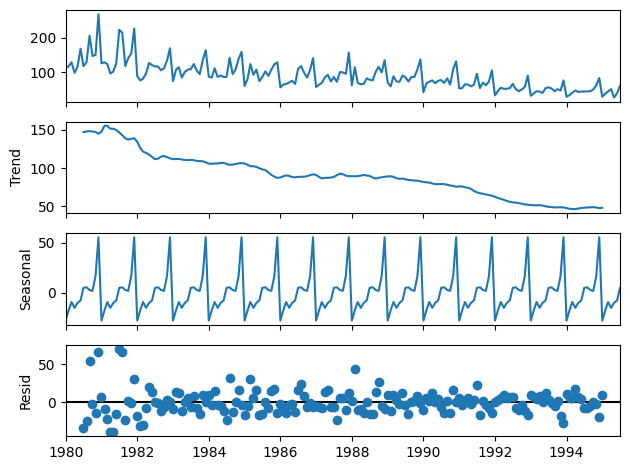

In [176]:
decomposition = seasonal_decompose(df,model='additive')
decomposition.plot();

In [177]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.round(2).head(12),'\n')
print('Seasonality','\n',seasonality.round(2).head(12),'\n')
print('Residual','\n',residual.round(2).head(12),'\n')

Trend 
 Time_Stamp
1980-01-01       NaN
1980-02-01       NaN
1980-03-01       NaN
1980-04-01       NaN
1980-05-01       NaN
1980-06-01       NaN
1980-07-01    147.08
1980-08-01    148.12
1980-09-01    148.37
1980-10-01    148.08
1980-11-01    147.42
1980-12-01    145.12
Name: trend, dtype: float64 

Seasonality 
 Time_Stamp
1980-01-01   -27.91
1980-02-01   -17.44
1980-03-01    -9.29
1980-04-01   -15.10
1980-05-01   -10.20
1980-06-01    -7.68
1980-07-01     4.90
1980-08-01     5.50
1980-09-01     2.77
1980-10-01     1.87
1980-11-01    16.85
1980-12-01    55.71
Name: seasonal, dtype: float64 

Residual 
 Time_Stamp
1980-01-01      NaN
1980-02-01      NaN
1980-03-01      NaN
1980-04-01      NaN
1980-05-01      NaN
1980-06-01      NaN
1980-07-01   -33.98
1980-08-01   -24.62
1980-09-01    53.85
1980-10-01    -2.96
1980-11-01   -14.26
1980-12-01    66.16
Name: resid, dtype: float64 



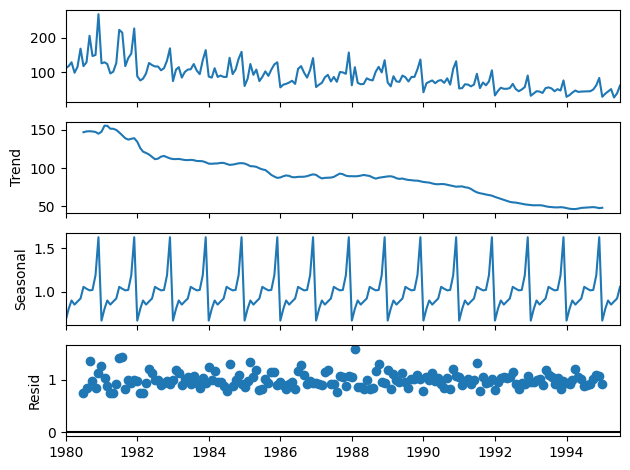

In [178]:
decomposition = seasonal_decompose(df,model='multiplicative')
decomposition.plot();

In [179]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.round(2).head(12),'\n')
print('Seasonality','\n',seasonality.round(2).head(12),'\n')
print('Residual','\n',residual.round(2).head(12),'\n')

Trend 
 Time_Stamp
1980-01-01       NaN
1980-02-01       NaN
1980-03-01       NaN
1980-04-01       NaN
1980-05-01       NaN
1980-06-01       NaN
1980-07-01    147.08
1980-08-01    148.12
1980-09-01    148.37
1980-10-01    148.08
1980-11-01    147.42
1980-12-01    145.12
Name: trend, dtype: float64 

Seasonality 
 Time_Stamp
1980-01-01    0.67
1980-02-01    0.81
1980-03-01    0.90
1980-04-01    0.85
1980-05-01    0.89
1980-06-01    0.92
1980-07-01    1.06
1980-08-01    1.04
1980-09-01    1.02
1980-10-01    1.02
1980-11-01    1.19
1980-12-01    1.63
Name: seasonal, dtype: float64 

Residual 
 Time_Stamp
1980-01-01     NaN
1980-02-01     NaN
1980-03-01     NaN
1980-04-01     NaN
1980-05-01     NaN
1980-06-01     NaN
1980-07-01    0.76
1980-08-01    0.84
1980-09-01    1.36
1980-10-01    0.97
1980-11-01    0.85
1980-12-01    1.13
Name: resid, dtype: float64 



##Insights

* It appears that the multiplicative decomposition may be a better fit for this data. The seasonal fluctuations seem to have a stronger relationship with the level of the series, which is characteristic of a multiplicative model.
* In the multiplicative model, the seasonal variations grew/shrank proportionally with the trend, while in this additive model, the seasonal variations are constant over time.
* The additive model assumes constant seasonal effects and residuals in absolute terms, which does not align with the data.

# **Data Pre-processing**

## Train - Test Split

In [180]:
train    =   df[0:int(len(df)*0.7)]
test     =   df[int(len(df)*0.7):]

In [181]:
train

Rose
Time_Stamp       
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0
...           ...
1990-06-01   76.0
1990-07-01   78.0
1990-08-01   70.0
1990-09-01   83.0
1990-10-01   65.0

[130 rows x 1 columns]

In [182]:
test

Rose
Time_Stamp            
1990-11-01  110.000000
1990-12-01  132.000000
1991-01-01   54.000000
1991-02-01   55.000000
1991-03-01   66.000000
1991-04-01   65.000000
1991-05-01   60.000000
1991-06-01   65.000000
1991-07-01   96.000000
1991-08-01   55.000000
1991-09-01   71.000000
1991-10-01   63.000000
1991-11-01   74.000000
1991-12-01  106.000000
1992-01-01   34.000000
1992-02-01   47.000000
1992-03-01   56.000000
1992-04-01   53.000000
1992-05-01   53.000000
1992-06-01   55.000000
1992-07-01   67.000000
1992-08-01   52.000000
1992-09-01   46.000000
1992-10-01   51.000000
1992-11-01   58.000000
1992-12-01   91.000000
1993-01-01   33.000000
1993-02-01   40.000000
1993-03-01   46.000000
1993-04-01   45.000000
1993-05-01   41.000000
1993-06-01   55.000000
1993-07-01   57.000000
1993-08-01   54.000000
1993-09-01   46.000000
1993-10-01   52.000000
1993-11-01   48.000000
1993-12-01   77.000000
1994-01-01   30.000000
1994-02-01   35.000000
1994-03-01   42.000000
1994-04-01   48.000000
1994-05-01   44.000000
1994-06-01   45.000000
1994-07-01   45.333333
1994-08-01   45.666667
1994-09-01   46.000000
1994-10-01   51.000000
1994-11-01   63.000000
1994-12-01   84.000000
1995-01-01   30.000000
1995-02-01   39.000000
1995-03-01   45.000000
1995-04-01   52.000000
1995-05-01   28.000000
1995-06-01   40.000000
1995-07-01   62.000000

In [183]:
print(train.shape)
print(test.shape)

(130, 1)
(57, 1)


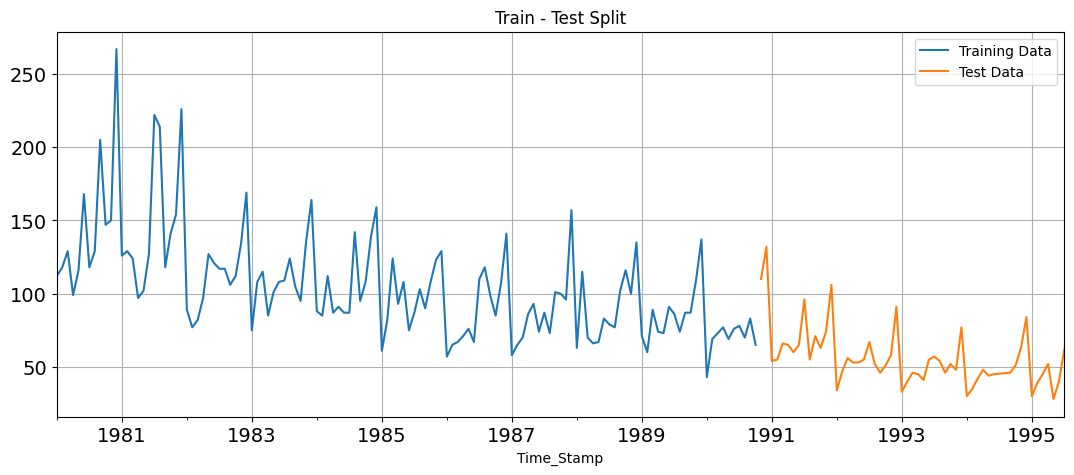

In [184]:
train['Rose'].plot(figsize=(13,5), fontsize=14)
test['Rose'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.title('Train - Test Split')
plt.show()

#**Model Building - Original Data**

##Linear Regression

Numerical time instance order for both the training and test set

In [185]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train) for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130]
Test Time instance 
 [130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186]


In [186]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

In [187]:
LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time

print('First few rows of Training Data','\n',LinearRegression_train.head(),'\n')
print('Last few rows of Training Data','\n',LinearRegression_train.tail(),'\n')
print('First few rows of Test Data','\n',LinearRegression_test.head(),'\n')
print('Last few rows of Test Data','\n',LinearRegression_test.tail(),'\n')

First few rows of Training Data 
              Rose  time
Time_Stamp             
1980-01-01  112.0     1
1980-02-01  118.0     2
1980-03-01  129.0     3
1980-04-01   99.0     4
1980-05-01  116.0     5 

Last few rows of Training Data 
             Rose  time
Time_Stamp            
1990-06-01  76.0   126
1990-07-01  78.0   127
1990-08-01  70.0   128
1990-09-01  83.0   129
1990-10-01  65.0   130 

First few rows of Test Data 
              Rose  time
Time_Stamp             
1990-11-01  110.0   130
1990-12-01  132.0   131
1991-01-01   54.0   132
1991-02-01   55.0   133
1991-03-01   66.0   134 

Last few rows of Test Data 
             Rose  time
Time_Stamp            
1995-03-01  45.0   182
1995-04-01  52.0   183
1995-05-01  28.0   184
1995-06-01  40.0   185
1995-07-01  62.0   186 



In [188]:
lr = LinearRegression()

In [189]:
lr.fit(LinearRegression_train[['time']],LinearRegression_train['Rose'].values)

LinearRegression()

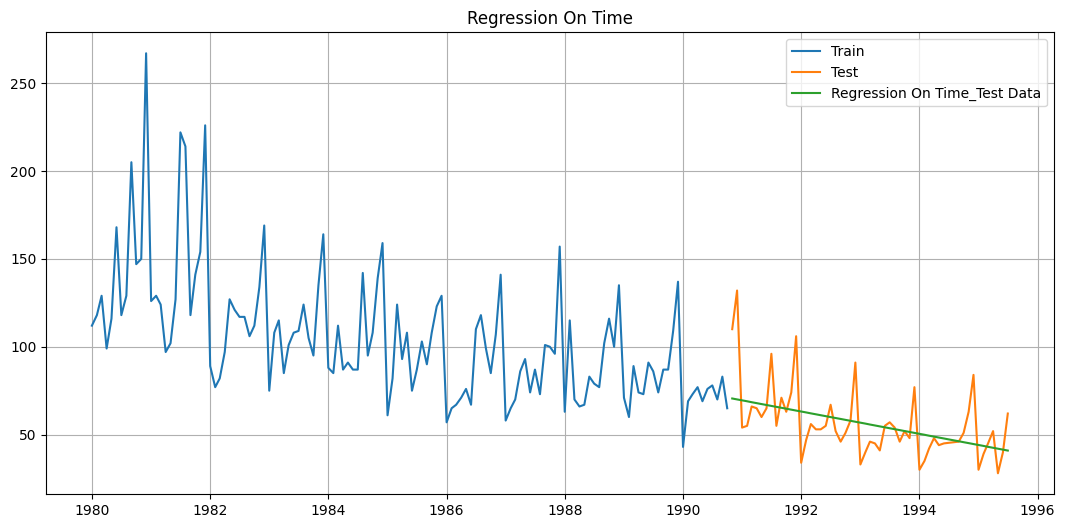

In [190]:
test_predictions_model1         = lr.predict(LinearRegression_test[['time']])
LinearRegression_test['RegOnTime'] = test_predictions_model1

plt.figure(figsize=(13,6))
plt.plot( train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.grid()
plt.title('Regression On Time');

### Model Evaluation

In [191]:
linear_reg_rmse_test = mean_squared_error(LinearRegression_test['Rose'],test_predictions_model1,squared=False)
print("For Linear regression forecast on the Test Data,  RMSE is %3.2f" %(linear_reg_rmse_test))

For Linear regression forecast on the Test Data,  RMSE is 17.33


In [192]:
resultsDf = pd.DataFrame({'Test RMSE': [linear_reg_rmse_test]},index=['RegressionOnTime'])
resultsDf

Test RMSE
RegressionOnTime  17.333437

##Simple Average

In [193]:
SA_train = train.copy()
SA_test = test.copy()

In [194]:
avg_value = np.mean(SA_train)

In [195]:
forecast = np.full_like(SA_test, avg_value)

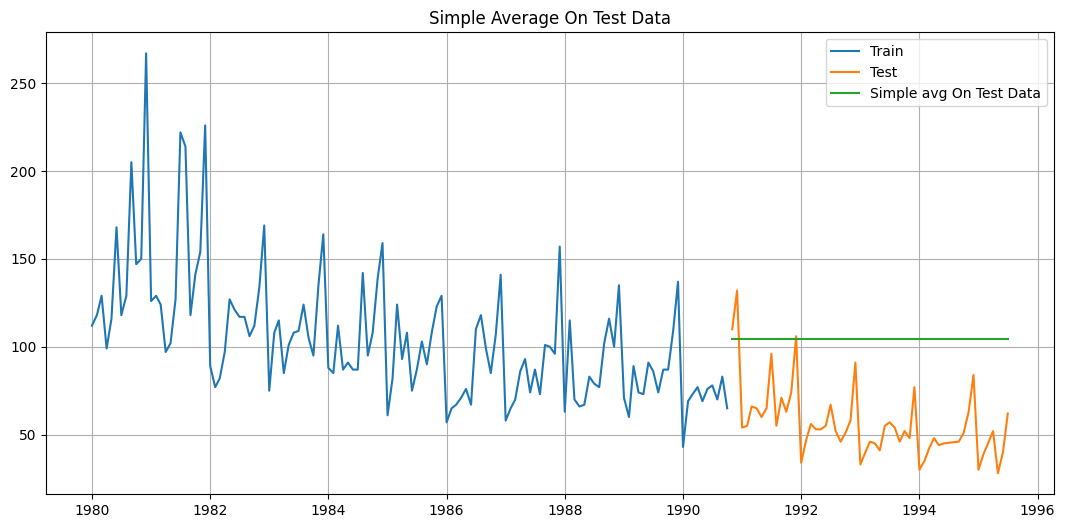

In [196]:
SA_test['SimpleAvg_Pred'] = forecast

plt.figure(figsize=(13,6))
plt.plot( train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(SA_test['SimpleAvg_Pred'], label='Simple avg On Test Data')
plt.legend(loc='best')
plt.grid()
plt.title('Simple Average On Test Data');

### Model Evaluation

In [197]:
SA_rmse_test = mean_squared_error(SA_test['Rose'],forecast,squared=False)
print("For Simple Average forecast on the Test Data,  RMSE is %3.2f" %(SA_rmse_test))

For Simple Average forecast on the Test Data,  RMSE is 52.41


In [198]:
resultsDf_2 = pd.DataFrame({'Test RMSE': [SA_rmse_test]}
                           ,index=['SimpleAverage'])

resultsDf = pd.concat([resultsDf, resultsDf_2])
resultsDf

Test RMSE
RegressionOnTime  17.333437
SimpleAverage     52.412093

##Moving Average

In [199]:
MovingAverage = df.copy()
MovingAverage.head()

Rose
Time_Stamp       
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0

In [200]:
MovingAverage['Trailing_2'] = MovingAverage['Rose'].rolling(2).mean()
MovingAverage['Trailing_4'] = MovingAverage['Rose'].rolling(4).mean()
MovingAverage['Trailing_6'] = MovingAverage['Rose'].rolling(6).mean()
MovingAverage['Trailing_9'] = MovingAverage['Rose'].rolling(9).mean()

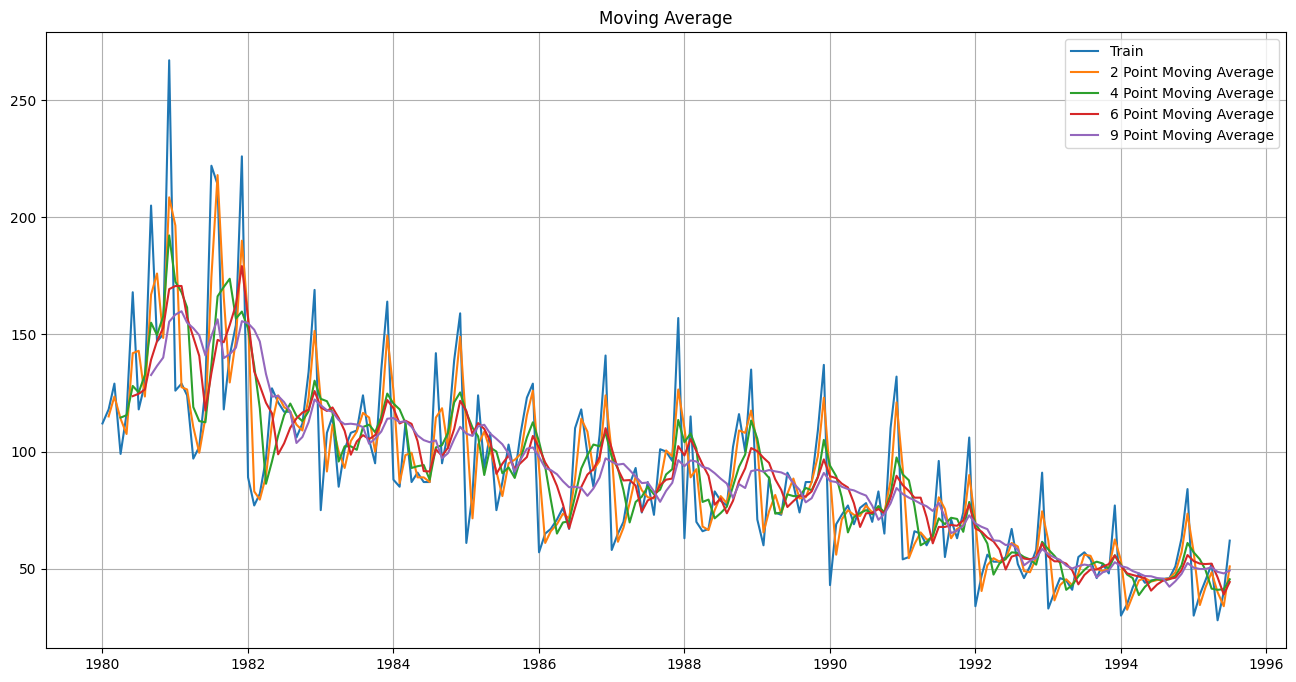

In [201]:


plt.figure(figsize=(16,8))
plt.plot(MovingAverage['Rose'], label='Train')
plt.plot(MovingAverage['Trailing_2'], label='2 Point Moving Average')
plt.plot(MovingAverage['Trailing_4'], label='4 Point Moving Average')
plt.plot(MovingAverage['Trailing_6'],label = '6 Point Moving Average')
plt.plot(MovingAverage['Trailing_9'],label = '9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid()
plt.title('Moving Average');

In [202]:
trailing_MovingAverage_train=MovingAverage[0:int(len(MovingAverage)*0.7)]
trailing_MovingAverage_test=MovingAverage[int(len(MovingAverage)*0.7):]

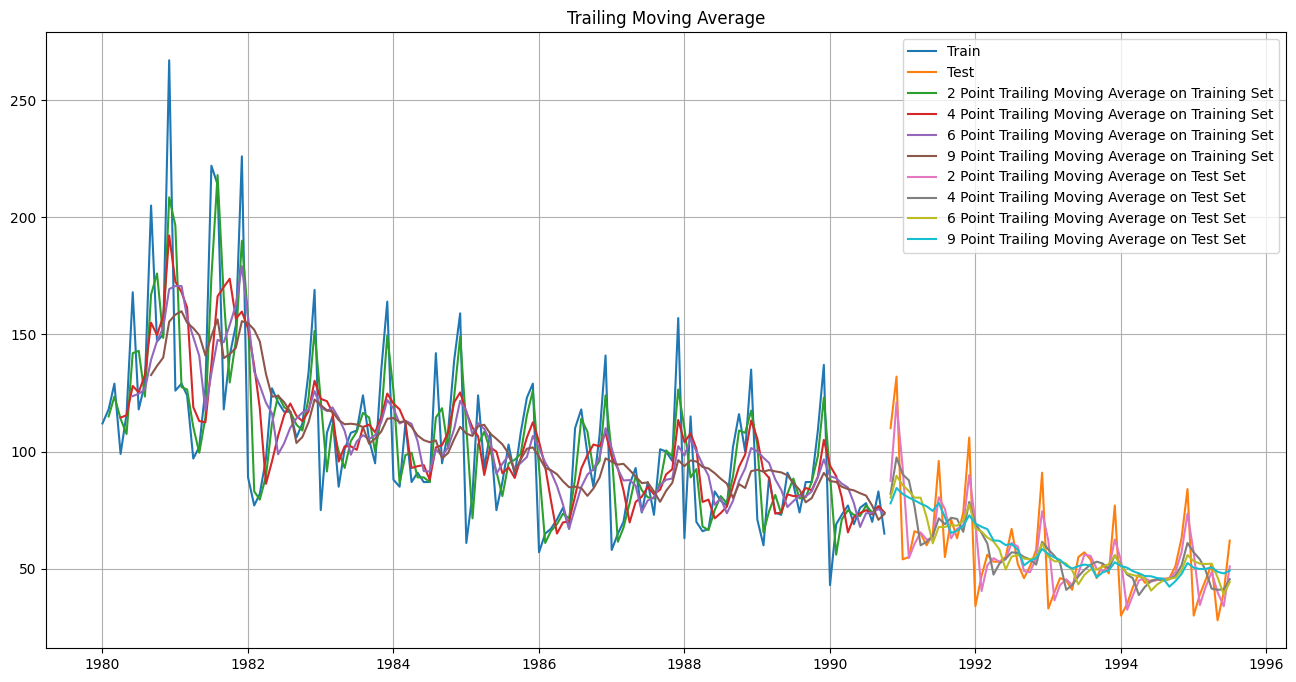

In [203]:
plt.figure(figsize=(16,8))
plt.plot(trailing_MovingAverage_train['Rose'], label='Train')
plt.plot(trailing_MovingAverage_test['Rose'], label='Test')

plt.plot(trailing_MovingAverage_train['Trailing_2'], label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_4'], label='4 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_6'],label = '6 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_9'],label = '9 Point Trailing Moving Average on Training Set')

plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_4'], label='4 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_6'],label = '6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_9'],label = '9 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid()
plt.title('Trailing Moving Average');

### Model Evaluation

In [204]:
## Test Data - RMSE --> 2 point Trailing MA

rmse_model3_test_2 = mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_2'],squared=False)
print("For 2 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model3_test_2))

## Test Data - RMSE  --> 4 point Trailing MA

rmse_model3_test_4 = mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_4'],squared=False)
print("For 4 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model3_test_4))

## Test Data - RMSE --> 6 point Trailing MA

rmse_model3_test_6 = mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_6'],squared=False)
print("For 6 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model3_test_6))

## Test Data - RMSE  --> 9 point Trailing MA

rmse_model3_test_9 = mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_9'],squared=False)
print("For 9 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f " %(rmse_model3_test_9))

For 2 point Moving Average Model forecast on the Training Data,  RMSE is 11.801
For 4 point Moving Average Model forecast on the Training Data,  RMSE is 15.367
For 6 point Moving Average Model forecast on the Training Data,  RMSE is 15.862
For 9 point Moving Average Model forecast on the Training Data,  RMSE is 16.342 


In [205]:

resultsDf_3 = pd.DataFrame({'Test RMSE': [rmse_model3_test_2,rmse_model3_test_4
                                          ,rmse_model3_test_6,rmse_model3_test_9]}
                           ,index=['2pointTrailingMovingAverage','4pointTrailingMovingAverage'
                                   ,'6pointTrailingMovingAverage','9pointTrailingMovingAverage'])

resultsDf = pd.concat([resultsDf, resultsDf_3])
resultsDf

Test RMSE
RegressionOnTime             17.333437
SimpleAverage                52.412093
2pointTrailingMovingAverage  11.801043
4pointTrailingMovingAverage  15.367212
6pointTrailingMovingAverage  15.862350
9pointTrailingMovingAverage  16.341919

##Simple Exponential Smoothing

In [206]:
SES_train = train.copy()
SES_test = test.copy()

In [207]:
model_SES = SimpleExpSmoothing(SES_train['Rose'])

In [208]:
model_SES_autofit = model_SES.fit(optimized=True)

In [209]:
model_SES_autofit.params

{'smoothing_level': 0.1277774057492626,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [210]:
SES_test['predict'] = model_SES_autofit.forecast(steps=len(test))
SES_test.head()

Rose    predict
Time_Stamp                  
1990-11-01  110.0  77.599284
1990-12-01  132.0  77.599284
1991-01-01   54.0  77.599284
1991-02-01   55.0  77.599284
1991-03-01   66.0  77.599284

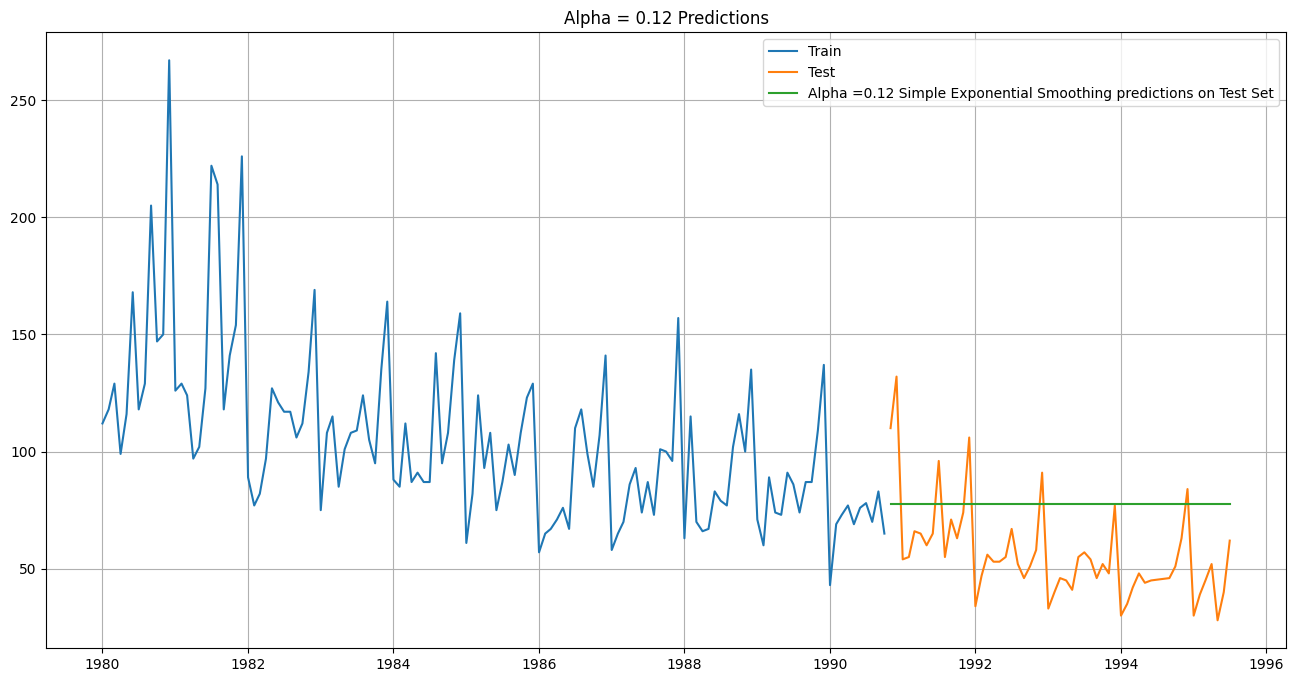

In [211]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(SES_train['Rose'], label='Train')
plt.plot(SES_test['Rose'], label='Test')

plt.plot(SES_test['predict'], label='Alpha =0.12 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.12 Predictions');

### Model Evaluation for $\alpha$ = 0.12 : Simple Exponential Smoothing

In [212]:
rmse_model4_test_1 = mean_squared_error(SES_test['Rose'],SES_test['predict'],squared=False)
print("For Alpha = 0.12 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is %3.3f" %(rmse_model4_test_1))

For Alpha = 0.12 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is 29.224


In [213]:
resultsDf_4 = pd.DataFrame({'Test RMSE': [rmse_model4_test_1]},index=['Alpha=0.12,SimpleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_4])
resultsDf

Test RMSE
RegressionOnTime                       17.333437
SimpleAverage                          52.412093
2pointTrailingMovingAverage            11.801043
4pointTrailingMovingAverage            15.367212
6pointTrailingMovingAverage            15.862350
9pointTrailingMovingAverage            16.341919
Alpha=0.12,SimpleExponentialSmoothing  29.223677

In [214]:
len(test)

57

#### Setting different alpha values.



In [215]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_5 = pd.DataFrame({'Alpha Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_5

Empty DataFrame
Columns: [Alpha Values, Train RMSE, Test RMSE]
Index: []

In [216]:
for i in np.arange(0.3,1,0.1):
    model_SES_alpha_i = model_SES.fit(smoothing_level=i,optimized=False,use_brute=True)
    SES_train['predict',i] = model_SES_alpha_i.fittedvalues
    SES_test['predict',i] = model_SES_alpha_i.forecast(steps=57)

    rmse_model4_train_i = mean_squared_error(SES_train['Rose'],SES_train['predict',i],squared=False)

    rmse_model4_test_i = mean_squared_error(SES_test['Rose'],SES_test['predict',i],squared=False)

    new_row = pd.DataFrame({
        'Alpha Values': [i],
        'Train RMSE': [rmse_model4_train_i],
        'Test RMSE': [rmse_model4_test_i]
    })
    resultsDf_5 = pd.concat([resultsDf_5, new_row], ignore_index=True)

In [217]:
resultsDf_5

Alpha Values  Train RMSE  Test RMSE
0           0.3   32.292266  26.310348
1           0.4   32.893017  25.657764
2           0.5   33.578304  25.109604
3           0.6   34.372651  24.529811
4           0.7   35.288467  23.894929
5           0.8   36.330954  23.212777
6           0.9   37.507371  22.496819

In [218]:
SES_test.columns

Index([                         'Rose',                       'predict',
                      ('predict', 0.3),                ('predict', 0.4),
                      ('predict', 0.5), ('predict', 0.6000000000000001),
       ('predict', 0.7000000000000002), ('predict', 0.8000000000000003),
       ('predict', 0.9000000000000001)],
      dtype='object')

## Model Evaluation

In [219]:
resultsDf_5.sort_values(by=['Test RMSE'],ascending=True)

Alpha Values  Train RMSE  Test RMSE
6           0.9   37.507371  22.496819
5           0.8   36.330954  23.212777
4           0.7   35.288467  23.894929
3           0.6   34.372651  24.529811
2           0.5   33.578304  25.109604
1           0.4   32.893017  25.657764
0           0.3   32.292266  26.310348

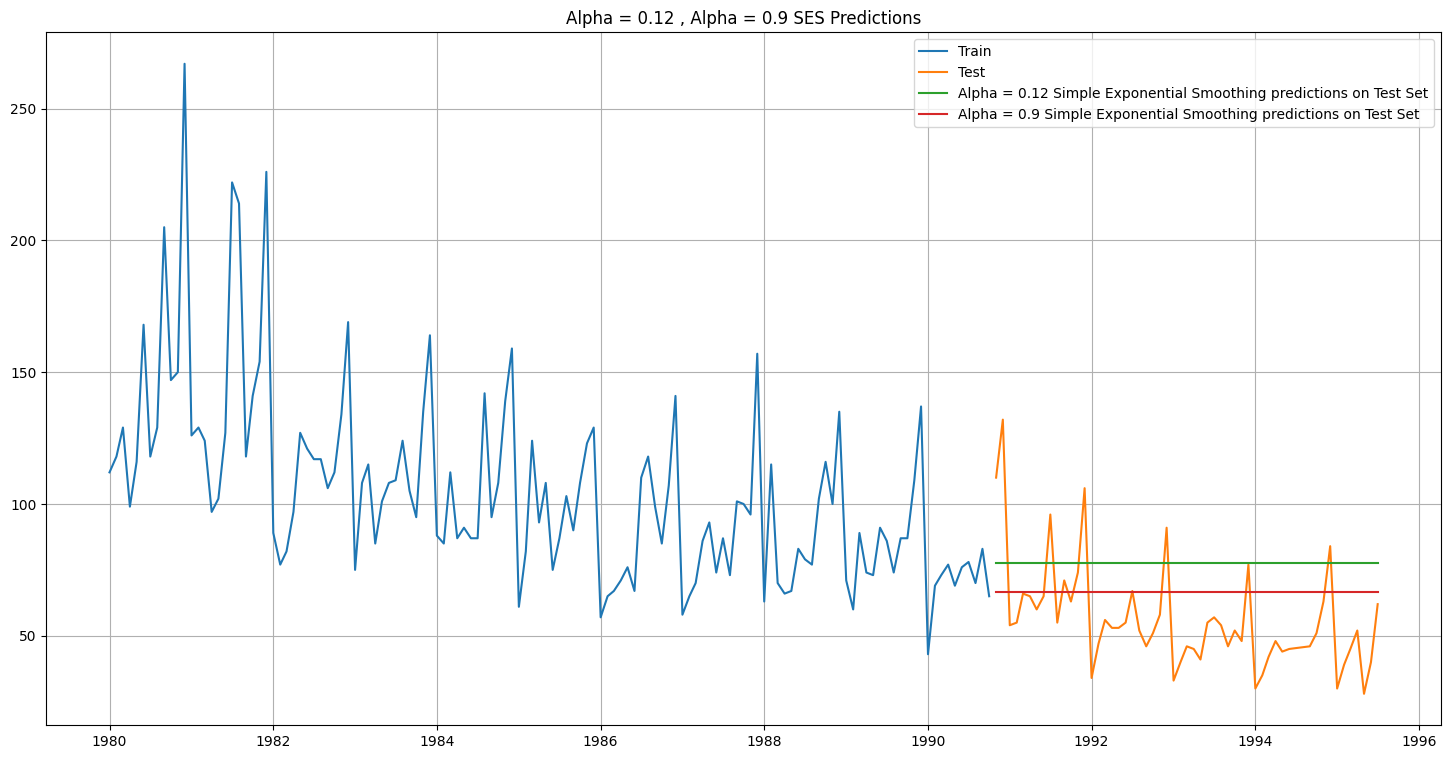

In [220]:


plt.figure(figsize=(18,9))
plt.plot(SES_train['Rose'], label='Train')
plt.plot(SES_test['Rose'], label='Test')

plt.plot(SES_test['predict'], label='Alpha = 0.12 Simple Exponential Smoothing predictions on Test Set')

plt.plot(SES_test['predict', 0.9000000000000001], label='Alpha = 0.9 Simple Exponential Smoothing predictions on Test Set')



plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.12 , Alpha = 0.9 SES Predictions');

In [221]:
resultsDf_5_1 = pd.DataFrame({'Test RMSE': [resultsDf_5.sort_values(by=['Test RMSE'],ascending=True).values[0][2]]}
                           ,index=['Alpha=0.9,SimpleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_5_1])
resultsDf

Test RMSE
RegressionOnTime                       17.333437
SimpleAverage                          52.412093
2pointTrailingMovingAverage            11.801043
4pointTrailingMovingAverage            15.367212
6pointTrailingMovingAverage            15.862350
9pointTrailingMovingAverage            16.341919
Alpha=0.12,SimpleExponentialSmoothing  29.223677
Alpha=0.9,SimpleExponentialSmoothing   22.496819

##Double Exponential Smoothing (Holt's Model)

In [222]:
DES_train = train.copy()
DES_test = test.copy()

In [223]:
model_DES = Holt(DES_train['Rose'])

In [224]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_6 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_6

Empty DataFrame
Columns: [Alpha Values, Beta Values, Train RMSE, Test RMSE]
Index: []

In [225]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_trend=j,optimized=False,use_brute=True)
        DES_train['predict',i,j] = model_DES_alpha_i_j.fittedvalues
        DES_test['predict',i,j] = model_DES_alpha_i_j.forecast(steps=57)

        rmse_model5_train = mean_squared_error(DES_train['Rose'],DES_train['predict',i,j],squared=False)

        rmse_model5_test = mean_squared_error(DES_test['Rose'],DES_test['predict',i,j],squared=False)

        new_row = pd.DataFrame({
        'Alpha Values': [i],
        'Beta Values': [j],
        'Train RMSE': [rmse_model5_train],
        'Test RMSE': [rmse_model5_test]
        })
        resultsDf_6 = pd.concat([resultsDf_6, new_row], ignore_index=True)

In [226]:
resultsDf_6

Alpha Values  Beta Values  Train RMSE   Test RMSE
0            0.3          0.3   35.792345   26.531373
1            0.3          0.4   37.287813   18.343250
2            0.3          0.5   38.841090   26.672378
3            0.3          0.6   40.299159   59.403849
4            0.3          0.7   41.486887   95.600325
..           ...          ...         ...         ...
59           1.0          0.6   52.018949  264.855344
60           1.0          0.7   54.697098  331.622574
61           1.0          0.8   57.575818  406.506557
62           1.0          0.9   60.691028  491.247514
63           1.0          1.0   64.093561  587.897332

[64 rows x 4 columns]

In [227]:
resultsDf_6.sort_values(by=['Test RMSE']).head()

Alpha Values  Beta Values  Train RMSE  Test RMSE
1            0.3          0.4   37.287813  18.343250
12           0.4          0.7   40.744796  18.975318
9            0.4          0.4   37.990913  19.133156
17           0.5          0.4   38.598226  19.197151
8            0.4          0.3   36.682435  19.769770

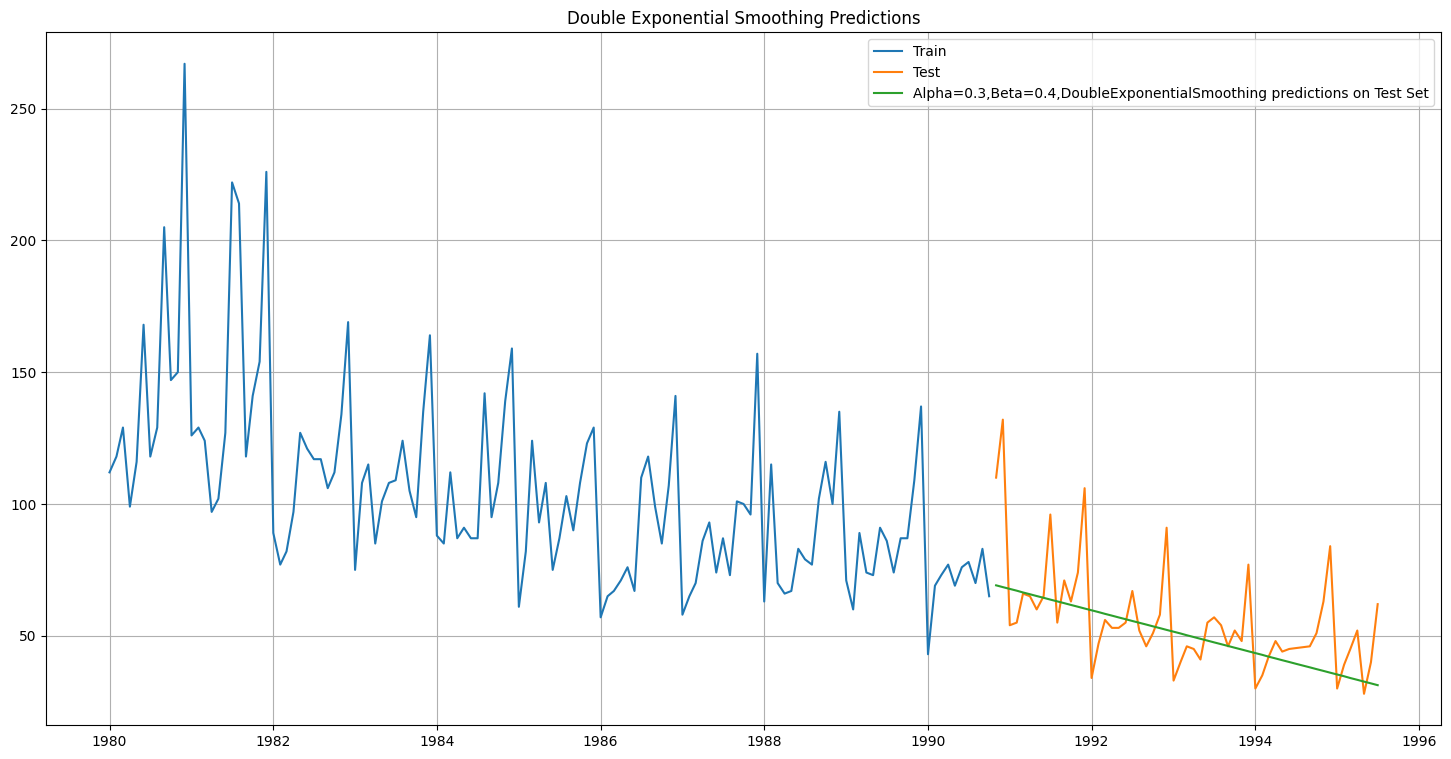

In [228]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(DES_train['Rose'], label='Train')
plt.plot(DES_test['Rose'], label='Test')

plt.plot(DES_test['predict', 0.3, 0.4], label='Alpha=0.3,Beta=0.4,DoubleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid()
plt.title('Double Exponential Smoothing Predictions');

In [229]:
resultsDf_6_1 = pd.DataFrame({'Test RMSE': [resultsDf_6.sort_values(by=['Test RMSE']).values[0][3]]}
                           ,index=['Alpha=0.3,Beta=0.4,DoubleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_6_1])
resultsDf

Test RMSE
RegressionOnTime                               17.333437
SimpleAverage                                  52.412093
2pointTrailingMovingAverage                    11.801043
4pointTrailingMovingAverage                    15.367212
6pointTrailingMovingAverage                    15.862350
9pointTrailingMovingAverage                    16.341919
Alpha=0.12,SimpleExponentialSmoothing          29.223677
Alpha=0.9,SimpleExponentialSmoothing           22.496819
Alpha=0.3,Beta=0.4,DoubleExponentialSmoothing  18.343250

##Triple Exponential Smoothing (Holt - Winter's Model)

In [230]:
TES_train = train.copy()
TES_test = test.copy()

In [231]:
TES_train

Rose
Time_Stamp       
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0
...           ...
1990-06-01   76.0
1990-07-01   78.0
1990-08-01   70.0
1990-09-01   83.0
1990-10-01   65.0

[130 rows x 1 columns]

In [232]:
model_TES = ExponentialSmoothing(TES_train['Rose'],trend='additive',seasonal='multiplicative')

In [233]:
model_TES_autofit = model_TES.fit()

In [234]:
model_TES_autofit.params

{'smoothing_level': 0.0999080139189177,
 'smoothing_trend': 1.9932826568022853e-06,
 'smoothing_seasonal': 0.00017683239767298466,
 'damping_trend': nan,
 'initial_level': 109.16836143052193,
 'initial_trend': -0.44137924420686336,
 'initial_seasons': array([1.0049411 , 1.13565754, 1.2416344 , 1.08896356, 1.2223928 ,
        1.31686195, 1.44959601, 1.55043078, 1.45169973, 1.42782318,
        1.64159637, 2.26353792]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [235]:
## Prediction on the test data

TES_test['auto_predict'] = model_TES_autofit.forecast(steps=len(test))
TES_test.head()

Rose  auto_predict
Time_Stamp                     
1990-11-01  110.0     86.291902
1990-12-01  132.0    117.979447
1991-01-01   54.0     51.933830
1991-02-01   55.0     58.193935
1991-03-01   66.0     63.075288

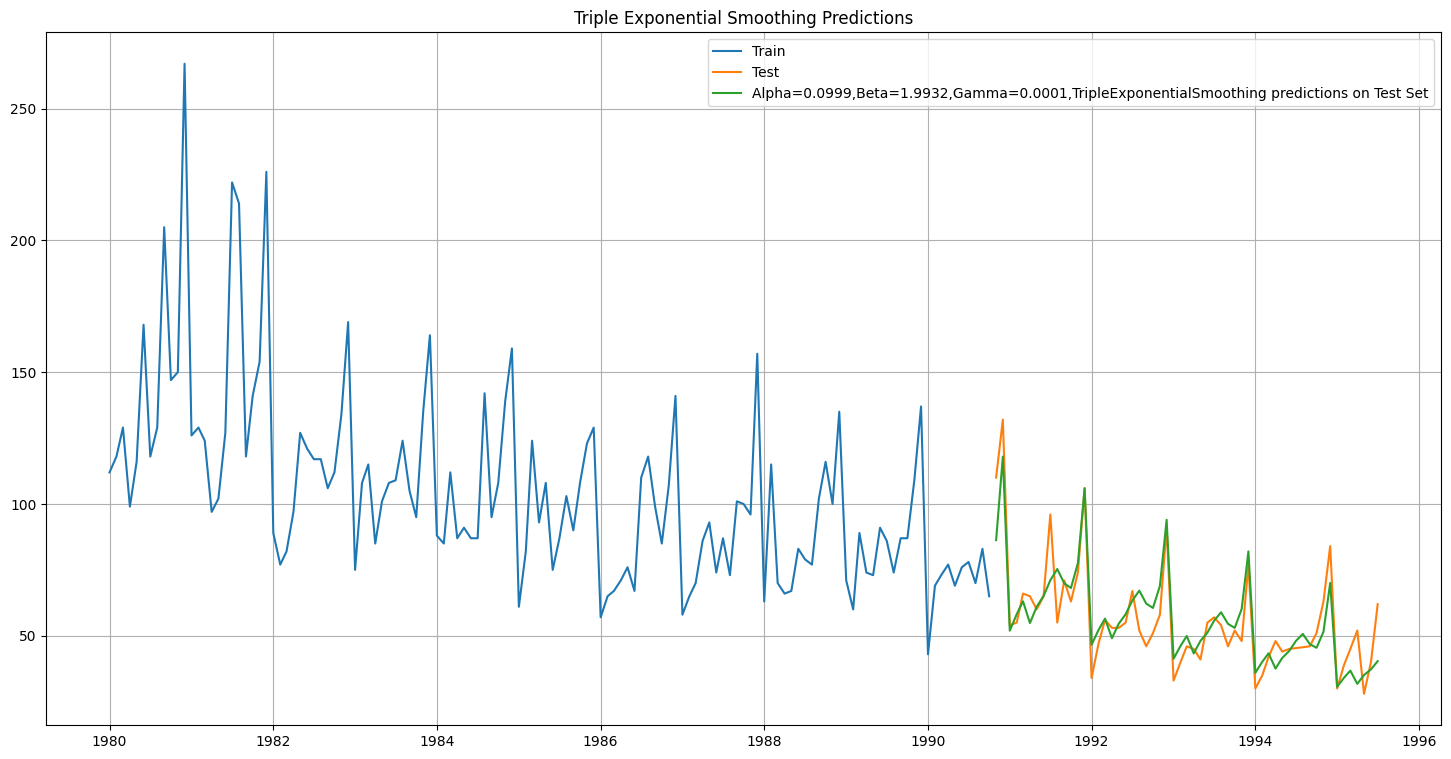

In [236]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(TES_train['Rose'], label='Train')
plt.plot(TES_test['Rose'], label='Test')

plt.plot(TES_test['auto_predict'], label='Alpha=0.0999,Beta=1.9932,Gamma=0.0001,TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid()
plt.title('Triple Exponential Smoothing Predictions');

In [237]:
## Test Data

rmse_model6_test_1 = mean_squared_error(TES_test['Rose'],TES_test['auto_predict'],squared=False)
print("For Alpha=0.0999,Beta=1.9932,Gamma=0.0001, Triple Exponential Smoothing Model forecast on the Test Data,  RMSE is %3.3f" %(rmse_model6_test_1))

For Alpha=0.0999,Beta=1.9932,Gamma=0.0001, Triple Exponential Smoothing Model forecast on the Test Data,  RMSE is 9.329


In [238]:
resultsDf_7_1 = pd.DataFrame({'Test RMSE': [rmse_model6_test_1]}
                           ,index=['Alpha=0.0999,Beta=1.9932,Gamma=0.0001,TripleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_7_1])
resultsDf

Test RMSE
RegressionOnTime                                    17.333437
SimpleAverage                                       52.412093
2pointTrailingMovingAverage                         11.801043
4pointTrailingMovingAverage                         15.367212
6pointTrailingMovingAverage                         15.862350
9pointTrailingMovingAverage                         16.341919
Alpha=0.12,SimpleExponentialSmoothing               29.223677
Alpha=0.9,SimpleExponentialSmoothing                22.496819
Alpha=0.3,Beta=0.4,DoubleExponentialSmoothing       18.343250
Alpha=0.0999,Beta=1.9932,Gamma=0.0001,TripleExp...   9.328733

In [239]:


resultsDf_7_2 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_7_2

Empty DataFrame
Columns: [Alpha Values, Beta Values, Gamma Values, Train RMSE, Test RMSE]
Index: []

In [240]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        for k in np.arange(0.3,1.1,0.1):
            model_TES_alpha_i_j_k = model_TES.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
            TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=57)

            rmse_model7_train = mean_squared_error(TES_train['Rose'],TES_train['predict',i,j,k],squared=False)

            rmse_model7_test = mean_squared_error(TES_test['Rose'],TES_test['predict',i,j,k],squared=False)
            new_row = pd.DataFrame({
            'Alpha Values': [i],
            'Beta Values': [j],
            'Gamma Values':[k],
            'Train RMSE': [rmse_model7_train],
            'Test RMSE': [rmse_model7_test]
            })
            resultsDf_7_2 = pd.concat([resultsDf_7_2, new_row], ignore_index=True)



In [241]:
resultsDf_7_2

Alpha Values  Beta Values  Gamma Values    Train RMSE     Test RMSE
0             0.3          0.3           0.3     23.385275     77.683168
1             0.3          0.3           0.4     24.663714     85.240757
2             0.3          0.3           0.5     26.315722     99.310272
3             0.3          0.3           0.6     28.443126    116.444043
4             0.3          0.3           0.7     31.169740    132.056218
..            ...          ...           ...           ...           ...
507           1.0          1.0           0.6   2156.016082   1764.935972
508           1.0          1.0           0.7   3114.343611   5623.268754
509           1.0          1.0           0.8   2455.974802   4317.157984
510           1.0          1.0           0.9  29056.690526  30910.588575
511           1.0          1.0           1.0   1588.932809   8368.146310

[512 rows x 5 columns]

In [242]:
resultsDf_7_2.sort_values(by=['Test RMSE']).head()

Alpha Values  Beta Values  Gamma Values  Train RMSE  Test RMSE
33            0.3          0.7           0.4   29.968505  28.362899
177           0.5          0.9           0.4   41.232290  28.802668
25            0.3          0.6           0.4   27.743621  39.656865
78            0.4          0.4           0.9   43.001123  51.375209
135           0.5          0.3           1.0   47.353331  62.161097

In [243]:
resultsDf_7_3 = pd.DataFrame({'Test RMSE': [resultsDf_7_2.sort_values(by=['Test RMSE']).values[0][4]]}
                           ,index=['Alpha=0.3,Beta=0.7,Gamma=0.4,TripleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_7_3])
resultsDf

Test RMSE
RegressionOnTime                                    17.333437
SimpleAverage                                       52.412093
2pointTrailingMovingAverage                         11.801043
4pointTrailingMovingAverage                         15.367212
6pointTrailingMovingAverage                         15.862350
9pointTrailingMovingAverage                         16.341919
Alpha=0.12,SimpleExponentialSmoothing               29.223677
Alpha=0.9,SimpleExponentialSmoothing                22.496819
Alpha=0.3,Beta=0.4,DoubleExponentialSmoothing       18.343250
Alpha=0.0999,Beta=1.9932,Gamma=0.0001,TripleExp...   9.328733
Alpha=0.3,Beta=0.7,Gamma=0.4,TripleExponentialS...  28.362899

In [244]:
print('Sorted by RMSE values on the Test Data:','\n',)
resultsDf.sort_values(by=['Test RMSE'])

Sorted by RMSE values on the Test Data: 



Test RMSE
Alpha=0.0999,Beta=1.9932,Gamma=0.0001,TripleExp...   9.328733
2pointTrailingMovingAverage                         11.801043
4pointTrailingMovingAverage                         15.367212
6pointTrailingMovingAverage                         15.862350
9pointTrailingMovingAverage                         16.341919
RegressionOnTime                                    17.333437
Alpha=0.3,Beta=0.4,DoubleExponentialSmoothing       18.343250
Alpha=0.9,SimpleExponentialSmoothing                22.496819
Alpha=0.3,Beta=0.7,Gamma=0.4,TripleExponentialS...  28.362899
Alpha=0.12,SimpleExponentialSmoothing               29.223677
SimpleAverage                                       52.412093

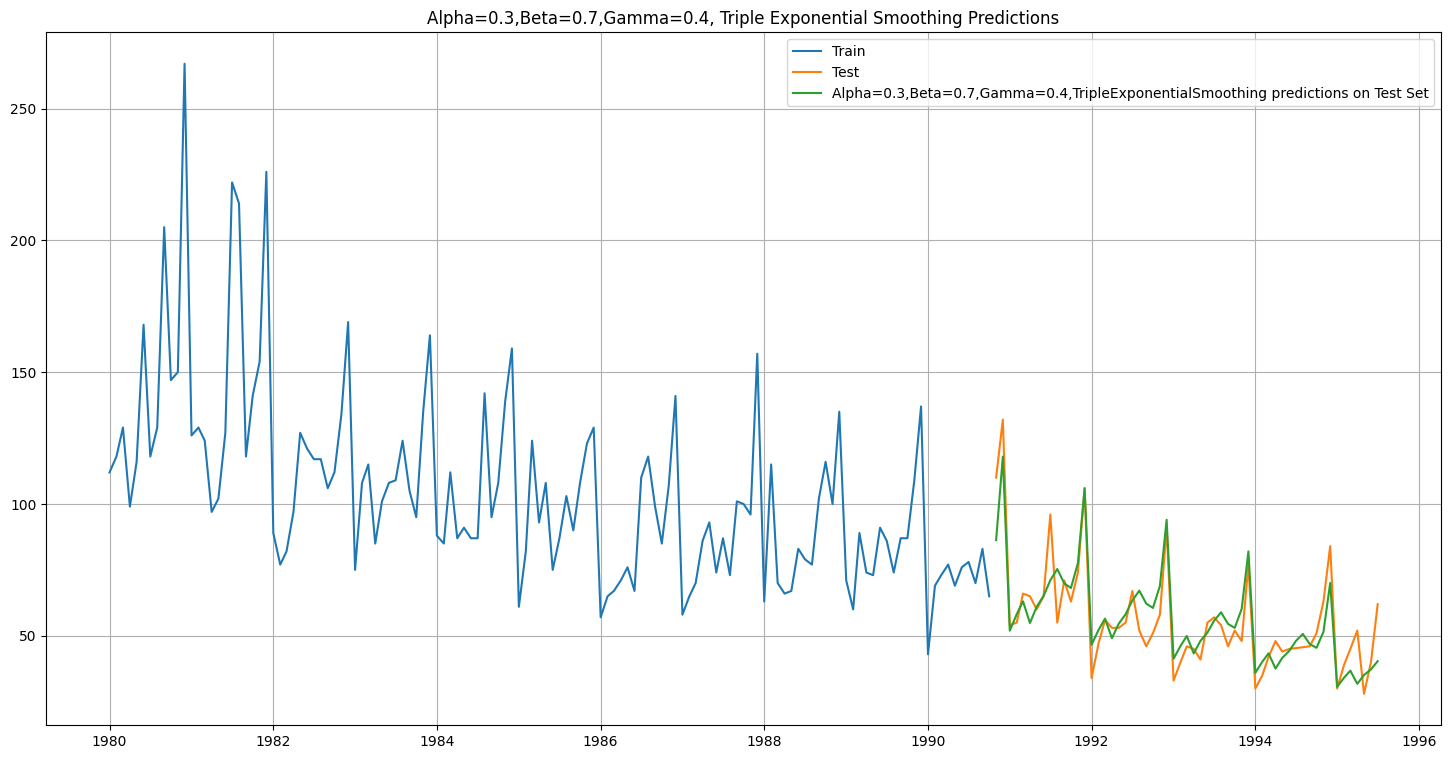

In [245]:
plt.figure(figsize=(18,9))
plt.plot(TES_train['Rose'], label='Train')
plt.plot(TES_test['Rose'], label='Test')

plt.plot(TES_test['auto_predict'], label='Alpha=0.3,Beta=0.7,Gamma=0.4,TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid()
plt.title('Alpha=0.3,Beta=0.7,Gamma=0.4, Triple Exponential Smoothing Predictions');

# **Check for stationarity**

In [246]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean() #determining the rolling mean
    rolstd = timeseries.rolling(window=7).std()   #determining the rolling standard deviation

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

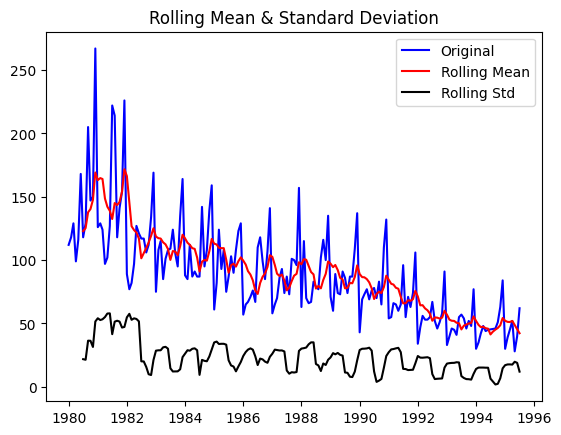

Results of Dickey-Fuller Test:
Test Statistic                  -1.876699
p-value                          0.343101
#Lags Used                      13.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64 



In [247]:
test_stationarity(df['Rose'])

We see that at 5% significant level the Time Series is non-stationary.

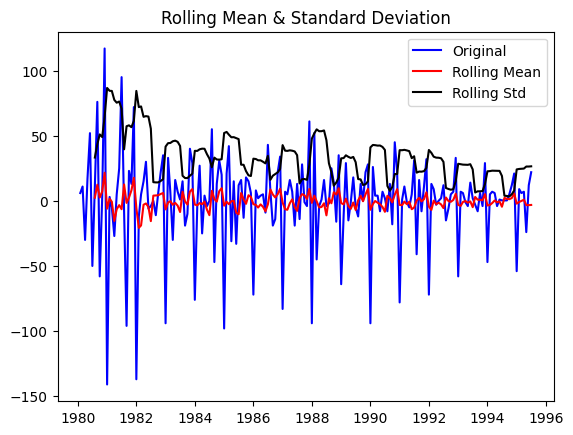

Results of Dickey-Fuller Test:
Test Statistic                -8.044392e+00
p-value                        1.810895e-12
#Lags Used                     1.200000e+01
Number of Observations Used    1.730000e+02
Critical Value (1%)           -3.468726e+00
Critical Value (5%)           -2.878396e+00
Critical Value (10%)          -2.575756e+00
dtype: float64 



In [248]:
test_stationarity(df['Rose'].diff().dropna())

At  α  = 0.05 the Time Series is indeed stationary.

# **Model Building - Stationary Data**

### Plot the Autocorrelation function plots on the whole data.

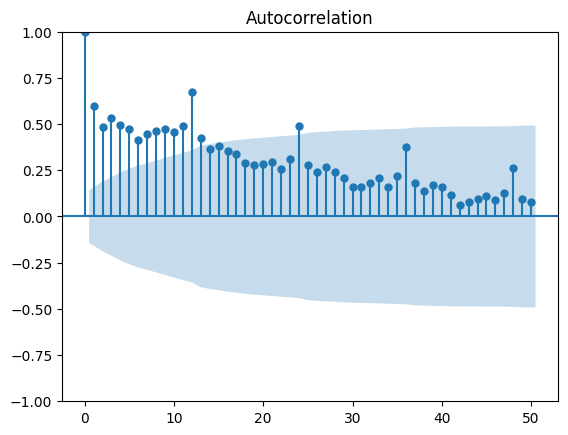

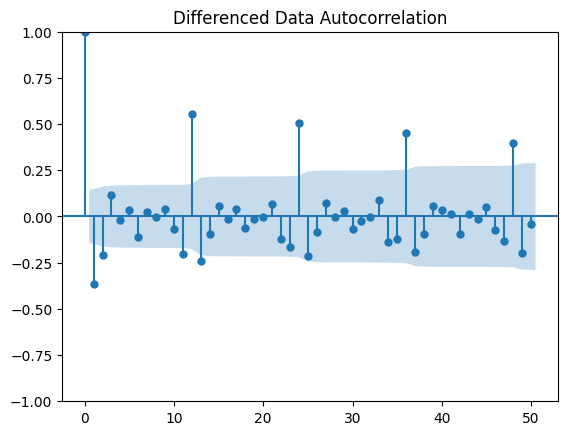

In [249]:
plot_acf(df['Rose'],lags=50)
plot_acf(df['Rose'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plt.show()


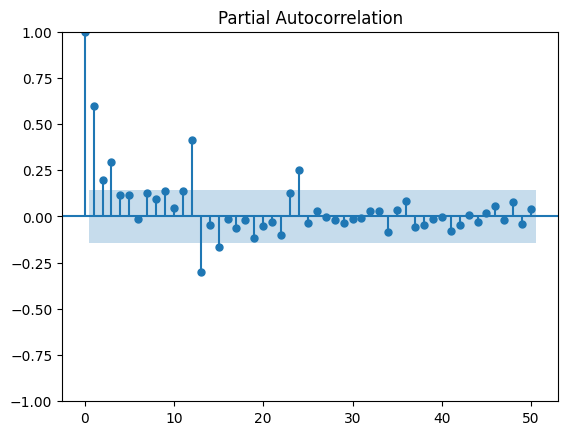

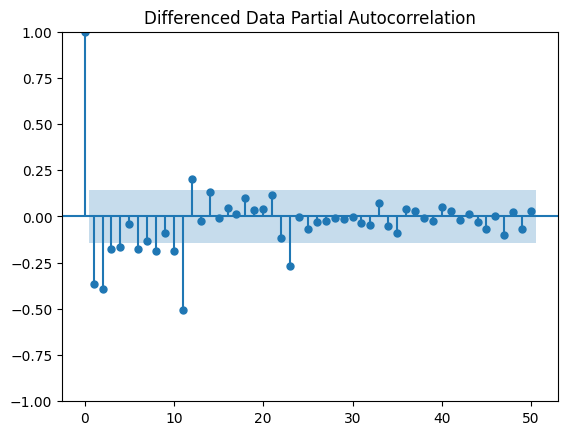

In [250]:
plot_pacf(df['Rose'],lags=50)
plot_pacf(df['Rose'].diff().dropna(),lags=50,title='Differenced Data Partial Autocorrelation')
plt.show()

### Auto ARIMA Model

In [251]:
auto_train = train.copy()
auto_test = test.copy()

In [252]:
auto_ARIMA_model = auto_arima(auto_train['Rose'],
                              seasonal=False,
                              stepwise=True,
                              trace=True)
print(auto_ARIMA_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1315.165, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1299.056, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1313.176, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1280.082, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1278.774, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1277.586, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1279.302, Time=0.44 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1275.676, Time=0.35 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1276.843, Time=0.22 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1277.406, Time=0

In [253]:
## Prediction on the test data

In [254]:
predicted_auto_ARIMA = auto_ARIMA_model.predict(n_periods=len(auto_test))

In [255]:
auto_test['auto_arima_forecast']=predicted_auto_ARIMA

In [256]:
##Test Data

In [257]:
auto_ARIMA_rmse_test = mean_squared_error(auto_test['Rose'],predicted_auto_ARIMA,squared=False)
print("For auto_ARIMA forecast on the Test Data,  RMSE is %3.2f" %(auto_ARIMA_rmse_test))

For auto_ARIMA forecast on the Test Data,  RMSE is 30.90


In [258]:
resultsDf_8 = pd.DataFrame({'Test RMSE': [auto_ARIMA_rmse_test]}
                           ,index=['AutoARIMA'])

resultsDf = pd.concat([resultsDf, resultsDf_8])
resultsDf

Test RMSE
RegressionOnTime                                    17.333437
SimpleAverage                                       52.412093
2pointTrailingMovingAverage                         11.801043
4pointTrailingMovingAverage                         15.367212
6pointTrailingMovingAverage                         15.862350
9pointTrailingMovingAverage                         16.341919
Alpha=0.12,SimpleExponentialSmoothing               29.223677
Alpha=0.9,SimpleExponentialSmoothing                22.496819
Alpha=0.3,Beta=0.4,DoubleExponentialSmoothing       18.343250
Alpha=0.0999,Beta=1.9932,Gamma=0.0001,TripleExp...   9.328733
Alpha=0.3,Beta=0.7,Gamma=0.4,TripleExponentialS...  28.362899
AutoARIMA                                           30.903804

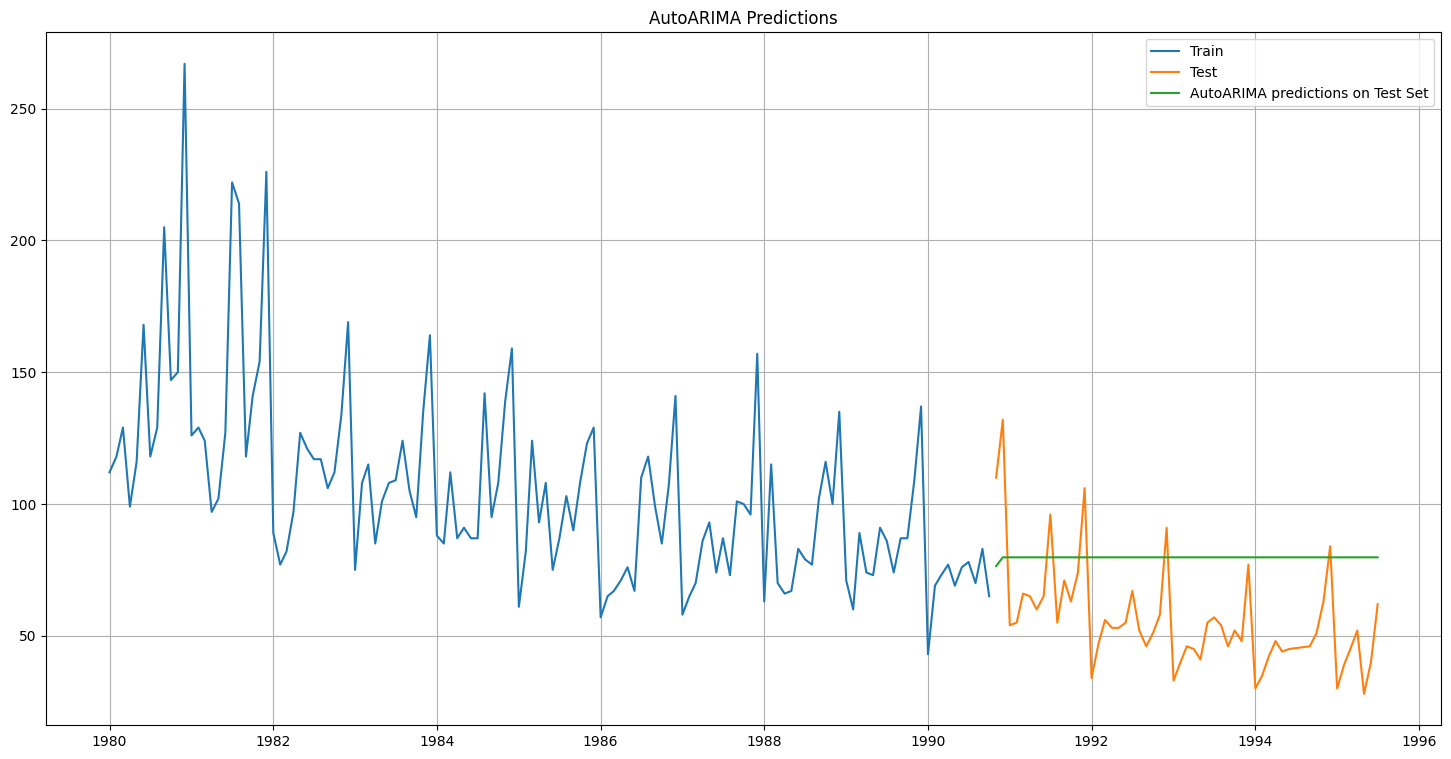

In [259]:
plt.figure(figsize=(18,9))
plt.plot(auto_train['Rose'], label='Train')
plt.plot(auto_test['Rose'], label='Test')

plt.plot(auto_test['auto_arima_forecast'], label='AutoARIMA predictions on Test Set')


plt.legend(loc='best')
plt.grid()
plt.title('AutoARIMA Predictions');

### ARIMA model

In [260]:
arima_train = train.copy()
arima_test = test.copy()

In [261]:
import itertools

# Define AR, I, MA ranges
p = q = range(0, 3)
d = range(1, 2)  # d typically set to 1 after first differencing

# Generate combinations of p, d, q
pdq = list(itertools.product(p, d, q))

print('Some parameter combinations for the Model...')
for i in range(1, len(pdq)):
    print('Model: {}'.format(pdq[i]))


Some parameter combinations for the Model...
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)


In [262]:
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

Empty DataFrame
Columns: [param, AIC]
Index: []

In [263]:
for param in pdq:
    try:
        # Fit the ARIMA model
        ARIMA_model = ARIMA(arima_train['Rose'], order=param).fit()

        # Print the AIC value for the current parameter combination
        print('ARIMA{} - AIC:{}'.format(param, ARIMA_model.aic))

        # Append the parameter combination and its corresponding AIC to the DataFrame
        new_row = pd.DataFrame({'param': [param], 'AIC': [ARIMA_model.aic]})
        ARIMA_AIC = pd.concat([ARIMA_AIC, new_row], ignore_index=True)
    except Exception as e:
        print(f"ARIMA{param} - Exception: {e}")

ARIMA(0, 1, 0) - AIC:1313.1758613526422
ARIMA(0, 1, 1) - AIC:1261.3274438405824
ARIMA(0, 1, 2) - AIC:1259.2477803151241
ARIMA(1, 1, 0) - AIC:1297.0772943848556
ARIMA(1, 1, 1) - AIC:1260.0367627035926
ARIMA(1, 1, 2) - AIC:1259.47320495012
ARIMA(2, 1, 0) - AIC:1278.1352807484318
ARIMA(2, 1, 1) - AIC:1261.0140762916985
ARIMA(2, 1, 2) - AIC:1261.4720006568846


In [264]:

ARIMA_AIC.sort_values(by='AIC',ascending=True)

param          AIC
2  (0, 1, 2)  1259.247780
5  (1, 1, 2)  1259.473205
4  (1, 1, 1)  1260.036763
7  (2, 1, 1)  1261.014076
1  (0, 1, 1)  1261.327444
8  (2, 1, 2)  1261.472001
6  (2, 1, 0)  1278.135281
3  (1, 1, 0)  1297.077294
0  (0, 1, 0)  1313.175861

In [265]:
## ARIMA(0,1,2) has the lowest AIC
mod = ARIMA(arima_train['Rose'], order=(0,1,2))

results_Arima = mod.fit()

print(results_Arima.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  130
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -626.624
Date:                Sun, 08 Dec 2024   AIC                           1259.248
Time:                        17:26:30   BIC                           1267.827
Sample:                    01-01-1980   HQIC                          1262.734
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7059      0.072     -9.851      0.000      -0.846      -0.565
ma.L2         -0.1915      0.074     -2.574      0.010      -0.337      -0.046
sigma2       958.5998     86.875     11.034      0.0

In [266]:
## Prediction on the test data

In [267]:
predicted_ARIMA = results_Arima.forecast(steps=len(arima_test))

In [268]:
arima_test['ARIMA_forecast']=predicted_ARIMA

In [269]:
##Test Data

In [270]:
ARIMA_rmse_test = mean_squared_error(arima_test['Rose'],predicted_ARIMA,squared=False)
print("For ARIMA forecast on the Test Data,  RMSE is %3.2f" %(ARIMA_rmse_test))

For ARIMA forecast on the Test Data,  RMSE is 30.90


In [271]:
resultsDf_9 = pd.DataFrame({'Test RMSE': [ARIMA_rmse_test]}
                           ,index=['ARIMA'])

resultsDf = pd.concat([resultsDf, resultsDf_9])
resultsDf

Test RMSE
RegressionOnTime                                    17.333437
SimpleAverage                                       52.412093
2pointTrailingMovingAverage                         11.801043
4pointTrailingMovingAverage                         15.367212
6pointTrailingMovingAverage                         15.862350
9pointTrailingMovingAverage                         16.341919
Alpha=0.12,SimpleExponentialSmoothing               29.223677
Alpha=0.9,SimpleExponentialSmoothing                22.496819
Alpha=0.3,Beta=0.4,DoubleExponentialSmoothing       18.343250
Alpha=0.0999,Beta=1.9932,Gamma=0.0001,TripleExp...   9.328733
Alpha=0.3,Beta=0.7,Gamma=0.4,TripleExponentialS...  28.362899
AutoARIMA                                           30.903804
ARIMA                                               30.903804

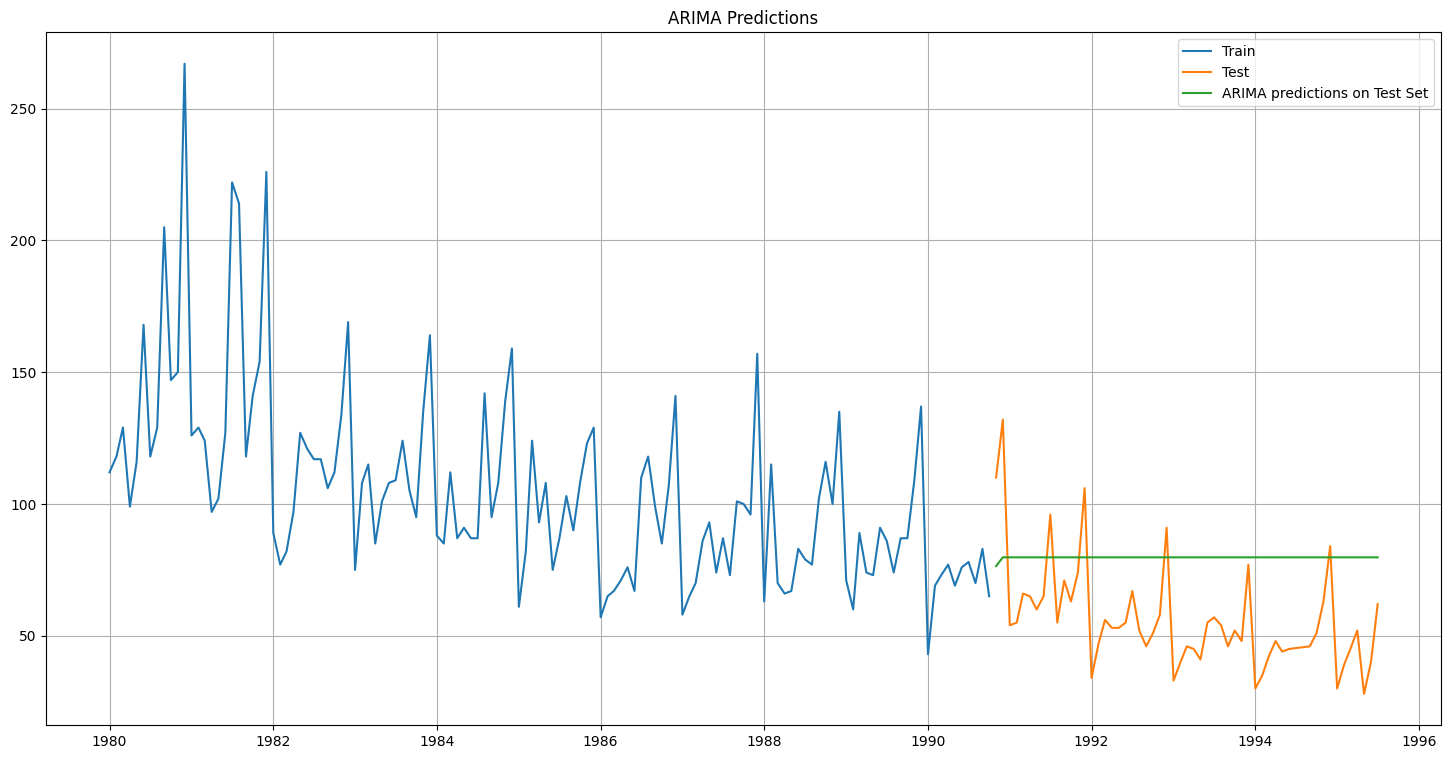

In [272]:
plt.figure(figsize=(18,9))
plt.plot(arima_train['Rose'], label='Train')
plt.plot(arima_test['Rose'], label='Test')
plt.plot(arima_test['ARIMA_forecast'], label='ARIMA predictions on Test Set')


plt.legend(loc='best')
plt.grid()
plt.title('ARIMA Predictions');

## Auto SARIMA

In [273]:
auto_train = train.copy()
auto_test = test.copy()


In [274]:
auto_SARIMA_model = auto_arima(auto_train['Rose'],
                                seasonal=True,
                                m=12,
                                stepwise=True,
                                trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=5.13 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1315.165, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1257.532, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1313.176, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1299.056, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1239.860, Time=0.56 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1234.971, Time=1.44 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=1236.823, Time=1.26 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1235.072, Time=1.28 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=1211.221, Time=1.68 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1209.221, Time=2.51 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : 

In [275]:
print(auto_SARIMA_model.summary())

# Predict on the test data
predicted_auto_SARIMA = auto_SARIMA_model.predict(n_periods=len(auto_test))

# Add the predictions to the test set
auto_test['auto_sarima_forecast'] = predicted_auto_SARIMA

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  130
Model:             SARIMAX(5, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -585.456
Date:                            Sun, 08 Dec 2024   AIC                           1190.913
Time:                                    17:28:29   BIC                           1219.511
Sample:                                01-01-1980   HQIC                          1202.533
                                     - 10-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0070      0.015     -0.461      0.645      -0.037       0.023
ar.L1          0.2135      0.104   

In [276]:
# Calculate RMSE for the SARIMA model
auto_SARIMA_rmse_test = mean_squared_error(auto_test['Rose'], predicted_auto_SARIMA, squared=False)
print("For auto SARIMA forecast on the Test Data, RMSE is %3.2f" % (auto_SARIMA_rmse_test))

For auto SARIMA forecast on the Test Data, RMSE is 11.64


In [277]:
resultsDf_10 = pd.DataFrame({'Test RMSE': [auto_SARIMA_rmse_test]},
                           index=['Auto SARIMA'])

# Concatenate with existing results
resultsDf = pd.concat([resultsDf, resultsDf_10])

In [278]:
resultsDf

Test RMSE
RegressionOnTime                                    17.333437
SimpleAverage                                       52.412093
2pointTrailingMovingAverage                         11.801043
4pointTrailingMovingAverage                         15.367212
6pointTrailingMovingAverage                         15.862350
9pointTrailingMovingAverage                         16.341919
Alpha=0.12,SimpleExponentialSmoothing               29.223677
Alpha=0.9,SimpleExponentialSmoothing                22.496819
Alpha=0.3,Beta=0.4,DoubleExponentialSmoothing       18.343250
Alpha=0.0999,Beta=1.9932,Gamma=0.0001,TripleExp...   9.328733
Alpha=0.3,Beta=0.7,Gamma=0.4,TripleExponentialS...  28.362899
AutoARIMA                                           30.903804
ARIMA                                               30.903804
Auto SARIMA                                         11.637070

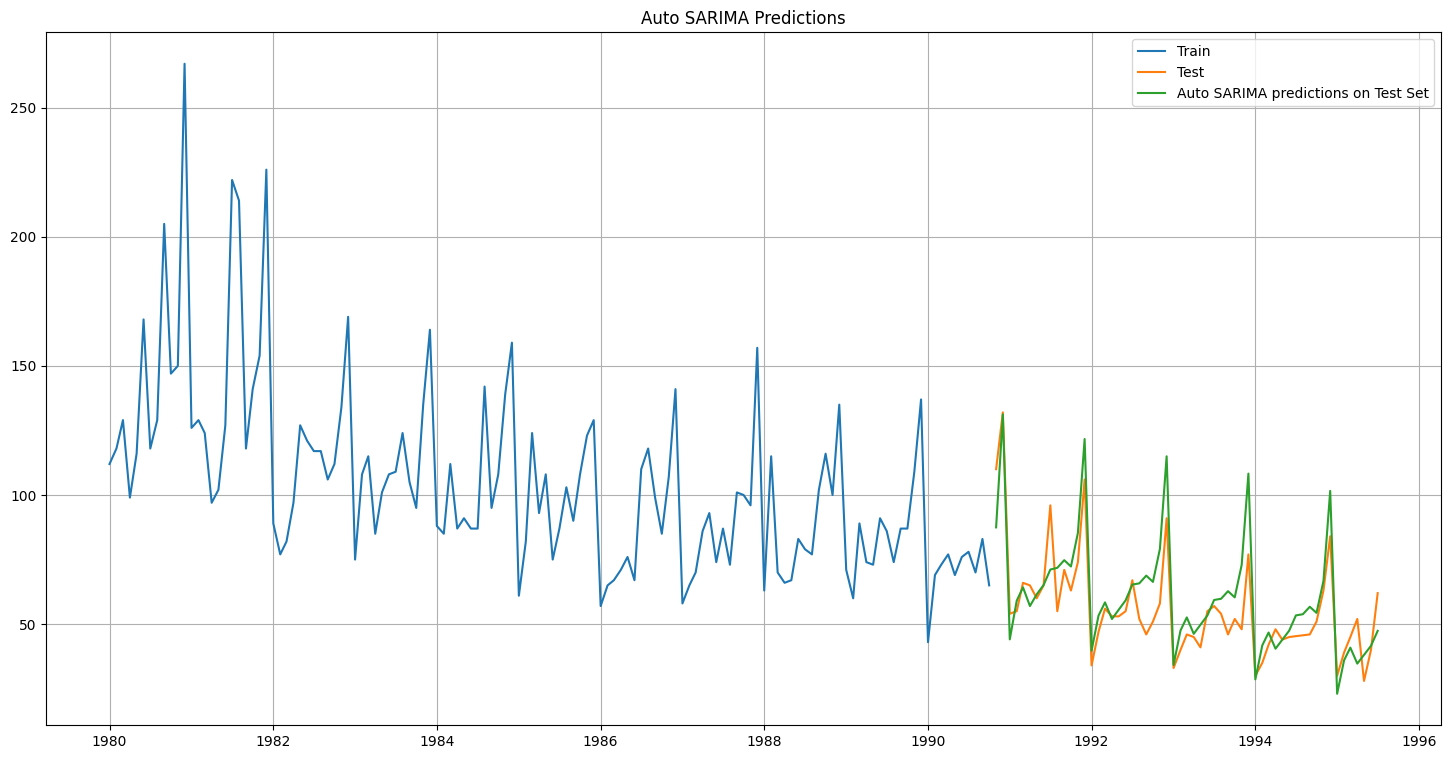

In [279]:
plt.figure(figsize=(18,9))
plt.plot(auto_train['Rose'], label='Train')
plt.plot(auto_test['Rose'], label='Test')
plt.plot(auto_test['auto_sarima_forecast'], label='Auto SARIMA predictions on Test Set')


plt.legend(loc='best')
plt.grid()
plt.title('Auto SARIMA Predictions');

###SARIMA model.

In [280]:
sarima_train = train.copy()
sarima_test = test.copy()

In [281]:
p = q = range(0, 3)
d = range(1, 2)  # Typically set to 1 for first differencing
seasonal_p = seasonal_q = range(0, 3)
seasonal_d = range(1, 2)
s = 12

In [282]:
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(seasonal_p, seasonal_d, seasonal_q, [s]))

# AIC DataFrame to store results
SARIMA_AIC = pd.DataFrame(columns=['param', 'seasonal_param', 'AIC'])

In [283]:
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            # Fit SARIMA model
            SARIMA_model = SARIMAX(sarima_train['Rose'], order=param, seasonal_order=seasonal_param).fit()

            # Print the AIC value for the current parameter combination
            print('SARIMA{}x{} - AIC:{}'.format(param, seasonal_param, SARIMA_model.aic))

            # Append the parameter combination and its corresponding AIC to the DataFrame
            new_row = pd.DataFrame({'param': [param], 'seasonal_param': [seasonal_param], 'AIC': [SARIMA_model.aic]})
            SARIMA_AIC = pd.concat([SARIMA_AIC, new_row], ignore_index=True)

        except Exception as e:
            print(f"SARIMA{param}x{seasonal_param} - Exception: {e}")

SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:1161.8192353274042
SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:1124.3353905548295
SARIMA(0, 1, 0)x(0, 1, 2, 12) - AIC:1126.324600370739
SARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:1133.257525337164
SARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:1126.3173994422862
SARIMA(0, 1, 0)x(1, 1, 2, 12) - AIC:1127.9132232077684
SARIMA(0, 1, 0)x(2, 1, 0, 12) - AIC:1129.310273155749
SARIMA(0, 1, 0)x(2, 1, 1, 12) - AIC:1126.6885311366095
SARIMA(0, 1, 0)x(2, 1, 2, 12) - AIC:1129.7841079075204
SARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:1115.055169838998
SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:1075.3815864416829
SARIMA(0, 1, 1)x(0, 1, 2, 12) - AIC:1077.0452171979746
SARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:1084.3672276931768
SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:1076.9736890085314
SARIMA(0, 1, 1)x(1, 1, 2, 12) - AIC:1078.7907266938964
SARIMA(0, 1, 1)x(2, 1, 0, 12) - AIC:1079.5453626803783
SARIMA(0, 1, 1)x(2, 1, 1, 12) - AIC:1078.9927576310947
SARIMA(0, 1, 1)x(2, 1, 2, 12) - AIC:1079.7402083315417
SARIMA(0, 1, 2

In [284]:
SARIMA_AIC = SARIMA_AIC.sort_values(by='AIC', ascending=True)
print(SARIMA_AIC)

        param seasonal_param          AIC
46  (1, 1, 2)  (0, 1, 1, 12)  1070.217719
73  (2, 1, 2)  (0, 1, 1, 12)  1071.797196
49  (1, 1, 2)  (1, 1, 1, 12)  1072.193427
47  (1, 1, 2)  (0, 1, 2, 12)  1072.198950
64  (2, 1, 1)  (0, 1, 1, 12)  1072.413245
..        ...            ...          ...
8   (0, 1, 0)  (2, 1, 2, 12)  1129.784108
3   (0, 1, 0)  (1, 1, 0, 12)  1133.257525
54  (2, 1, 0)  (0, 1, 0, 12)  1133.676587
27  (1, 1, 0)  (0, 1, 0, 12)  1155.449437
0   (0, 1, 0)  (0, 1, 0, 12)  1161.819235

[81 rows x 3 columns]


In [285]:
best_param = SARIMA_AIC.iloc[0]['param']
best_seasonal_param = SARIMA_AIC.iloc[0]['seasonal_param']

In [286]:
model = SARIMAX(sarima_train['Rose'], order=best_param, seasonal_order=best_seasonal_param).fit()

In [287]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 Rose   No. Observations:                  130
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -530.109
Date:                              Sun, 08 Dec 2024   AIC                           1070.218
Time:                                      17:31:42   BIC                           1084.029
Sample:                                  01-01-1980   HQIC                          1075.825
                                       - 10-01-1990                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5383      0.200     -2.694      0.007      -0.930      -0.147
ma.L1         -0.13

In [288]:


# Forecasting on the test set
predicted_SARIMA = model.forecast(steps=len(sarima_test))

# Add forecast to the test set
sarima_test['SARIMA_forecast'] = predicted_SARIMA

In [289]:
SARIMA_rmse_test = mean_squared_error(sarima_test['Rose'], predicted_SARIMA, squared=False)
print("For SARIMA forecast on the Test Data, RMSE is %3.2f" % (SARIMA_rmse_test))

For SARIMA forecast on the Test Data, RMSE is 13.15


In [290]:
resultsDf_11 = pd.DataFrame({'Test RMSE': [SARIMA_rmse_test]}, index=['SARIMA'])
resultsDf = pd.concat([resultsDf, resultsDf_11])

In [291]:
resultsDf

Test RMSE
RegressionOnTime                                    17.333437
SimpleAverage                                       52.412093
2pointTrailingMovingAverage                         11.801043
4pointTrailingMovingAverage                         15.367212
6pointTrailingMovingAverage                         15.862350
9pointTrailingMovingAverage                         16.341919
Alpha=0.12,SimpleExponentialSmoothing               29.223677
Alpha=0.9,SimpleExponentialSmoothing                22.496819
Alpha=0.3,Beta=0.4,DoubleExponentialSmoothing       18.343250
Alpha=0.0999,Beta=1.9932,Gamma=0.0001,TripleExp...   9.328733
Alpha=0.3,Beta=0.7,Gamma=0.4,TripleExponentialS...  28.362899
AutoARIMA                                           30.903804
ARIMA                                               30.903804
Auto SARIMA                                         11.637070
SARIMA                                              13.150083

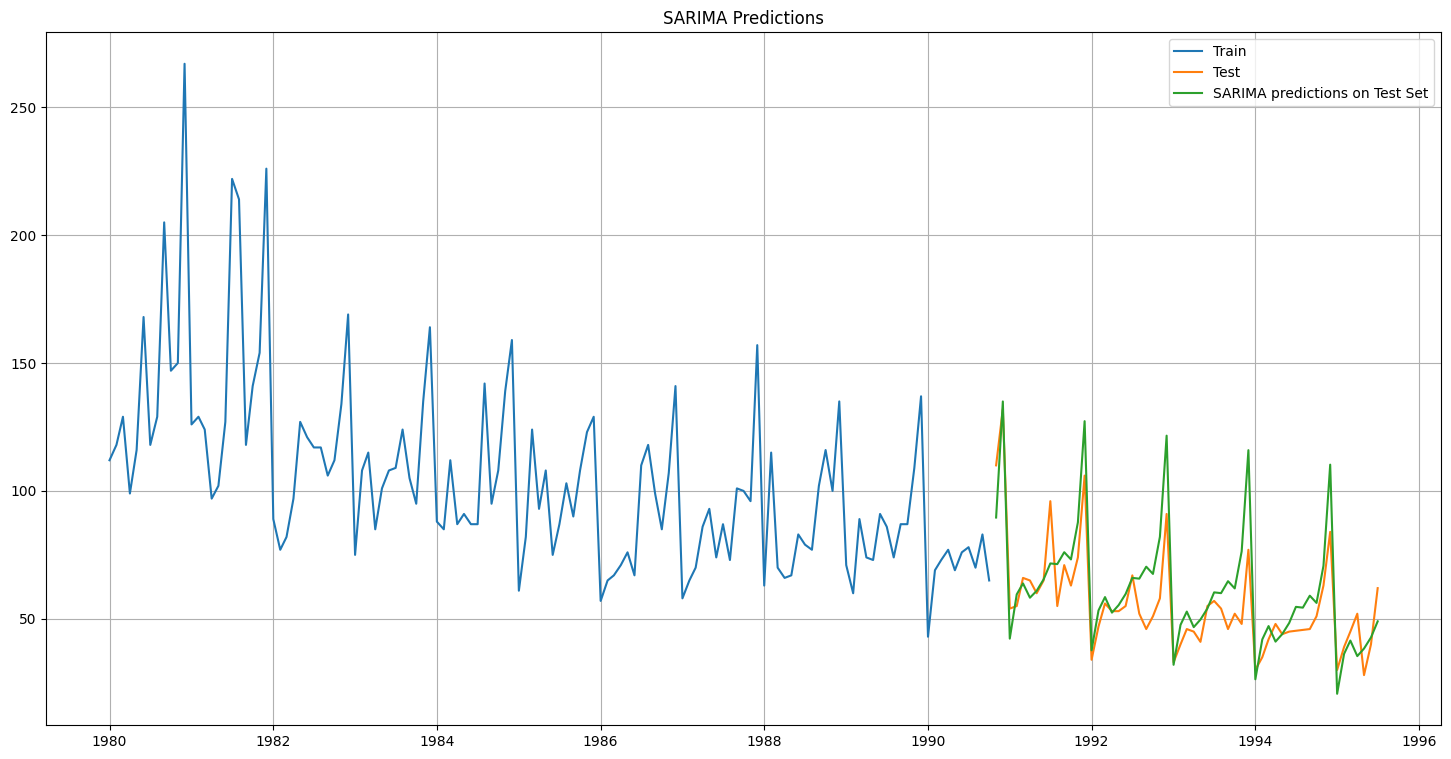

In [292]:


# Plot the results
plt.figure(figsize=(18, 9))
plt.plot(sarima_train['Rose'], label='Train')
plt.plot(sarima_test['Rose'], label='Test')
plt.plot(sarima_test['SARIMA_forecast'], label='SARIMA predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('SARIMA Predictions');
plt.show()

#**Compare the performance of the models**

In [293]:
resultsDf.sort_values(by='Test RMSE')

Test RMSE
Alpha=0.0999,Beta=1.9932,Gamma=0.0001,TripleExp...   9.328733
Auto SARIMA                                         11.637070
2pointTrailingMovingAverage                         11.801043
SARIMA                                              13.150083
4pointTrailingMovingAverage                         15.367212
6pointTrailingMovingAverage                         15.862350
9pointTrailingMovingAverage                         16.341919
RegressionOnTime                                    17.333437
Alpha=0.3,Beta=0.4,DoubleExponentialSmoothing       18.343250
Alpha=0.9,SimpleExponentialSmoothing                22.496819
Alpha=0.3,Beta=0.7,Gamma=0.4,TripleExponentialS...  28.362899
Alpha=0.12,SimpleExponentialSmoothing               29.223677
AutoARIMA                                           30.903804
ARIMA                                               30.903804
SimpleAverage                                       52.412093

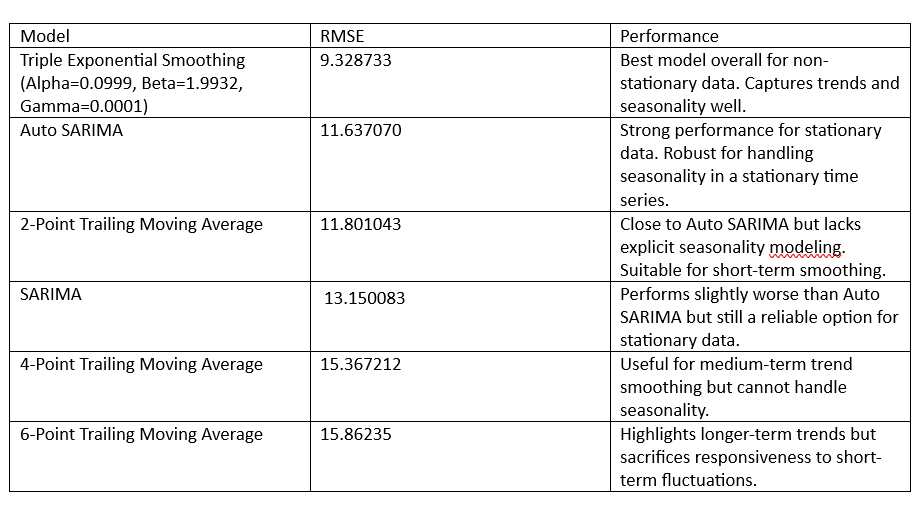

##Best Model based on RMSE - Triple Exponential Smoothing

In [294]:
model_TES = ExponentialSmoothing(df['Rose'],trend='additive',seasonal='multiplicative')

In [295]:
model_TES_autofit = model_TES.fit()

In [296]:
model_TES_autofit.params

{'smoothing_level': 0.10676037827434524,
 'smoothing_trend': 0.00035831062830358297,
 'smoothing_seasonal': 0.0006315707088130293,
 'damping_trend': nan,
 'initial_level': 125.10488381580396,
 'initial_trend': -0.4755107250129778,
 'initial_seasons': array([0.86304147, 0.97999519, 1.08117991, 0.96577954, 1.05593569,
        1.14383271, 1.28323604, 1.32256371, 1.24864487, 1.23402861,
        1.43242055, 1.97495037]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [297]:
df.reset_index(inplace=True)

In [298]:
df

Time_Stamp   Rose
0   1980-01-01  112.0
1   1980-02-01  118.0
2   1980-03-01  129.0
3   1980-04-01   99.0
4   1980-05-01  116.0
..         ...    ...
182 1995-03-01   45.0
183 1995-04-01   52.0
184 1995-05-01   28.0
185 1995-06-01   40.0
186 1995-07-01   62.0

[187 rows x 2 columns]

In [299]:
forecast = model_TES_autofit.forecast(steps=12)


In [300]:
forecast

1995-08-01    47.508280
1995-09-01    44.281676
1995-10-01    43.183578
1995-11-01    49.446947
1995-12-01    67.229184
1996-01-01    28.953180
1996-02-01    32.429759
1996-03-01    35.268451
1996-04-01    31.065020
1996-05-01    33.429002
1996-06-01    35.668083
1996-07-01    39.407534
Freq: MS, dtype: float64

In [301]:
forecast_df = pd.DataFrame(forecast)

In [302]:
forecast_df.reset_index(inplace=True)

In [303]:
forecast_df.columns=['Time_Stamp','Prediction']

In [304]:
final_df = pd.merge(df, forecast_df, on='Time_Stamp', how='outer').sort_values('Time_Stamp')


In [305]:
final_df.index=final_df['Time_Stamp']

In [306]:
final_df.drop(columns=['Time_Stamp'],inplace=True, axis=1)

In [307]:
final_df

Rose  Prediction
Time_Stamp                   
1980-01-01  112.0         NaN
1980-02-01  118.0         NaN
1980-03-01  129.0         NaN
1980-04-01   99.0         NaN
1980-05-01  116.0         NaN
...           ...         ...
1996-03-01    NaN   35.268451
1996-04-01    NaN   31.065020
1996-05-01    NaN   33.429002
1996-06-01    NaN   35.668083
1996-07-01    NaN   39.407534

[199 rows x 2 columns]

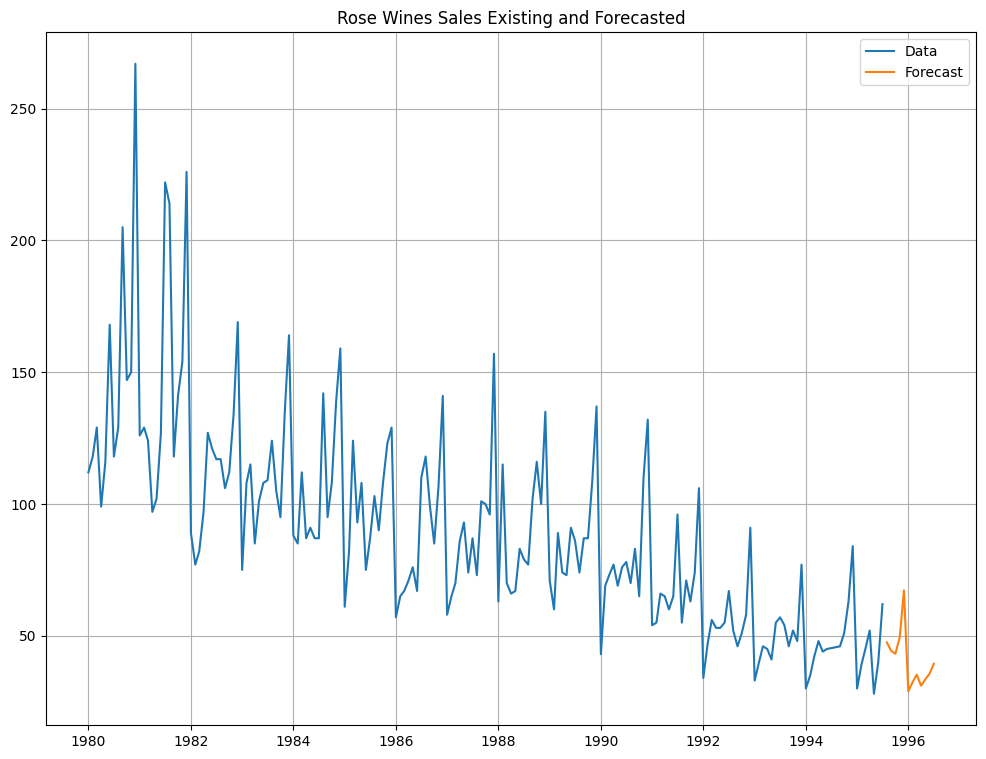

In [308]:
plt.figure(figsize=(12, 9))
plt.plot(final_df['Rose'], label='Data')
plt.plot(final_df['Prediction'], label='Forecast')
plt.title('Rose Wines Sales Existing and Forecasted')
plt.legend(loc='best')
plt.grid()
plt.show()

#**Actionable Insights & Recommendations**

Benefits using the Holt’s Winter Model

*	Accurate Demand Forecasting: Predicts seasonal demand fluctuations, helping to optimize stock availability and prevent overstocking or stockouts.
*	Inventory Optimization: Ensures optimal inventory levels, reducing storage costs and avoiding lost sales due to insufficient stock.
*	Improved Sales & Marketing Strategies: Identifies peak and low-demand periods, enabling targeted marketing campaigns and promotions.
*	Efficient Production Planning: Helps production teams align schedules with demand forecasts, avoiding bottlenecks and production delays.
*	Data-Driven Decision-Making: Provides actionable insights for better decision-making on production, marketing, and distribution strategies.
*	Cost Reduction & Operational Efficiency: Minimizes storage, labour, and production costs by aligning operations with demand forecasts.


Insights
* Rose wine sales show a fluctuating trend, with peaks observed in December and November (holiday season) and lower sales in the early months of the year (January–February).
* There appears to be a clear seasonal pattern, with sales picking up towards the end of the year, particularly around the holiday season.
* The forecasted values, show a rising trend towards the end of 1995 and into 1996. However, the forecast doesn’t perfectly align with the actual data, indicating that while the trend is correct, the magnitude of sales might need further refinement.

##Recommendations

* Focus on marketing campaigns that target the high sales season (November–December), such as holiday discounts or bundle offers with other wine varieties.
* Winter Promotions: Introduce special offers or discounts during the low-demand months (January–March) to incentivize purchases and maintain steady sales.
* Engage with Customers Year-Round: Develop year-round customer engagement strategies such as loyalty programs, wine-tasting events, and educational content to keep customers interested throughout the year.